In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import gc
import matplotlib.pyplot as plt
from torchvision.models import resnet50
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve,ConfusionMatrixDisplay,accuracy_score
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import ViTImageProcessor
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, ToTensor, Normalize, ColorJitter, RandomRotation, RandomAffine
from PIL import ImageFilter
from sklearn.metrics import classification_report
from torchvision.models import efficientnet_b7

### Selecting Device

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


### Paths, Batch size, Seed

In [3]:
path = 'train_dataset'
SEED = 42 
batch_size = 24

## Loading Training Data

### Transforms

In [4]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

In [5]:
transform = Compose([
    Resize((size, size)),
    ToTensor(),
    Normalize(mean=image_mean, std=image_std)
])

### Loader Function

In [6]:
def data_loader(data_path, batch_size, transform, seed, shuffle=True):
    dataset = datasets.ImageFolder(data_path, transform=transform)
    
    train_size = int(0.85 * len(dataset))
    val_size = len(dataset) - train_size
    train_data, val_data = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=not shuffle)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=shuffle)

    return train_loader, val_loader

### Loading Data

In [7]:
train_loader, val_loader = data_loader(path,batch_size,transform,SEED)

## Training 

In [8]:
print(len(train_loader))
print(len(val_loader))

295
52


In [9]:
!export PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

### Function to train model 

In [10]:
import torch
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

def train_and_evaluate_cv(dataset, model, criterion, optimizer, num_epochs, device, save_path, weight_decay=1e-4, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits)
    all_train_losses, all_val_losses = [], []
    all_train_accuracies, all_val_accuracies = [], []
    all_train_aucs, all_val_aucs = [], []

    targets = dataset.targets if hasattr(dataset, 'targets') else dataset.labels

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
        print(f'Fold {fold+1}/{n_splits}')

        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = torch.utils.data.DataLoader(dataset, sampler=train_sampler, batch_size=32)
        val_loader = torch.utils.data.DataLoader(dataset, sampler=val_sampler, batch_size=32)

        model.to(device)

        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        train_aucs, val_aucs = [], []

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            train_preds = []
            train_targets = []

            for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False):
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets.float().view(-1, 1))
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                train_preds.extend(torch.sigmoid(outputs).cpu().detach().numpy())
                train_targets.extend(targets.cpu().detach().numpy())

            epoch_loss = running_loss / len(train_loader.dataset)
            train_accuracy = accuracy_score(train_targets, np.round(train_preds))
            train_auc = roc_auc_score(train_targets, train_preds)

            train_losses.append(epoch_loss)
            train_accuracies.append(train_accuracy)
            train_aucs.append(train_auc)

            model.eval()
            val_preds = []
            val_targets = []
            val_loss = 0.0

            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False):
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets.float().view(-1, 1))
                val_loss += loss.item() * inputs.size(0)

                val_preds.extend(torch.sigmoid(outputs).cpu().detach().numpy())
                val_targets.extend(targets.cpu().detach().numpy())

            val_loss /= len(val_loader.dataset)
            val_accuracy = accuracy_score(val_targets, np.round(val_preds))
            val_auc = roc_auc_score(val_targets, val_preds)

            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            val_aucs.append(val_auc)

            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {epoch_loss:.4f} | Train ROC-AUC: {train_auc:.4f} | Train Accuracy: {train_accuracy:.4f}')
            print(f'Validation Loss: {val_loss:.4f} | Validation ROC-AUC: {val_auc:.4f} | Validation Accuracy: {val_accuracy:.4f}')

        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_train_accuracies.append(train_accuracies)
        all_val_accuracies.append(val_accuracies)
        all_train_aucs.append(train_aucs)
        all_val_aucs.append(val_aucs)

        # Save fold
        torch.save(model.state_dict(), f"{save_path}_fold{fold+1}.pth")

        val_preds_binary = np.round(val_preds)
        cm = confusion_matrix(val_targets, val_preds_binary)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix (Validation Set) - Fold {fold+1}')
        plt.show()

    avg_train_losses = np.mean(all_train_losses, axis=0)
    avg_val_losses = np.mean(all_val_losses, axis=0)
    avg_train_accuracies = np.mean(all_train_accuracies, axis=0)
    avg_val_accuracies = np.mean(all_val_accuracies, axis=0)
    avg_train_aucs = np.mean(all_train_aucs, axis=0)
    avg_val_aucs = np.mean(all_val_aucs, axis=0)

    epochs = range(1, num_epochs + 1)

    # Loss 
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, avg_train_losses, label='Train Loss')
    plt.plot(epochs, avg_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Average Training and Validation Loss')
    plt.show()

    # Accuracy 
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, avg_train_accuracies, label='Train Accuracy')
    plt.plot(epochs, avg_val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Average Training and Validation Accuracy')
    plt.show()

    # AUC 
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, avg_train_aucs, label='Train AUC')
    plt.plot(epochs, avg_val_aucs, label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.title('Average Training and Validation AUC')
    plt.show()

### Function to evaluate on Test Set

In [11]:
num_class_0 = 8000
num_class_1 = 315
pos_weight = torch.tensor([num_class_0 / num_class_1], dtype=torch.float32).to(device)    

In [12]:
model = resnet50()
model.fc = nn.Linear(model.fc.in_features, 1)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optim = torch.optim.Adam(model.parameters(),lr=0.0003)
num_epoch = 20

In [13]:
dataset = datasets.ImageFolder('train_dataset', transform=transform)

### Training with no Data Augmentation & Resnet

Fold 1/5


Epoch 1/20
Train Loss: 1.1781 | Train ROC-AUC: 0.6975 | Train Accuracy: 0.7045
Validation Loss: 0.2060 | Validation ROC-AUC: 0.8423 | Validation Accuracy: 0.9176


Epoch 2/20
Train Loss: 0.8407 | Train ROC-AUC: 0.8034 | Train Accuracy: 0.8186
Validation Loss: 0.2059 | Validation ROC-AUC: 0.8308 | Validation Accuracy: 0.7715


Epoch 3/20
Train Loss: 0.8044 | Train ROC-AUC: 0.8221 | Train Accuracy: 0.8134
Validation Loss: 0.2356 | Validation ROC-AUC: 0.8390 | Validation Accuracy: 0.8515


Epoch 4/20
Train Loss: 0.7775 | Train ROC-AUC: 0.8327 | Train Accuracy: 0.8171
Validation Loss: 0.2066 | Validation ROC-AUC: 0.8460 | Validation Accuracy: 0.7673


Epoch 5/20
Train Loss: 0.7401 | Train ROC-AUC: 0.8488 | Train Accuracy: 0.8343
Validation Loss: 0.2098 | Validation ROC-AUC: 0.8282 | Validation Accuracy: 0.8882


Epoch 6/20
Train Loss: 0.7483 | Train ROC-AUC: 0.8480 | Train Accuracy: 0.8251
Validation Loss: 0.2328 | Validation ROC-AUC: 0.8171 | Validation Accuracy: 0.8894


Epoch 7/20
Train Loss: 0.8075 | Train ROC-AUC: 0.8230 | Train Accuracy: 0.7998
Validation Loss: 0.1833 | Validation ROC-AUC: 0.8457 | Validation Accuracy: 0.8388


Epoch 8/20
Train Loss: 0.7875 | Train ROC-AUC: 0.8289 | Train Accuracy: 0.8029
Validation Loss: 0.3005 | Validation ROC-AUC: 0.8434 | Validation Accuracy: 0.6891


Epoch 9/20
Train Loss: 0.7308 | Train ROC-AUC: 0.8569 | Train Accuracy: 0.8188
Validation Loss: 0.2692 | Validation ROC-AUC: 0.8587 | Validation Accuracy: 0.7980


Epoch 10/20
Train Loss: 0.7431 | Train ROC-AUC: 0.8480 | Train Accuracy: 0.8098
Validation Loss: 0.2081 | Validation ROC-AUC: 0.8468 | Validation Accuracy: 0.8930


Epoch 11/20
Train Loss: 0.7255 | Train ROC-AUC: 0.8561 | Train Accuracy: 0.8048
Validation Loss: 0.1999 | Validation ROC-AUC: 0.8615 | Validation Accuracy: 0.8755


Epoch 12/20
Train Loss: 0.6898 | Train ROC-AUC: 0.8715 | Train Accuracy: 0.8450
Validation Loss: 0.1865 | Validation ROC-AUC: 0.8632 | Validation Accuracy: 0.8611


Epoch 13/20
Train Loss: 0.6915 | Train ROC-AUC: 0.8708 | Train Accuracy: 0.8567
Validation Loss: 0.1885 | Validation ROC-AUC: 0.8573 | Validation Accuracy: 0.8413


Epoch 14/20
Train Loss: 0.7011 | Train ROC-AUC: 0.8675 | Train Accuracy: 0.8319
Validation Loss: 0.2139 | Validation ROC-AUC: 0.8666 | Validation Accuracy: 0.7601


Epoch 15/20
Train Loss: 0.7341 | Train ROC-AUC: 0.8535 | Train Accuracy: 0.8108
Validation Loss: 0.1981 | Validation ROC-AUC: 0.8634 | Validation Accuracy: 0.8876


Epoch 16/20
Train Loss: 0.6835 | Train ROC-AUC: 0.8744 | Train Accuracy: 0.8269
Validation Loss: 0.2012 | Validation ROC-AUC: 0.8473 | Validation Accuracy: 0.8364


Epoch 17/20
Train Loss: 0.6830 | Train ROC-AUC: 0.8774 | Train Accuracy: 0.8149
Validation Loss: 0.2069 | Validation ROC-AUC: 0.8580 | Validation Accuracy: 0.8605


Epoch 18/20
Train Loss: 0.6624 | Train ROC-AUC: 0.8844 | Train Accuracy: 0.8430
Validation Loss: 0.1956 | Validation ROC-AUC: 0.8233 | Validation Accuracy: 0.8623


Epoch 19/20
Train Loss: 0.6592 | Train ROC-AUC: 0.8868 | Train Accuracy: 0.8374
Validation Loss: 0.2654 | Validation ROC-AUC: 0.8479 | Validation Accuracy: 0.7312


Epoch 20/20
Train Loss: 0.6672 | Train ROC-AUC: 0.8851 | Train Accuracy: 0.8254
Validation Loss: 0.2309 | Validation ROC-AUC: 0.8389 | Validation Accuracy: 0.8719


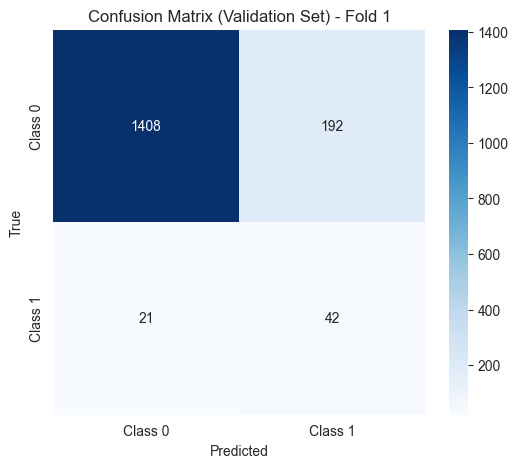

Fold 2/5


Epoch 1/20
Train Loss: 0.6813 | Train ROC-AUC: 0.8771 | Train Accuracy: 0.8293
Validation Loss: 0.1693 | Validation ROC-AUC: 0.8843 | Validation Accuracy: 0.8328


Epoch 2/20
Train Loss: 0.6604 | Train ROC-AUC: 0.8861 | Train Accuracy: 0.8356
Validation Loss: 0.1568 | Validation ROC-AUC: 0.8936 | Validation Accuracy: 0.8653


Epoch 3/20
Train Loss: 0.6677 | Train ROC-AUC: 0.8811 | Train Accuracy: 0.8436
Validation Loss: 0.2026 | Validation ROC-AUC: 0.8418 | Validation Accuracy: 0.8298


Epoch 4/20
Train Loss: 0.6519 | Train ROC-AUC: 0.8884 | Train Accuracy: 0.8319
Validation Loss: 0.1748 | Validation ROC-AUC: 0.8736 | Validation Accuracy: 0.8653


Epoch 5/20
Train Loss: 0.6540 | Train ROC-AUC: 0.8872 | Train Accuracy: 0.8412
Validation Loss: 0.1882 | Validation ROC-AUC: 0.8751 | Validation Accuracy: 0.8262


Epoch 6/20
Train Loss: 0.6396 | Train ROC-AUC: 0.8912 | Train Accuracy: 0.8386
Validation Loss: 0.1858 | Validation ROC-AUC: 0.8773 | Validation Accuracy: 0.8737


Epoch 7/20
Train Loss: 0.6510 | Train ROC-AUC: 0.8904 | Train Accuracy: 0.8350
Validation Loss: 0.1661 | Validation ROC-AUC: 0.8880 | Validation Accuracy: 0.8894


Epoch 8/20
Train Loss: 0.6140 | Train ROC-AUC: 0.9009 | Train Accuracy: 0.8403
Validation Loss: 0.1751 | Validation ROC-AUC: 0.8839 | Validation Accuracy: 0.8689


Epoch 9/20
Train Loss: 0.5857 | Train ROC-AUC: 0.9119 | Train Accuracy: 0.8392
Validation Loss: 0.2429 | Validation ROC-AUC: 0.8511 | Validation Accuracy: 0.6783


Epoch 10/20
Train Loss: 0.6031 | Train ROC-AUC: 0.9059 | Train Accuracy: 0.8320
Validation Loss: 0.3262 | Validation ROC-AUC: 0.7673 | Validation Accuracy: 0.8954


Epoch 11/20
Train Loss: 0.6253 | Train ROC-AUC: 0.8980 | Train Accuracy: 0.8314
Validation Loss: 0.1950 | Validation ROC-AUC: 0.8545 | Validation Accuracy: 0.9062


Epoch 12/20
Train Loss: 0.5947 | Train ROC-AUC: 0.9076 | Train Accuracy: 0.8459
Validation Loss: 0.1786 | Validation ROC-AUC: 0.8738 | Validation Accuracy: 0.8665


Epoch 13/20
Train Loss: 0.6215 | Train ROC-AUC: 0.9014 | Train Accuracy: 0.8241
Validation Loss: 0.1881 | Validation ROC-AUC: 0.8755 | Validation Accuracy: 0.8833


Epoch 14/20
Train Loss: 0.5934 | Train ROC-AUC: 0.9089 | Train Accuracy: 0.8386
Validation Loss: 0.1875 | Validation ROC-AUC: 0.8755 | Validation Accuracy: 0.7974


Epoch 15/20
Train Loss: 0.5824 | Train ROC-AUC: 0.9132 | Train Accuracy: 0.8368
Validation Loss: 0.1649 | Validation ROC-AUC: 0.8943 | Validation Accuracy: 0.8292


Epoch 16/20
Train Loss: 0.5161 | Train ROC-AUC: 0.9295 | Train Accuracy: 0.8516
Validation Loss: 0.1850 | Validation ROC-AUC: 0.8858 | Validation Accuracy: 0.8972


Epoch 17/20
Train Loss: 0.5375 | Train ROC-AUC: 0.9248 | Train Accuracy: 0.8514
Validation Loss: 0.1880 | Validation ROC-AUC: 0.8792 | Validation Accuracy: 0.8226


Epoch 18/20
Train Loss: 0.4800 | Train ROC-AUC: 0.9396 | Train Accuracy: 0.8630
Validation Loss: 0.2293 | Validation ROC-AUC: 0.8641 | Validation Accuracy: 0.9164


Epoch 19/20
Train Loss: 0.5258 | Train ROC-AUC: 0.9279 | Train Accuracy: 0.8537
Validation Loss: 0.1838 | Validation ROC-AUC: 0.8851 | Validation Accuracy: 0.8437


Epoch 20/20
Train Loss: 0.4450 | Train ROC-AUC: 0.9476 | Train Accuracy: 0.8738
Validation Loss: 0.1847 | Validation ROC-AUC: 0.8860 | Validation Accuracy: 0.8659


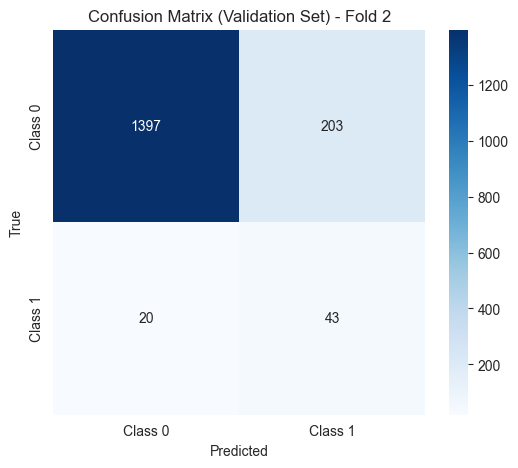

Fold 3/5


Epoch 1/20
Train Loss: 0.5838 | Train ROC-AUC: 0.9109 | Train Accuracy: 0.8543
Validation Loss: 0.1237 | Validation ROC-AUC: 0.9418 | Validation Accuracy: 0.9200


Epoch 2/20
Train Loss: 0.5034 | Train ROC-AUC: 0.9343 | Train Accuracy: 0.8615
Validation Loss: 0.1313 | Validation ROC-AUC: 0.9326 | Validation Accuracy: 0.8984


Epoch 3/20
Train Loss: 0.5188 | Train ROC-AUC: 0.9300 | Train Accuracy: 0.8620
Validation Loss: 0.1573 | Validation ROC-AUC: 0.9383 | Validation Accuracy: 0.9447


Epoch 4/20
Train Loss: 0.4540 | Train ROC-AUC: 0.9456 | Train Accuracy: 0.8800
Validation Loss: 0.1240 | Validation ROC-AUC: 0.9470 | Validation Accuracy: 0.9146


Epoch 5/20
Train Loss: 0.4465 | Train ROC-AUC: 0.9477 | Train Accuracy: 0.8759
Validation Loss: 0.1906 | Validation ROC-AUC: 0.9101 | Validation Accuracy: 0.9339


Epoch 6/20
Train Loss: 0.4592 | Train ROC-AUC: 0.9449 | Train Accuracy: 0.8779
Validation Loss: 0.1724 | Validation ROC-AUC: 0.9297 | Validation Accuracy: 0.9423


Epoch 7/20
Train Loss: 0.4368 | Train ROC-AUC: 0.9490 | Train Accuracy: 0.8875
Validation Loss: 0.1634 | Validation ROC-AUC: 0.8996 | Validation Accuracy: 0.8809


Epoch 8/20
Train Loss: 0.3865 | Train ROC-AUC: 0.9592 | Train Accuracy: 0.8881
Validation Loss: 0.2003 | Validation ROC-AUC: 0.8570 | Validation Accuracy: 0.8400


Epoch 9/20
Train Loss: 0.4316 | Train ROC-AUC: 0.9502 | Train Accuracy: 0.8750
Validation Loss: 0.1794 | Validation ROC-AUC: 0.9048 | Validation Accuracy: 0.8106


Epoch 10/20
Train Loss: 0.3228 | Train ROC-AUC: 0.9706 | Train Accuracy: 0.9027
Validation Loss: 0.1702 | Validation ROC-AUC: 0.9262 | Validation Accuracy: 0.9164


Epoch 11/20
Train Loss: 0.2759 | Train ROC-AUC: 0.9773 | Train Accuracy: 0.9171
Validation Loss: 0.2218 | Validation ROC-AUC: 0.9158 | Validation Accuracy: 0.9110


Epoch 12/20
Train Loss: 0.3414 | Train ROC-AUC: 0.9684 | Train Accuracy: 0.9045
Validation Loss: 0.1602 | Validation ROC-AUC: 0.9133 | Validation Accuracy: 0.8611


Epoch 13/20
Train Loss: 0.2852 | Train ROC-AUC: 0.9765 | Train Accuracy: 0.9143
Validation Loss: 0.1674 | Validation ROC-AUC: 0.9258 | Validation Accuracy: 0.8244


Epoch 14/20
Train Loss: 0.2610 | Train ROC-AUC: 0.9788 | Train Accuracy: 0.9164
Validation Loss: 0.2644 | Validation ROC-AUC: 0.9186 | Validation Accuracy: 0.9417


Epoch 15/20
Train Loss: 0.2501 | Train ROC-AUC: 0.9800 | Train Accuracy: 0.9224
Validation Loss: 0.2509 | Validation ROC-AUC: 0.9140 | Validation Accuracy: 0.9224


Epoch 16/20
Train Loss: 0.3030 | Train ROC-AUC: 0.9747 | Train Accuracy: 0.9140
Validation Loss: 0.3673 | Validation ROC-AUC: 0.8870 | Validation Accuracy: 0.9459


Epoch 17/20
Train Loss: 0.2397 | Train ROC-AUC: 0.9817 | Train Accuracy: 0.9280
Validation Loss: 0.2396 | Validation ROC-AUC: 0.9071 | Validation Accuracy: 0.9080


Epoch 18/20
Train Loss: 0.2194 | Train ROC-AUC: 0.9855 | Train Accuracy: 0.9356
Validation Loss: 0.3030 | Validation ROC-AUC: 0.8997 | Validation Accuracy: 0.9411


Epoch 19/20
Train Loss: 0.1901 | Train ROC-AUC: 0.9877 | Train Accuracy: 0.9454
Validation Loss: 0.2519 | Validation ROC-AUC: 0.9119 | Validation Accuracy: 0.9200


Epoch 20/20
Train Loss: 0.1771 | Train ROC-AUC: 0.9890 | Train Accuracy: 0.9508
Validation Loss: 0.2466 | Validation ROC-AUC: 0.8981 | Validation Accuracy: 0.8743


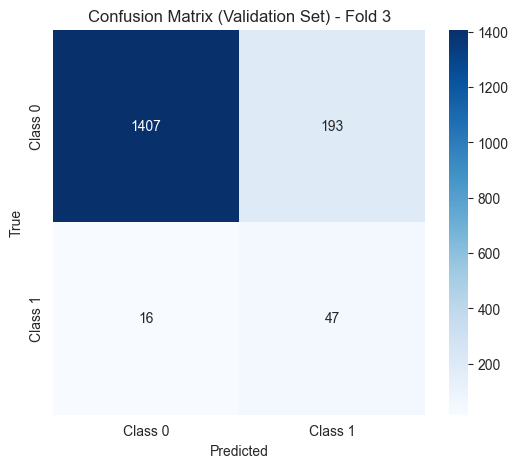

Fold 4/5


Epoch 1/20
Train Loss: 0.4502 | Train ROC-AUC: 0.9500 | Train Accuracy: 0.8785
Validation Loss: 0.0575 | Validation ROC-AUC: 0.9847 | Validation Accuracy: 0.9308


Epoch 2/20
Train Loss: 0.3086 | Train ROC-AUC: 0.9738 | Train Accuracy: 0.9154
Validation Loss: 0.0675 | Validation ROC-AUC: 0.9785 | Validation Accuracy: 0.9176


Epoch 3/20
Train Loss: 0.3024 | Train ROC-AUC: 0.9741 | Train Accuracy: 0.9095
Validation Loss: 0.0583 | Validation ROC-AUC: 0.9840 | Validation Accuracy: 0.9079


Epoch 4/20
Train Loss: 0.2489 | Train ROC-AUC: 0.9812 | Train Accuracy: 0.9268
Validation Loss: 0.1020 | Validation ROC-AUC: 0.9539 | Validation Accuracy: 0.8586


Epoch 5/20
Train Loss: 0.2229 | Train ROC-AUC: 0.9839 | Train Accuracy: 0.9319
Validation Loss: 0.0395 | Validation ROC-AUC: 0.9913 | Validation Accuracy: 0.9585


Epoch 6/20
Train Loss: 0.2462 | Train ROC-AUC: 0.9828 | Train Accuracy: 0.9286
Validation Loss: 0.0894 | Validation ROC-AUC: 0.9754 | Validation Accuracy: 0.9537


Epoch 7/20
Train Loss: 0.1844 | Train ROC-AUC: 0.9891 | Train Accuracy: 0.9493
Validation Loss: 0.0913 | Validation ROC-AUC: 0.9753 | Validation Accuracy: 0.8592


Epoch 8/20
Train Loss: 0.2191 | Train ROC-AUC: 0.9863 | Train Accuracy: 0.9412
Validation Loss: 0.1201 | Validation ROC-AUC: 0.9707 | Validation Accuracy: 0.9519


Epoch 9/20
Train Loss: 0.2085 | Train ROC-AUC: 0.9861 | Train Accuracy: 0.9381
Validation Loss: 0.0544 | Validation ROC-AUC: 0.9846 | Validation Accuracy: 0.9344


Epoch 10/20
Train Loss: 0.1153 | Train ROC-AUC: 0.9944 | Train Accuracy: 0.9677
Validation Loss: 0.0770 | Validation ROC-AUC: 0.9721 | Validation Accuracy: 0.9182


Epoch 11/20
Train Loss: 0.2499 | Train ROC-AUC: 0.9838 | Train Accuracy: 0.9397
Validation Loss: 0.0724 | Validation ROC-AUC: 0.9784 | Validation Accuracy: 0.9446


Epoch 12/20
Train Loss: 0.1566 | Train ROC-AUC: 0.9915 | Train Accuracy: 0.9556
Validation Loss: 0.0543 | Validation ROC-AUC: 0.9857 | Validation Accuracy: 0.9434


Epoch 13/20
Train Loss: 0.1601 | Train ROC-AUC: 0.9923 | Train Accuracy: 0.9550
Validation Loss: 0.1270 | Validation ROC-AUC: 0.9624 | Validation Accuracy: 0.9434


Epoch 14/20
Train Loss: 0.1604 | Train ROC-AUC: 0.9914 | Train Accuracy: 0.9502
Validation Loss: 0.1624 | Validation ROC-AUC: 0.9784 | Validation Accuracy: 0.9645


Epoch 15/20
Train Loss: 0.1436 | Train ROC-AUC: 0.9933 | Train Accuracy: 0.9597
Validation Loss: 0.1929 | Validation ROC-AUC: 0.9747 | Validation Accuracy: 0.9663


Epoch 16/20
Train Loss: 0.2029 | Train ROC-AUC: 0.9877 | Train Accuracy: 0.9402
Validation Loss: 0.1102 | Validation ROC-AUC: 0.9767 | Validation Accuracy: 0.9633


Epoch 17/20
Train Loss: 0.1488 | Train ROC-AUC: 0.9933 | Train Accuracy: 0.9587
Validation Loss: 0.0747 | Validation ROC-AUC: 0.9767 | Validation Accuracy: 0.9392


Epoch 18/20
Train Loss: 0.0831 | Train ROC-AUC: 0.9974 | Train Accuracy: 0.9720
Validation Loss: 0.1468 | Validation ROC-AUC: 0.9813 | Validation Accuracy: 0.9687


Epoch 19/20
Train Loss: 0.0686 | Train ROC-AUC: 0.9979 | Train Accuracy: 0.9808
Validation Loss: 0.1575 | Validation ROC-AUC: 0.9736 | Validation Accuracy: 0.9591


Epoch 20/20
Train Loss: 0.1777 | Train ROC-AUC: 0.9910 | Train Accuracy: 0.9541
Validation Loss: 0.3400 | Validation ROC-AUC: 0.9451 | Validation Accuracy: 0.9561


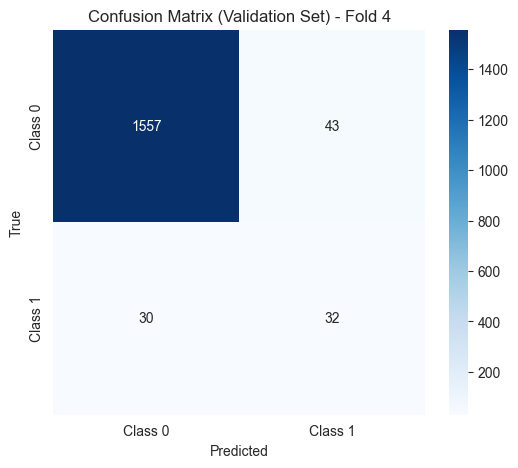

Fold 5/5


Epoch 1/20
Train Loss: 0.3427 | Train ROC-AUC: 0.9727 | Train Accuracy: 0.9172
Validation Loss: 0.0495 | Validation ROC-AUC: 0.9948 | Validation Accuracy: 0.9055


Epoch 2/20
Train Loss: 0.2041 | Train ROC-AUC: 0.9875 | Train Accuracy: 0.9384
Validation Loss: 0.0372 | Validation ROC-AUC: 0.9940 | Validation Accuracy: 0.9621


Epoch 3/20
Train Loss: 0.1489 | Train ROC-AUC: 0.9927 | Train Accuracy: 0.9558
Validation Loss: 0.0371 | Validation ROC-AUC: 0.9956 | Validation Accuracy: 0.9326


Epoch 4/20
Train Loss: 0.0971 | Train ROC-AUC: 0.9959 | Train Accuracy: 0.9707
Validation Loss: 0.0142 | Validation ROC-AUC: 0.9986 | Validation Accuracy: 0.9819


Epoch 5/20
Train Loss: 0.0550 | Train ROC-AUC: 0.9985 | Train Accuracy: 0.9836
Validation Loss: 0.0210 | Validation ROC-AUC: 0.9975 | Validation Accuracy: 0.9759


Epoch 6/20
Train Loss: 0.0967 | Train ROC-AUC: 0.9960 | Train Accuracy: 0.9761
Validation Loss: 0.0401 | Validation ROC-AUC: 0.9928 | Validation Accuracy: 0.9465


Epoch 7/20
Train Loss: 0.1343 | Train ROC-AUC: 0.9940 | Train Accuracy: 0.9617
Validation Loss: 0.0524 | Validation ROC-AUC: 0.9931 | Validation Accuracy: 0.9813


Epoch 8/20
Train Loss: 0.1190 | Train ROC-AUC: 0.9951 | Train Accuracy: 0.9662
Validation Loss: 0.0798 | Validation ROC-AUC: 0.9895 | Validation Accuracy: 0.8718


Epoch 9/20
Train Loss: 0.2341 | Train ROC-AUC: 0.9856 | Train Accuracy: 0.9394
Validation Loss: 0.0410 | Validation ROC-AUC: 0.9927 | Validation Accuracy: 0.9332


Epoch 10/20
Train Loss: 0.1177 | Train ROC-AUC: 0.9950 | Train Accuracy: 0.9629
Validation Loss: 0.0420 | Validation ROC-AUC: 0.9971 | Validation Accuracy: 0.9886


Epoch 11/20
Train Loss: 0.0699 | Train ROC-AUC: 0.9980 | Train Accuracy: 0.9811
Validation Loss: 0.0222 | Validation ROC-AUC: 0.9969 | Validation Accuracy: 0.9723


Epoch 12/20
Train Loss: 0.0591 | Train ROC-AUC: 0.9986 | Train Accuracy: 0.9839
Validation Loss: 0.0215 | Validation ROC-AUC: 0.9975 | Validation Accuracy: 0.9874


Epoch 13/20
Train Loss: 0.0807 | Train ROC-AUC: 0.9977 | Train Accuracy: 0.9779
Validation Loss: 0.0717 | Validation ROC-AUC: 0.9831 | Validation Accuracy: 0.9230


Epoch 14/20
Train Loss: 0.1499 | Train ROC-AUC: 0.9938 | Train Accuracy: 0.9618
Validation Loss: 0.0455 | Validation ROC-AUC: 0.9917 | Validation Accuracy: 0.9254


Epoch 15/20
Train Loss: 0.0749 | Train ROC-AUC: 0.9977 | Train Accuracy: 0.9802
Validation Loss: 0.0483 | Validation ROC-AUC: 0.9902 | Validation Accuracy: 0.9585


Epoch 16/20
Train Loss: 0.0416 | Train ROC-AUC: 0.9992 | Train Accuracy: 0.9874
Validation Loss: 0.0372 | Validation ROC-AUC: 0.9963 | Validation Accuracy: 0.9838


Epoch 17/20
Train Loss: 0.0146 | Train ROC-AUC: 1.0000 | Train Accuracy: 0.9964
Validation Loss: 0.0491 | Validation ROC-AUC: 0.9961 | Validation Accuracy: 0.9880


Epoch 18/20
Train Loss: 0.1940 | Train ROC-AUC: 0.9914 | Train Accuracy: 0.9606
Validation Loss: 0.0912 | Validation ROC-AUC: 0.9719 | Validation Accuracy: 0.8640


Epoch 19/20
Train Loss: 0.2360 | Train ROC-AUC: 0.9844 | Train Accuracy: 0.9430
Validation Loss: 0.0422 | Validation ROC-AUC: 0.9913 | Validation Accuracy: 0.9579


Epoch 20/20
Train Loss: 0.0822 | Train ROC-AUC: 0.9980 | Train Accuracy: 0.9771
Validation Loss: 0.0431 | Validation ROC-AUC: 0.9922 | Validation Accuracy: 0.9645


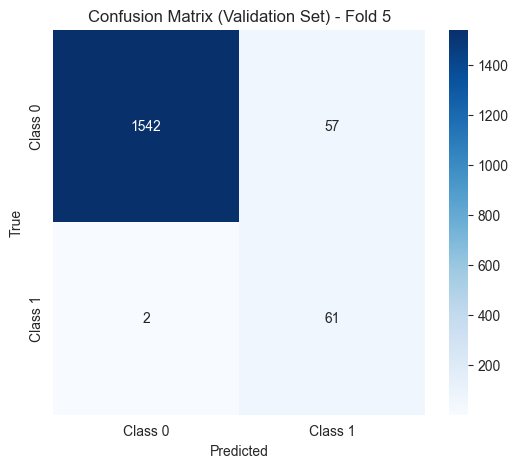

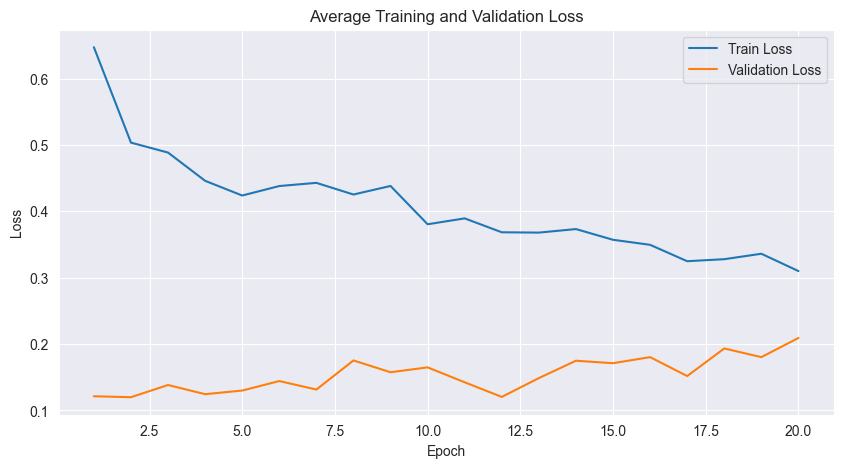

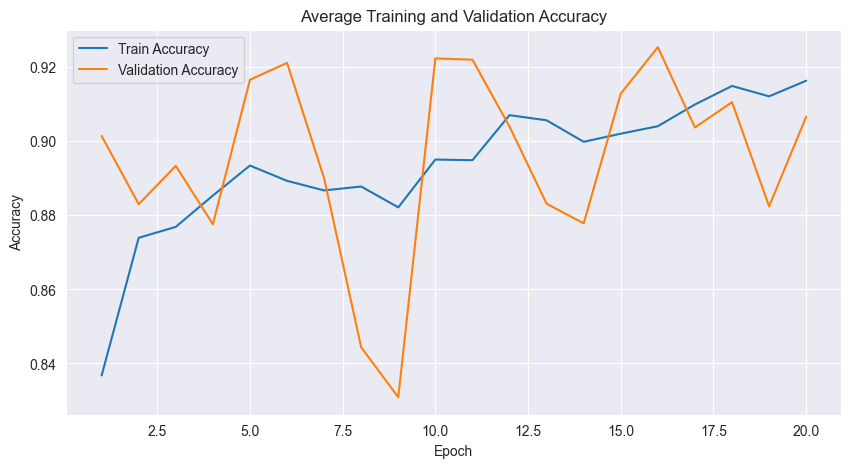

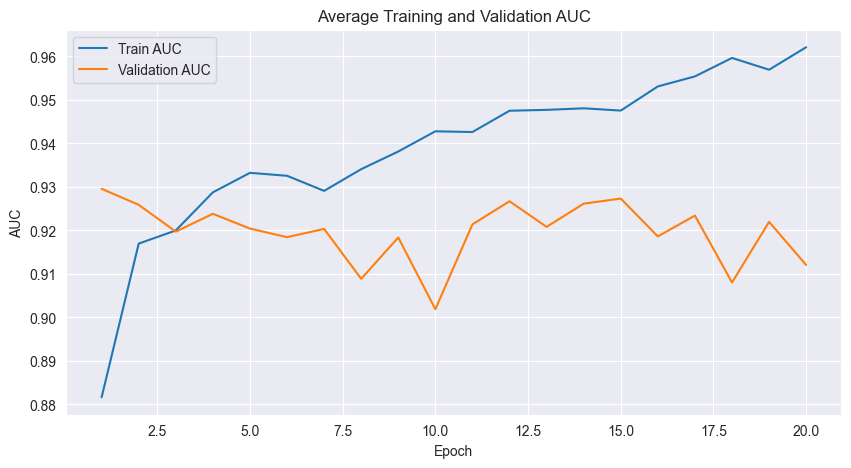

In [33]:
train_and_evaluate_cv(dataset,model,criterion,optim,num_epoch,device,'resnet_Itt_1',weight_decay= 1e-4,n_splits=5)

### Training with no data Augmentation with EfficientNet B0

In [35]:
from efficientnet_pytorch import EfficientNet


model_b0 = EfficientNet.from_pretrained('efficientnet-b0')
in_features = model_b0._fc.in_features
model_b0._fc = nn.Linear(in_features, 1)
print(device)
model_b0.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
num_epoch = 20


Loaded pretrained weights for efficientnet-b0
mps


Fold 1/5


Epoch 1/20
Train Loss: 1.0663 | Train ROC-AUC: 0.5128 | Train Accuracy: 0.5722
Validation Loss: 0.3144 | Validation ROC-AUC: 0.4555 | Validation Accuracy: 0.8190


Epoch 2/20
Train Loss: 1.0651 | Train ROC-AUC: 0.5218 | Train Accuracy: 0.5690
Validation Loss: 0.2731 | Validation ROC-AUC: 0.3692 | Validation Accuracy: 0.7787


Epoch 3/20
Train Loss: 1.0562 | Train ROC-AUC: 0.5596 | Train Accuracy: 0.5737
Validation Loss: 0.2717 | Validation ROC-AUC: 0.4199 | Validation Accuracy: 0.5881


Epoch 4/20
Train Loss: 1.0670 | Train ROC-AUC: 0.5211 | Train Accuracy: 0.5755
Validation Loss: 0.2691 | Validation ROC-AUC: 0.4787 | Validation Accuracy: 0.5550


Epoch 5/20
Train Loss: 1.0702 | Train ROC-AUC: 0.4999 | Train Accuracy: 0.5704
Validation Loss: 0.2687 | Validation ROC-AUC: 0.4886 | Validation Accuracy: 0.5442


Epoch 6/20
Train Loss: 1.0699 | Train ROC-AUC: 0.5059 | Train Accuracy: 0.5660
Validation Loss: 0.2687 | Validation ROC-AUC: 0.4881 | Validation Accuracy: 0.5358


Epoch 7/20
Train Loss: 1.0634 | Train ROC-AUC: 0.5276 | Train Accuracy: 0.5624
Validation Loss: 0.2686 | Validation ROC-AUC: 0.4921 | Validation Accuracy: 0.5442


Epoch 8/20
Train Loss: 1.0615 | Train ROC-AUC: 0.5346 | Train Accuracy: 0.5719
Validation Loss: 0.2686 | Validation ROC-AUC: 0.4920 | Validation Accuracy: 0.5502


Epoch 9/20
Train Loss: 1.0601 | Train ROC-AUC: 0.5431 | Train Accuracy: 0.5768
Validation Loss: 0.2686 | Validation ROC-AUC: 0.4919 | Validation Accuracy: 0.5454


Epoch 10/20
Train Loss: 1.0718 | Train ROC-AUC: 0.4961 | Train Accuracy: 0.5690
Validation Loss: 0.2686 | Validation ROC-AUC: 0.4906 | Validation Accuracy: 0.5406


Epoch 11/20
Train Loss: 1.0688 | Train ROC-AUC: 0.5094 | Train Accuracy: 0.5654
Validation Loss: 0.2685 | Validation ROC-AUC: 0.4924 | Validation Accuracy: 0.5430


Epoch 12/20
Train Loss: 1.0601 | Train ROC-AUC: 0.5528 | Train Accuracy: 0.5818
Validation Loss: 0.2686 | Validation ROC-AUC: 0.4918 | Validation Accuracy: 0.5508


Epoch 13/20
Train Loss: 1.0686 | Train ROC-AUC: 0.5096 | Train Accuracy: 0.5717
Validation Loss: 0.2686 | Validation ROC-AUC: 0.4912 | Validation Accuracy: 0.5484


Epoch 14/20
Train Loss: 1.0614 | Train ROC-AUC: 0.5385 | Train Accuracy: 0.5777
Validation Loss: 0.2686 | Validation ROC-AUC: 0.4905 | Validation Accuracy: 0.5472


Epoch 15/20
Train Loss: 1.0651 | Train ROC-AUC: 0.5183 | Train Accuracy: 0.5696
Validation Loss: 0.2687 | Validation ROC-AUC: 0.4896 | Validation Accuracy: 0.5478


Epoch 16/20
Train Loss: 1.0691 | Train ROC-AUC: 0.5123 | Train Accuracy: 0.5707
Validation Loss: 0.2686 | Validation ROC-AUC: 0.4925 | Validation Accuracy: 0.5412


Epoch 17/20
Train Loss: 1.0705 | Train ROC-AUC: 0.4953 | Train Accuracy: 0.5732
Validation Loss: 0.2686 | Validation ROC-AUC: 0.4915 | Validation Accuracy: 0.5478


Epoch 18/20
Train Loss: 1.0616 | Train ROC-AUC: 0.5293 | Train Accuracy: 0.5744
Validation Loss: 0.2687 | Validation ROC-AUC: 0.4906 | Validation Accuracy: 0.5388


Epoch 19/20
Train Loss: 1.0652 | Train ROC-AUC: 0.5194 | Train Accuracy: 0.5693
Validation Loss: 0.2686 | Validation ROC-AUC: 0.4912 | Validation Accuracy: 0.5430


Epoch 20/20
Train Loss: 1.0620 | Train ROC-AUC: 0.5286 | Train Accuracy: 0.5687
Validation Loss: 0.2686 | Validation ROC-AUC: 0.4919 | Validation Accuracy: 0.5424


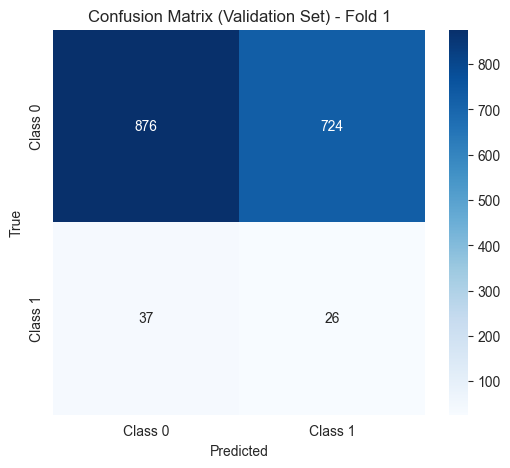

Fold 2/5


Epoch 1/20
Train Loss: 1.0707 | Train ROC-AUC: 0.4953 | Train Accuracy: 0.5618
Validation Loss: 0.2677 | Validation ROC-AUC: 0.5047 | Validation Accuracy: 0.5340


Epoch 2/20
Train Loss: 1.0600 | Train ROC-AUC: 0.5385 | Train Accuracy: 0.5731
Validation Loss: 0.2679 | Validation ROC-AUC: 0.5013 | Validation Accuracy: 0.5346


Epoch 3/20
Train Loss: 1.0631 | Train ROC-AUC: 0.5347 | Train Accuracy: 0.5755
Validation Loss: 0.2679 | Validation ROC-AUC: 0.5016 | Validation Accuracy: 0.5346


Epoch 4/20
Train Loss: 1.0646 | Train ROC-AUC: 0.5178 | Train Accuracy: 0.5648
Validation Loss: 0.2679 | Validation ROC-AUC: 0.5019 | Validation Accuracy: 0.5406


Epoch 5/20
Train Loss: 1.0672 | Train ROC-AUC: 0.5083 | Train Accuracy: 0.5683
Validation Loss: 0.2677 | Validation ROC-AUC: 0.5066 | Validation Accuracy: 0.5400


Epoch 6/20
Train Loss: 1.0680 | Train ROC-AUC: 0.5160 | Train Accuracy: 0.5672
Validation Loss: 0.2677 | Validation ROC-AUC: 0.5052 | Validation Accuracy: 0.5328


Epoch 7/20
Train Loss: 1.0703 | Train ROC-AUC: 0.5001 | Train Accuracy: 0.5680
Validation Loss: 0.2677 | Validation ROC-AUC: 0.5059 | Validation Accuracy: 0.5322


Epoch 8/20
Train Loss: 1.0728 | Train ROC-AUC: 0.4829 | Train Accuracy: 0.5668
Validation Loss: 0.2677 | Validation ROC-AUC: 0.5043 | Validation Accuracy: 0.5322


Epoch 9/20
Train Loss: 1.0667 | Train ROC-AUC: 0.5123 | Train Accuracy: 0.5689
Validation Loss: 0.2679 | Validation ROC-AUC: 0.5008 | Validation Accuracy: 0.5286


Epoch 10/20
Train Loss: 1.0666 | Train ROC-AUC: 0.5197 | Train Accuracy: 0.5741
Validation Loss: 0.2678 | Validation ROC-AUC: 0.5046 | Validation Accuracy: 0.5424


Epoch 11/20
Train Loss: 1.0627 | Train ROC-AUC: 0.5398 | Train Accuracy: 0.5720
Validation Loss: 0.2679 | Validation ROC-AUC: 0.5024 | Validation Accuracy: 0.5358


Epoch 12/20
Train Loss: 1.0670 | Train ROC-AUC: 0.5077 | Train Accuracy: 0.5677
Validation Loss: 0.2678 | Validation ROC-AUC: 0.5035 | Validation Accuracy: 0.5292


Epoch 13/20
Train Loss: 1.0702 | Train ROC-AUC: 0.4956 | Train Accuracy: 0.5687
Validation Loss: 0.2678 | Validation ROC-AUC: 0.5020 | Validation Accuracy: 0.5376


Epoch 14/20
Train Loss: 1.0709 | Train ROC-AUC: 0.4963 | Train Accuracy: 0.5789
Validation Loss: 0.2678 | Validation ROC-AUC: 0.5045 | Validation Accuracy: 0.5352


Epoch 15/20
Train Loss: 1.0669 | Train ROC-AUC: 0.5172 | Train Accuracy: 0.5723
Validation Loss: 0.2675 | Validation ROC-AUC: 0.5061 | Validation Accuracy: 0.5334


Epoch 16/20
Train Loss: 1.0701 | Train ROC-AUC: 0.5017 | Train Accuracy: 0.5660
Validation Loss: 0.2678 | Validation ROC-AUC: 0.5035 | Validation Accuracy: 0.5370


Epoch 17/20
Train Loss: 1.0655 | Train ROC-AUC: 0.5186 | Train Accuracy: 0.5633
Validation Loss: 0.2678 | Validation ROC-AUC: 0.5036 | Validation Accuracy: 0.5352


Epoch 18/20
Train Loss: 1.0661 | Train ROC-AUC: 0.5168 | Train Accuracy: 0.5674
Validation Loss: 0.2678 | Validation ROC-AUC: 0.5037 | Validation Accuracy: 0.5364


Epoch 19/20
Train Loss: 1.0634 | Train ROC-AUC: 0.5310 | Train Accuracy: 0.5734
Validation Loss: 0.2677 | Validation ROC-AUC: 0.5032 | Validation Accuracy: 0.5340


Epoch 20/20
Train Loss: 1.0641 | Train ROC-AUC: 0.5256 | Train Accuracy: 0.5699
Validation Loss: 0.2673 | Validation ROC-AUC: 0.5084 | Validation Accuracy: 0.5394


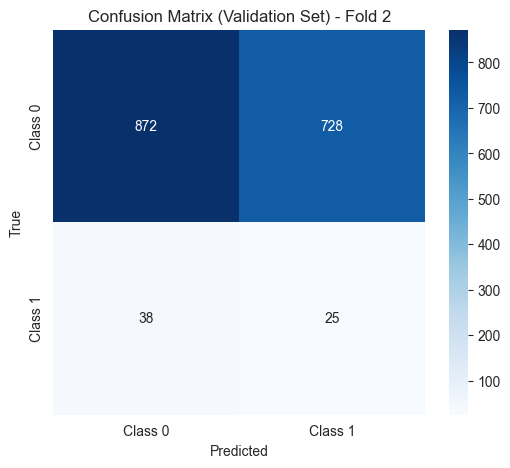

Fold 3/5


Epoch 1/20
Train Loss: 1.0654 | Train ROC-AUC: 0.5225 | Train Accuracy: 0.5594
Validation Loss: 0.2647 | Validation ROC-AUC: 0.5419 | Validation Accuracy: 0.5689


Epoch 2/20
Train Loss: 1.0709 | Train ROC-AUC: 0.5023 | Train Accuracy: 0.5684
Validation Loss: 0.2648 | Validation ROC-AUC: 0.5407 | Validation Accuracy: 0.5616


Epoch 3/20
Train Loss: 1.0698 | Train ROC-AUC: 0.5089 | Train Accuracy: 0.5612
Validation Loss: 0.2648 | Validation ROC-AUC: 0.5423 | Validation Accuracy: 0.5616


Epoch 4/20
Train Loss: 1.0631 | Train ROC-AUC: 0.5252 | Train Accuracy: 0.5576
Validation Loss: 0.2647 | Validation ROC-AUC: 0.5430 | Validation Accuracy: 0.5689


Epoch 5/20
Train Loss: 1.0648 | Train ROC-AUC: 0.5240 | Train Accuracy: 0.5716
Validation Loss: 0.2648 | Validation ROC-AUC: 0.5413 | Validation Accuracy: 0.5689


Epoch 6/20
Train Loss: 1.0727 | Train ROC-AUC: 0.4911 | Train Accuracy: 0.5609
Validation Loss: 0.2648 | Validation ROC-AUC: 0.5410 | Validation Accuracy: 0.5610


Epoch 7/20
Train Loss: 1.0704 | Train ROC-AUC: 0.5085 | Train Accuracy: 0.5695
Validation Loss: 0.2645 | Validation ROC-AUC: 0.5440 | Validation Accuracy: 0.5670


Epoch 8/20
Train Loss: 1.0716 | Train ROC-AUC: 0.4927 | Train Accuracy: 0.5662
Validation Loss: 0.2646 | Validation ROC-AUC: 0.5425 | Validation Accuracy: 0.5707


Epoch 9/20
Train Loss: 1.0672 | Train ROC-AUC: 0.5165 | Train Accuracy: 0.5687
Validation Loss: 0.2646 | Validation ROC-AUC: 0.5425 | Validation Accuracy: 0.5556


Epoch 10/20
Train Loss: 1.0723 | Train ROC-AUC: 0.4900 | Train Accuracy: 0.5677
Validation Loss: 0.2648 | Validation ROC-AUC: 0.5416 | Validation Accuracy: 0.5664


Epoch 11/20
Train Loss: 1.0707 | Train ROC-AUC: 0.4987 | Train Accuracy: 0.5678
Validation Loss: 0.2648 | Validation ROC-AUC: 0.5416 | Validation Accuracy: 0.5683


Epoch 12/20
Train Loss: 1.0722 | Train ROC-AUC: 0.4892 | Train Accuracy: 0.5660
Validation Loss: 0.2648 | Validation ROC-AUC: 0.5409 | Validation Accuracy: 0.5695


Epoch 13/20
Train Loss: 1.0703 | Train ROC-AUC: 0.4995 | Train Accuracy: 0.5642
Validation Loss: 0.2647 | Validation ROC-AUC: 0.5416 | Validation Accuracy: 0.5634


Epoch 14/20
Train Loss: 1.0698 | Train ROC-AUC: 0.5026 | Train Accuracy: 0.5653
Validation Loss: 0.2645 | Validation ROC-AUC: 0.5439 | Validation Accuracy: 0.5652


Epoch 15/20
Train Loss: 1.0675 | Train ROC-AUC: 0.5108 | Train Accuracy: 0.5609
Validation Loss: 0.2647 | Validation ROC-AUC: 0.5407 | Validation Accuracy: 0.5743


Epoch 16/20
Train Loss: 1.0752 | Train ROC-AUC: 0.4764 | Train Accuracy: 0.5638
Validation Loss: 0.2647 | Validation ROC-AUC: 0.5414 | Validation Accuracy: 0.5640


Epoch 17/20
Train Loss: 1.0678 | Train ROC-AUC: 0.5111 | Train Accuracy: 0.5662
Validation Loss: 0.2645 | Validation ROC-AUC: 0.5442 | Validation Accuracy: 0.5604


Epoch 18/20
Train Loss: 1.0647 | Train ROC-AUC: 0.5252 | Train Accuracy: 0.5734
Validation Loss: 0.2647 | Validation ROC-AUC: 0.5429 | Validation Accuracy: 0.5634


Epoch 19/20
Train Loss: 1.0683 | Train ROC-AUC: 0.5066 | Train Accuracy: 0.5743
Validation Loss: 0.2648 | Validation ROC-AUC: 0.5426 | Validation Accuracy: 0.5646


Epoch 20/20
Train Loss: 1.0711 | Train ROC-AUC: 0.4944 | Train Accuracy: 0.5641
Validation Loss: 0.2648 | Validation ROC-AUC: 0.5410 | Validation Accuracy: 0.5689


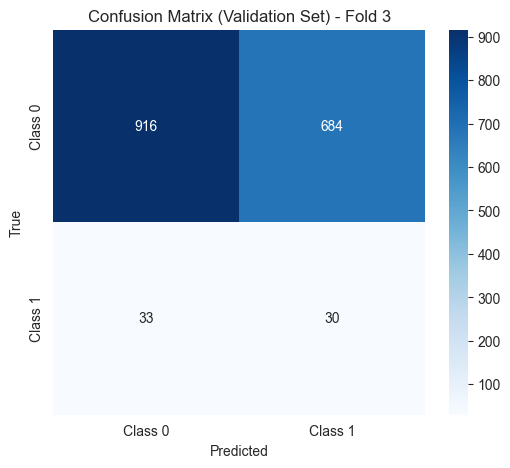

Fold 4/5


Epoch 1/20
Train Loss: 1.0746 | Train ROC-AUC: 0.5026 | Train Accuracy: 0.5644
Validation Loss: 0.2651 | Validation ROC-AUC: 0.5054 | Validation Accuracy: 0.5692


Epoch 2/20
Train Loss: 1.0675 | Train ROC-AUC: 0.5199 | Train Accuracy: 0.5698
Validation Loss: 0.2651 | Validation ROC-AUC: 0.5037 | Validation Accuracy: 0.5620


Epoch 3/20
Train Loss: 1.0688 | Train ROC-AUC: 0.5125 | Train Accuracy: 0.5665
Validation Loss: 0.2652 | Validation ROC-AUC: 0.4994 | Validation Accuracy: 0.5650


Epoch 4/20
Train Loss: 1.0677 | Train ROC-AUC: 0.5252 | Train Accuracy: 0.5692
Validation Loss: 0.2650 | Validation ROC-AUC: 0.5054 | Validation Accuracy: 0.5632


Epoch 5/20
Train Loss: 1.0732 | Train ROC-AUC: 0.4964 | Train Accuracy: 0.5646
Validation Loss: 0.2649 | Validation ROC-AUC: 0.5073 | Validation Accuracy: 0.5680


Epoch 6/20
Train Loss: 1.0712 | Train ROC-AUC: 0.5026 | Train Accuracy: 0.5743
Validation Loss: 0.2649 | Validation ROC-AUC: 0.5082 | Validation Accuracy: 0.5692


Epoch 7/20
Train Loss: 1.0672 | Train ROC-AUC: 0.5219 | Train Accuracy: 0.5671
Validation Loss: 0.2653 | Validation ROC-AUC: 0.4979 | Validation Accuracy: 0.5692


Epoch 8/20
Train Loss: 1.0695 | Train ROC-AUC: 0.5168 | Train Accuracy: 0.5700
Validation Loss: 0.2651 | Validation ROC-AUC: 0.5026 | Validation Accuracy: 0.5620


Epoch 9/20
Train Loss: 1.0682 | Train ROC-AUC: 0.5122 | Train Accuracy: 0.5613
Validation Loss: 0.2651 | Validation ROC-AUC: 0.5012 | Validation Accuracy: 0.5596


Epoch 10/20
Train Loss: 1.0691 | Train ROC-AUC: 0.5102 | Train Accuracy: 0.5703
Validation Loss: 0.2651 | Validation ROC-AUC: 0.5046 | Validation Accuracy: 0.5704


Epoch 11/20
Train Loss: 1.0671 | Train ROC-AUC: 0.5179 | Train Accuracy: 0.5698
Validation Loss: 0.2649 | Validation ROC-AUC: 0.5083 | Validation Accuracy: 0.5686


Epoch 12/20
Train Loss: 1.0777 | Train ROC-AUC: 0.4794 | Train Accuracy: 0.5722
Validation Loss: 0.2652 | Validation ROC-AUC: 0.5007 | Validation Accuracy: 0.5668


Epoch 13/20
Train Loss: 1.0686 | Train ROC-AUC: 0.5069 | Train Accuracy: 0.5649
Validation Loss: 0.2651 | Validation ROC-AUC: 0.5030 | Validation Accuracy: 0.5680


Epoch 14/20
Train Loss: 1.0682 | Train ROC-AUC: 0.5187 | Train Accuracy: 0.5754
Validation Loss: 0.2651 | Validation ROC-AUC: 0.5018 | Validation Accuracy: 0.5632


Epoch 15/20
Train Loss: 1.0641 | Train ROC-AUC: 0.5327 | Train Accuracy: 0.5810
Validation Loss: 0.2652 | Validation ROC-AUC: 0.5001 | Validation Accuracy: 0.5602


Epoch 16/20
Train Loss: 1.0647 | Train ROC-AUC: 0.5323 | Train Accuracy: 0.5686
Validation Loss: 0.2651 | Validation ROC-AUC: 0.5040 | Validation Accuracy: 0.5620


Epoch 17/20
Train Loss: 1.0686 | Train ROC-AUC: 0.5141 | Train Accuracy: 0.5547
Validation Loss: 0.2651 | Validation ROC-AUC: 0.5028 | Validation Accuracy: 0.5596


Epoch 18/20
Train Loss: 1.0696 | Train ROC-AUC: 0.5180 | Train Accuracy: 0.5695
Validation Loss: 0.2653 | Validation ROC-AUC: 0.4998 | Validation Accuracy: 0.5614


Epoch 19/20
Train Loss: 1.0651 | Train ROC-AUC: 0.5330 | Train Accuracy: 0.5811
Validation Loss: 0.2650 | Validation ROC-AUC: 0.5054 | Validation Accuracy: 0.5680


Epoch 20/20
Train Loss: 1.0637 | Train ROC-AUC: 0.5403 | Train Accuracy: 0.5706
Validation Loss: 0.2652 | Validation ROC-AUC: 0.5009 | Validation Accuracy: 0.5656


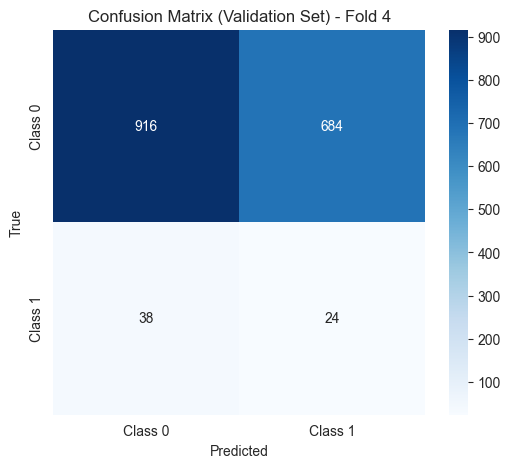

Fold 5/5


Epoch 1/20
Train Loss: 1.0611 | Train ROC-AUC: 0.5338 | Train Accuracy: 0.5635
Validation Loss: 0.2670 | Validation ROC-AUC: 0.5109 | Validation Accuracy: 0.5517


Epoch 2/20
Train Loss: 1.0748 | Train ROC-AUC: 0.4894 | Train Accuracy: 0.5712
Validation Loss: 0.2670 | Validation ROC-AUC: 0.5101 | Validation Accuracy: 0.5535


Epoch 3/20
Train Loss: 1.0652 | Train ROC-AUC: 0.5212 | Train Accuracy: 0.5706
Validation Loss: 0.2671 | Validation ROC-AUC: 0.5091 | Validation Accuracy: 0.5535


Epoch 4/20
Train Loss: 1.0650 | Train ROC-AUC: 0.5166 | Train Accuracy: 0.5691
Validation Loss: 0.2671 | Validation ROC-AUC: 0.5103 | Validation Accuracy: 0.5608


Epoch 5/20
Train Loss: 1.0664 | Train ROC-AUC: 0.5176 | Train Accuracy: 0.5662
Validation Loss: 0.2673 | Validation ROC-AUC: 0.5059 | Validation Accuracy: 0.5596


Epoch 6/20
Train Loss: 1.0705 | Train ROC-AUC: 0.5041 | Train Accuracy: 0.5665
Validation Loss: 0.2670 | Validation ROC-AUC: 0.5118 | Validation Accuracy: 0.5554


Epoch 7/20
Train Loss: 1.0688 | Train ROC-AUC: 0.5091 | Train Accuracy: 0.5668
Validation Loss: 0.2671 | Validation ROC-AUC: 0.5095 | Validation Accuracy: 0.5602


Epoch 8/20
Train Loss: 1.0643 | Train ROC-AUC: 0.5276 | Train Accuracy: 0.5730
Validation Loss: 0.2671 | Validation ROC-AUC: 0.5081 | Validation Accuracy: 0.5548


Epoch 9/20
Train Loss: 1.0658 | Train ROC-AUC: 0.5183 | Train Accuracy: 0.5661
Validation Loss: 0.2669 | Validation ROC-AUC: 0.5122 | Validation Accuracy: 0.5529


Epoch 10/20
Train Loss: 1.0638 | Train ROC-AUC: 0.5205 | Train Accuracy: 0.5748
Validation Loss: 0.2669 | Validation ROC-AUC: 0.5137 | Validation Accuracy: 0.5722


Epoch 11/20
Train Loss: 1.0649 | Train ROC-AUC: 0.5264 | Train Accuracy: 0.5692
Validation Loss: 0.2670 | Validation ROC-AUC: 0.5112 | Validation Accuracy: 0.5578


Epoch 12/20
Train Loss: 1.0658 | Train ROC-AUC: 0.5122 | Train Accuracy: 0.5704
Validation Loss: 0.2671 | Validation ROC-AUC: 0.5095 | Validation Accuracy: 0.5590


Epoch 13/20
Train Loss: 1.0634 | Train ROC-AUC: 0.5236 | Train Accuracy: 0.5671
Validation Loss: 0.2669 | Validation ROC-AUC: 0.5128 | Validation Accuracy: 0.5572


Epoch 14/20
Train Loss: 1.0631 | Train ROC-AUC: 0.5330 | Train Accuracy: 0.5747
Validation Loss: 0.2670 | Validation ROC-AUC: 0.5115 | Validation Accuracy: 0.5596


Epoch 15/20
Train Loss: 1.0672 | Train ROC-AUC: 0.5141 | Train Accuracy: 0.5716
Validation Loss: 0.2671 | Validation ROC-AUC: 0.5100 | Validation Accuracy: 0.5650


Epoch 16/20
Train Loss: 1.0663 | Train ROC-AUC: 0.5179 | Train Accuracy: 0.5689
Validation Loss: 0.2670 | Validation ROC-AUC: 0.5114 | Validation Accuracy: 0.5602


Epoch 17/20
Train Loss: 1.0650 | Train ROC-AUC: 0.5186 | Train Accuracy: 0.5751
Validation Loss: 0.2670 | Validation ROC-AUC: 0.5121 | Validation Accuracy: 0.5602


Epoch 18/20
Train Loss: 1.0674 | Train ROC-AUC: 0.5131 | Train Accuracy: 0.5724
Validation Loss: 0.2670 | Validation ROC-AUC: 0.5114 | Validation Accuracy: 0.5602


Epoch 19/20
Train Loss: 1.0625 | Train ROC-AUC: 0.5357 | Train Accuracy: 0.5724
Validation Loss: 0.2672 | Validation ROC-AUC: 0.5088 | Validation Accuracy: 0.5572


Epoch 20/20
Train Loss: 1.0672 | Train ROC-AUC: 0.5143 | Train Accuracy: 0.5728
Validation Loss: 0.2670 | Validation ROC-AUC: 0.5118 | Validation Accuracy: 0.5578


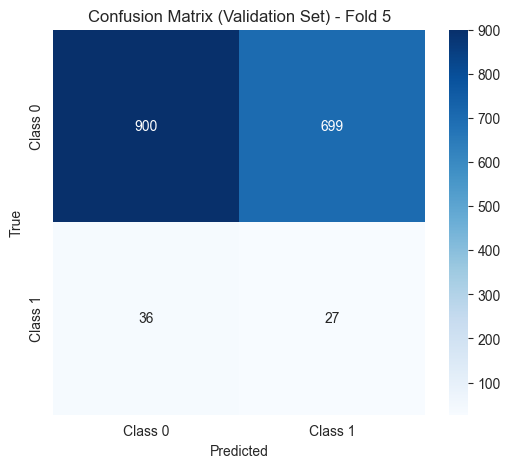

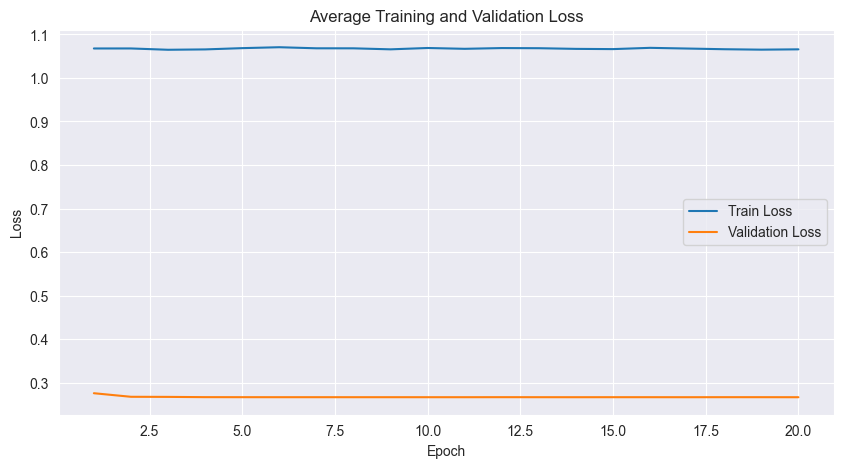

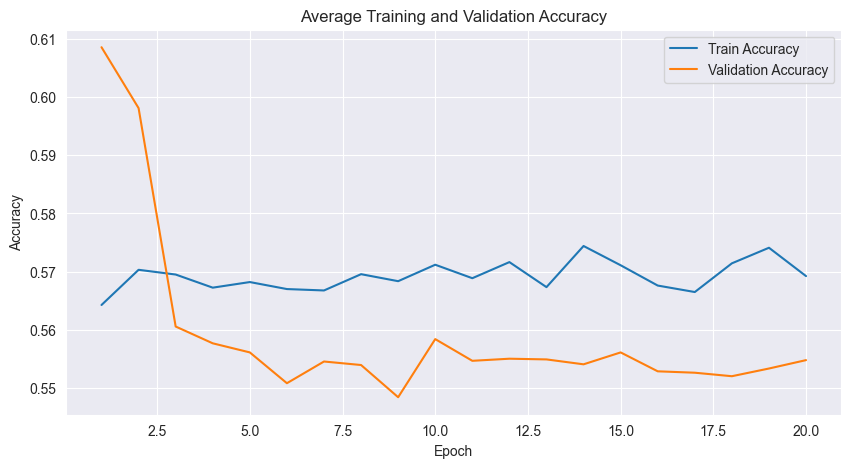

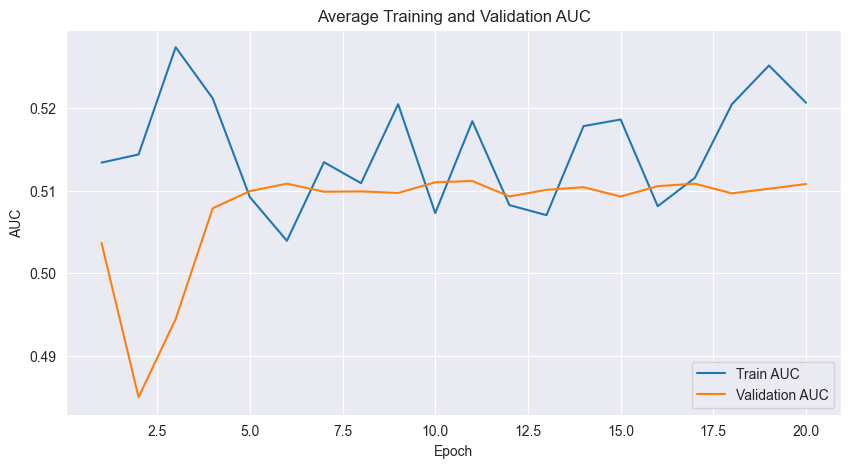

In [36]:
train_and_evaluate_cv(dataset,model_b0,criterion,optim,num_epoch,device,'effnet_Itt_1',weight_decay= 1e-4,n_splits=5)

Fold 1/5


Epoch 1/20
Train Loss: 0.4442 | Train ROC-AUC: 0.9511 | Train Accuracy: 0.9024
Validation Loss: 0.1180 | Validation ROC-AUC: 0.9557 | Validation Accuracy: 0.8202


Epoch 2/20
Train Loss: 0.4148 | Train ROC-AUC: 0.9558 | Train Accuracy: 0.8797
Validation Loss: 0.1154 | Validation ROC-AUC: 0.9489 | Validation Accuracy: 0.8882


Epoch 3/20
Train Loss: 0.4021 | Train ROC-AUC: 0.9573 | Train Accuracy: 0.8892
Validation Loss: 0.1059 | Validation ROC-AUC: 0.9632 | Validation Accuracy: 0.9254


Epoch 4/20
Train Loss: 0.4079 | Train ROC-AUC: 0.9577 | Train Accuracy: 0.8995
Validation Loss: 0.1321 | Validation ROC-AUC: 0.9334 | Validation Accuracy: 0.8779


Epoch 5/20
Train Loss: 0.3615 | Train ROC-AUC: 0.9662 | Train Accuracy: 0.8931
Validation Loss: 0.1084 | Validation ROC-AUC: 0.9591 | Validation Accuracy: 0.9188


Epoch 6/20
Train Loss: 0.3735 | Train ROC-AUC: 0.9633 | Train Accuracy: 0.8956
Validation Loss: 0.1187 | Validation ROC-AUC: 0.9498 | Validation Accuracy: 0.8996


Epoch 7/20
Train Loss: 0.3457 | Train ROC-AUC: 0.9691 | Train Accuracy: 0.9036
Validation Loss: 0.1177 | Validation ROC-AUC: 0.9479 | Validation Accuracy: 0.8605


Epoch 8/20
Train Loss: 0.3592 | Train ROC-AUC: 0.9664 | Train Accuracy: 0.8989
Validation Loss: 0.1070 | Validation ROC-AUC: 0.9563 | Validation Accuracy: 0.8906


Epoch 9/20
Train Loss: 0.3269 | Train ROC-AUC: 0.9718 | Train Accuracy: 0.9077
Validation Loss: 0.1297 | Validation ROC-AUC: 0.9398 | Validation Accuracy: 0.9158


Epoch 10/20
Train Loss: 0.3758 | Train ROC-AUC: 0.9625 | Train Accuracy: 0.8874
Validation Loss: 0.1331 | Validation ROC-AUC: 0.9373 | Validation Accuracy: 0.8839


Epoch 11/20
Train Loss: 0.3162 | Train ROC-AUC: 0.9729 | Train Accuracy: 0.9164
Validation Loss: 0.1619 | Validation ROC-AUC: 0.9120 | Validation Accuracy: 0.9008


Epoch 12/20
Train Loss: 0.3588 | Train ROC-AUC: 0.9663 | Train Accuracy: 0.9008
Validation Loss: 0.1640 | Validation ROC-AUC: 0.9331 | Validation Accuracy: 0.9260


Epoch 13/20
Train Loss: 0.2818 | Train ROC-AUC: 0.9785 | Train Accuracy: 0.9198
Validation Loss: 0.1199 | Validation ROC-AUC: 0.9512 | Validation Accuracy: 0.9080


Epoch 14/20
Train Loss: 0.3153 | Train ROC-AUC: 0.9736 | Train Accuracy: 0.9128
Validation Loss: 0.1359 | Validation ROC-AUC: 0.9355 | Validation Accuracy: 0.8966


Epoch 15/20
Train Loss: 0.3128 | Train ROC-AUC: 0.9735 | Train Accuracy: 0.9125
Validation Loss: 0.1435 | Validation ROC-AUC: 0.9273 | Validation Accuracy: 0.8731


Epoch 16/20
Train Loss: 0.2821 | Train ROC-AUC: 0.9776 | Train Accuracy: 0.9192
Validation Loss: 0.1617 | Validation ROC-AUC: 0.9190 | Validation Accuracy: 0.9074


Epoch 17/20
Train Loss: 0.2566 | Train ROC-AUC: 0.9815 | Train Accuracy: 0.9244
Validation Loss: 0.1550 | Validation ROC-AUC: 0.9498 | Validation Accuracy: 0.9429


Epoch 18/20
Train Loss: 0.2641 | Train ROC-AUC: 0.9804 | Train Accuracy: 0.9238
Validation Loss: 0.1636 | Validation ROC-AUC: 0.9230 | Validation Accuracy: 0.8437


Epoch 19/20
Train Loss: 0.3158 | Train ROC-AUC: 0.9736 | Train Accuracy: 0.9123
Validation Loss: 0.1484 | Validation ROC-AUC: 0.9346 | Validation Accuracy: 0.8845


Epoch 20/20
Train Loss: 0.2928 | Train ROC-AUC: 0.9758 | Train Accuracy: 0.9144
Validation Loss: 0.1771 | Validation ROC-AUC: 0.9183 | Validation Accuracy: 0.9086


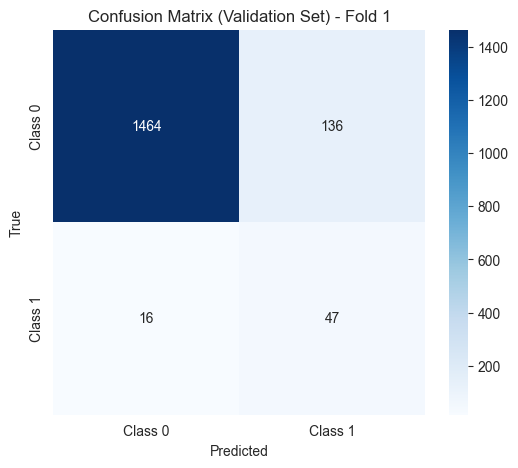

Fold 2/5


Epoch 1/20
Train Loss: 0.4074 | Train ROC-AUC: 0.9570 | Train Accuracy: 0.9003
Validation Loss: 0.0772 | Validation ROC-AUC: 0.9745 | Validation Accuracy: 0.9212


Epoch 2/20
Train Loss: 0.4061 | Train ROC-AUC: 0.9570 | Train Accuracy: 0.8842
Validation Loss: 0.0927 | Validation ROC-AUC: 0.9675 | Validation Accuracy: 0.8617


Epoch 3/20
Train Loss: 0.3497 | Train ROC-AUC: 0.9674 | Train Accuracy: 0.8944
Validation Loss: 0.0905 | Validation ROC-AUC: 0.9681 | Validation Accuracy: 0.9296


Epoch 4/20
Train Loss: 0.3537 | Train ROC-AUC: 0.9669 | Train Accuracy: 0.9042
Validation Loss: 0.0918 | Validation ROC-AUC: 0.9658 | Validation Accuracy: 0.8725


Epoch 5/20
Train Loss: 0.4046 | Train ROC-AUC: 0.9577 | Train Accuracy: 0.8847
Validation Loss: 0.0995 | Validation ROC-AUC: 0.9591 | Validation Accuracy: 0.8695


Epoch 6/20
Train Loss: 0.3115 | Train ROC-AUC: 0.9744 | Train Accuracy: 0.9021
Validation Loss: 0.1033 | Validation ROC-AUC: 0.9567 | Validation Accuracy: 0.9020


Epoch 7/20
Train Loss: 0.3239 | Train ROC-AUC: 0.9719 | Train Accuracy: 0.8995
Validation Loss: 0.0985 | Validation ROC-AUC: 0.9670 | Validation Accuracy: 0.9387


Epoch 8/20
Train Loss: 0.2522 | Train ROC-AUC: 0.9819 | Train Accuracy: 0.9238
Validation Loss: 0.0739 | Validation ROC-AUC: 0.9755 | Validation Accuracy: 0.9182


Epoch 9/20
Train Loss: 0.2957 | Train ROC-AUC: 0.9764 | Train Accuracy: 0.9206
Validation Loss: 0.1460 | Validation ROC-AUC: 0.9359 | Validation Accuracy: 0.8022


Epoch 10/20
Train Loss: 0.3250 | Train ROC-AUC: 0.9713 | Train Accuracy: 0.9095
Validation Loss: 0.1163 | Validation ROC-AUC: 0.9484 | Validation Accuracy: 0.8521


Epoch 11/20
Train Loss: 0.2673 | Train ROC-AUC: 0.9798 | Train Accuracy: 0.9209
Validation Loss: 0.0965 | Validation ROC-AUC: 0.9633 | Validation Accuracy: 0.9194


Epoch 12/20
Train Loss: 0.2600 | Train ROC-AUC: 0.9801 | Train Accuracy: 0.9262
Validation Loss: 0.1468 | Validation ROC-AUC: 0.9460 | Validation Accuracy: 0.9405


Epoch 13/20
Train Loss: 0.3242 | Train ROC-AUC: 0.9716 | Train Accuracy: 0.9090
Validation Loss: 0.1076 | Validation ROC-AUC: 0.9633 | Validation Accuracy: 0.9423


Epoch 14/20
Train Loss: 0.2894 | Train ROC-AUC: 0.9766 | Train Accuracy: 0.9182
Validation Loss: 0.1146 | Validation ROC-AUC: 0.9466 | Validation Accuracy: 0.8569


Epoch 15/20
Train Loss: 0.2430 | Train ROC-AUC: 0.9829 | Train Accuracy: 0.9275
Validation Loss: 0.0975 | Validation ROC-AUC: 0.9647 | Validation Accuracy: 0.9116


Epoch 16/20
Train Loss: 0.2504 | Train ROC-AUC: 0.9813 | Train Accuracy: 0.9298
Validation Loss: 0.2520 | Validation ROC-AUC: 0.8968 | Validation Accuracy: 0.9302


Epoch 17/20
Train Loss: 0.3152 | Train ROC-AUC: 0.9735 | Train Accuracy: 0.9045
Validation Loss: 0.1132 | Validation ROC-AUC: 0.9551 | Validation Accuracy: 0.9230


Epoch 18/20
Train Loss: 0.2372 | Train ROC-AUC: 0.9839 | Train Accuracy: 0.9332
Validation Loss: 0.1066 | Validation ROC-AUC: 0.9563 | Validation Accuracy: 0.8870


Epoch 19/20
Train Loss: 0.2955 | Train ROC-AUC: 0.9762 | Train Accuracy: 0.9211
Validation Loss: 0.1226 | Validation ROC-AUC: 0.9524 | Validation Accuracy: 0.9092


Epoch 20/20
Train Loss: 0.2345 | Train ROC-AUC: 0.9834 | Train Accuracy: 0.9334
Validation Loss: 0.1258 | Validation ROC-AUC: 0.9465 | Validation Accuracy: 0.9074


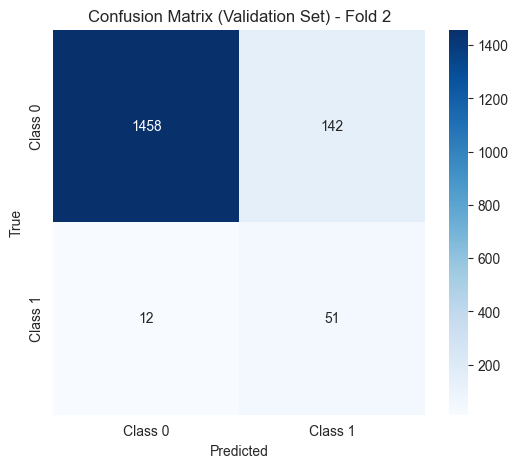

Fold 3/5


Epoch 1/20
Train Loss: 0.3461 | Train ROC-AUC: 0.9696 | Train Accuracy: 0.9087
Validation Loss: 0.0683 | Validation ROC-AUC: 0.9828 | Validation Accuracy: 0.8996


Epoch 2/20
Train Loss: 0.2957 | Train ROC-AUC: 0.9760 | Train Accuracy: 0.9215
Validation Loss: 0.0600 | Validation ROC-AUC: 0.9852 | Validation Accuracy: 0.9345


Epoch 3/20
Train Loss: 0.2855 | Train ROC-AUC: 0.9781 | Train Accuracy: 0.9192
Validation Loss: 0.0536 | Validation ROC-AUC: 0.9858 | Validation Accuracy: 0.9459


Epoch 4/20
Train Loss: 0.2403 | Train ROC-AUC: 0.9832 | Train Accuracy: 0.9340
Validation Loss: 0.0511 | Validation ROC-AUC: 0.9863 | Validation Accuracy: 0.9393


Epoch 5/20
Train Loss: 0.2733 | Train ROC-AUC: 0.9801 | Train Accuracy: 0.9217
Validation Loss: 0.0737 | Validation ROC-AUC: 0.9774 | Validation Accuracy: 0.9333


Epoch 6/20
Train Loss: 0.2708 | Train ROC-AUC: 0.9794 | Train Accuracy: 0.9186
Validation Loss: 0.0857 | Validation ROC-AUC: 0.9811 | Validation Accuracy: 0.9573


Epoch 7/20
Train Loss: 0.1862 | Train ROC-AUC: 0.9897 | Train Accuracy: 0.9438
Validation Loss: 0.0625 | Validation ROC-AUC: 0.9816 | Validation Accuracy: 0.9248


Epoch 8/20
Train Loss: 0.1712 | Train ROC-AUC: 0.9911 | Train Accuracy: 0.9484
Validation Loss: 0.0730 | Validation ROC-AUC: 0.9814 | Validation Accuracy: 0.9489


Epoch 9/20
Train Loss: 0.2299 | Train ROC-AUC: 0.9849 | Train Accuracy: 0.9343
Validation Loss: 0.1034 | Validation ROC-AUC: 0.9686 | Validation Accuracy: 0.9423


Epoch 10/20
Train Loss: 0.3411 | Train ROC-AUC: 0.9707 | Train Accuracy: 0.9171
Validation Loss: 0.0885 | Validation ROC-AUC: 0.9675 | Validation Accuracy: 0.9224


Epoch 11/20
Train Loss: 0.2568 | Train ROC-AUC: 0.9814 | Train Accuracy: 0.9281
Validation Loss: 0.0676 | Validation ROC-AUC: 0.9783 | Validation Accuracy: 0.9302


Epoch 12/20
Train Loss: 0.1807 | Train ROC-AUC: 0.9903 | Train Accuracy: 0.9442
Validation Loss: 0.0763 | Validation ROC-AUC: 0.9797 | Validation Accuracy: 0.9459


Epoch 13/20
Train Loss: 0.1759 | Train ROC-AUC: 0.9906 | Train Accuracy: 0.9481
Validation Loss: 0.1536 | Validation ROC-AUC: 0.9393 | Validation Accuracy: 0.9260


Epoch 14/20
Train Loss: 0.2556 | Train ROC-AUC: 0.9818 | Train Accuracy: 0.9296
Validation Loss: 0.1241 | Validation ROC-AUC: 0.9449 | Validation Accuracy: 0.8767


Epoch 15/20
Train Loss: 0.2390 | Train ROC-AUC: 0.9833 | Train Accuracy: 0.9295
Validation Loss: 0.0868 | Validation ROC-AUC: 0.9717 | Validation Accuracy: 0.9254


Epoch 16/20
Train Loss: 0.2155 | Train ROC-AUC: 0.9871 | Train Accuracy: 0.9420
Validation Loss: 0.1107 | Validation ROC-AUC: 0.9623 | Validation Accuracy: 0.9327


Epoch 17/20
Train Loss: 0.2054 | Train ROC-AUC: 0.9878 | Train Accuracy: 0.9395
Validation Loss: 0.1474 | Validation ROC-AUC: 0.9501 | Validation Accuracy: 0.9411


Epoch 18/20
Train Loss: 0.1984 | Train ROC-AUC: 0.9887 | Train Accuracy: 0.9447
Validation Loss: 0.1127 | Validation ROC-AUC: 0.9566 | Validation Accuracy: 0.9206


Epoch 19/20
Train Loss: 0.2190 | Train ROC-AUC: 0.9858 | Train Accuracy: 0.9317
Validation Loss: 0.1289 | Validation ROC-AUC: 0.9662 | Validation Accuracy: 0.9531


Epoch 20/20
Train Loss: 0.2041 | Train ROC-AUC: 0.9879 | Train Accuracy: 0.9453
Validation Loss: 0.1047 | Validation ROC-AUC: 0.9699 | Validation Accuracy: 0.9465


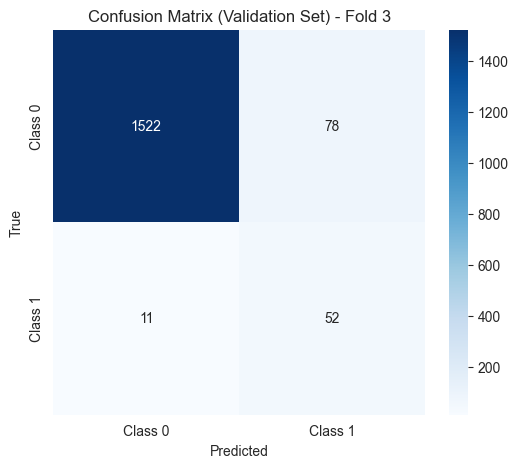

Fold 4/5


Epoch 1/20
Train Loss: 0.4006 | Train ROC-AUC: 0.9622 | Train Accuracy: 0.8993
Validation Loss: 0.0451 | Validation ROC-AUC: 0.9941 | Validation Accuracy: 0.9170


Epoch 2/20
Train Loss: 0.2496 | Train ROC-AUC: 0.9822 | Train Accuracy: 0.9320
Validation Loss: 0.0943 | Validation ROC-AUC: 0.9866 | Validation Accuracy: 0.8309


Epoch 3/20
Train Loss: 0.2093 | Train ROC-AUC: 0.9872 | Train Accuracy: 0.9366
Validation Loss: 0.0316 | Validation ROC-AUC: 0.9960 | Validation Accuracy: 0.9477


Epoch 4/20
Train Loss: 0.1815 | Train ROC-AUC: 0.9901 | Train Accuracy: 0.9462
Validation Loss: 0.0380 | Validation ROC-AUC: 0.9927 | Validation Accuracy: 0.9597


Epoch 5/20
Train Loss: 0.2153 | Train ROC-AUC: 0.9866 | Train Accuracy: 0.9420
Validation Loss: 0.0553 | Validation ROC-AUC: 0.9917 | Validation Accuracy: 0.9061


Epoch 6/20
Train Loss: 0.1781 | Train ROC-AUC: 0.9903 | Train Accuracy: 0.9438
Validation Loss: 0.0477 | Validation ROC-AUC: 0.9887 | Validation Accuracy: 0.9338


Epoch 7/20
Train Loss: 0.2140 | Train ROC-AUC: 0.9865 | Train Accuracy: 0.9384
Validation Loss: 0.0631 | Validation ROC-AUC: 0.9857 | Validation Accuracy: 0.9567


Epoch 8/20
Train Loss: 0.2109 | Train ROC-AUC: 0.9868 | Train Accuracy: 0.9382
Validation Loss: 0.0655 | Validation ROC-AUC: 0.9807 | Validation Accuracy: 0.9188


Epoch 9/20
Train Loss: 0.2104 | Train ROC-AUC: 0.9876 | Train Accuracy: 0.9384
Validation Loss: 0.0564 | Validation ROC-AUC: 0.9848 | Validation Accuracy: 0.9404


Epoch 10/20
Train Loss: 0.1717 | Train ROC-AUC: 0.9910 | Train Accuracy: 0.9492
Validation Loss: 0.0631 | Validation ROC-AUC: 0.9816 | Validation Accuracy: 0.9230


Epoch 11/20
Train Loss: 0.2067 | Train ROC-AUC: 0.9876 | Train Accuracy: 0.9471
Validation Loss: 0.1094 | Validation ROC-AUC: 0.9616 | Validation Accuracy: 0.8345


Epoch 12/20
Train Loss: 0.2218 | Train ROC-AUC: 0.9860 | Train Accuracy: 0.9305
Validation Loss: 0.0570 | Validation ROC-AUC: 0.9878 | Validation Accuracy: 0.9603


Epoch 13/20
Train Loss: 0.1943 | Train ROC-AUC: 0.9886 | Train Accuracy: 0.9456
Validation Loss: 0.0754 | Validation ROC-AUC: 0.9832 | Validation Accuracy: 0.9609


Epoch 14/20
Train Loss: 0.1872 | Train ROC-AUC: 0.9891 | Train Accuracy: 0.9478
Validation Loss: 0.0948 | Validation ROC-AUC: 0.9706 | Validation Accuracy: 0.9338


Epoch 15/20
Train Loss: 0.2231 | Train ROC-AUC: 0.9861 | Train Accuracy: 0.9400
Validation Loss: 0.0618 | Validation ROC-AUC: 0.9831 | Validation Accuracy: 0.9344


Epoch 16/20
Train Loss: 0.1650 | Train ROC-AUC: 0.9916 | Train Accuracy: 0.9513
Validation Loss: 0.0758 | Validation ROC-AUC: 0.9752 | Validation Accuracy: 0.9206


Epoch 17/20
Train Loss: 0.1511 | Train ROC-AUC: 0.9926 | Train Accuracy: 0.9587
Validation Loss: 0.0726 | Validation ROC-AUC: 0.9827 | Validation Accuracy: 0.8971


Epoch 18/20
Train Loss: 0.1643 | Train ROC-AUC: 0.9913 | Train Accuracy: 0.9565
Validation Loss: 0.0727 | Validation ROC-AUC: 0.9825 | Validation Accuracy: 0.9591


Epoch 19/20
Train Loss: 0.1517 | Train ROC-AUC: 0.9926 | Train Accuracy: 0.9575
Validation Loss: 0.0758 | Validation ROC-AUC: 0.9786 | Validation Accuracy: 0.9248


Epoch 20/20
Train Loss: 0.2193 | Train ROC-AUC: 0.9869 | Train Accuracy: 0.9444
Validation Loss: 0.0866 | Validation ROC-AUC: 0.9679 | Validation Accuracy: 0.9194


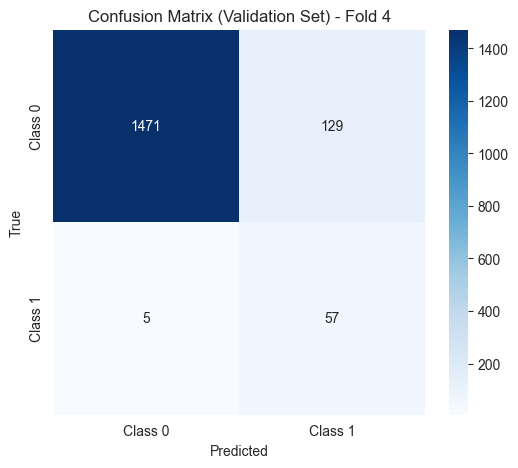

Fold 5/5


Epoch 1/20
Train Loss: 0.3124 | Train ROC-AUC: 0.9749 | Train Accuracy: 0.9119
Validation Loss: 0.0364 | Validation ROC-AUC: 0.9932 | Validation Accuracy: 0.9416


Epoch 2/20
Train Loss: 0.2012 | Train ROC-AUC: 0.9879 | Train Accuracy: 0.9436
Validation Loss: 0.0411 | Validation ROC-AUC: 0.9925 | Validation Accuracy: 0.9591


Epoch 3/20
Train Loss: 0.1939 | Train ROC-AUC: 0.9887 | Train Accuracy: 0.9435
Validation Loss: 0.0274 | Validation ROC-AUC: 0.9963 | Validation Accuracy: 0.9507


Epoch 4/20
Train Loss: 0.1624 | Train ROC-AUC: 0.9918 | Train Accuracy: 0.9526
Validation Loss: 0.0301 | Validation ROC-AUC: 0.9953 | Validation Accuracy: 0.9621


Epoch 5/20
Train Loss: 0.2027 | Train ROC-AUC: 0.9883 | Train Accuracy: 0.9421
Validation Loss: 0.0471 | Validation ROC-AUC: 0.9898 | Validation Accuracy: 0.9308


Epoch 6/20
Train Loss: 0.1882 | Train ROC-AUC: 0.9893 | Train Accuracy: 0.9444
Validation Loss: 0.0557 | Validation ROC-AUC: 0.9864 | Validation Accuracy: 0.9398


Epoch 7/20
Train Loss: 0.1960 | Train ROC-AUC: 0.9886 | Train Accuracy: 0.9394
Validation Loss: 0.0446 | Validation ROC-AUC: 0.9907 | Validation Accuracy: 0.9597


Epoch 8/20
Train Loss: 0.1481 | Train ROC-AUC: 0.9927 | Train Accuracy: 0.9578
Validation Loss: 0.0586 | Validation ROC-AUC: 0.9879 | Validation Accuracy: 0.9645


Epoch 9/20
Train Loss: 0.1304 | Train ROC-AUC: 0.9939 | Train Accuracy: 0.9636
Validation Loss: 0.0478 | Validation ROC-AUC: 0.9894 | Validation Accuracy: 0.9404


Epoch 10/20
Train Loss: 0.1275 | Train ROC-AUC: 0.9947 | Train Accuracy: 0.9623
Validation Loss: 0.0399 | Validation ROC-AUC: 0.9912 | Validation Accuracy: 0.9603


Epoch 11/20
Train Loss: 0.1192 | Train ROC-AUC: 0.9957 | Train Accuracy: 0.9642
Validation Loss: 0.0466 | Validation ROC-AUC: 0.9900 | Validation Accuracy: 0.9591


Epoch 12/20
Train Loss: 0.2727 | Train ROC-AUC: 0.9814 | Train Accuracy: 0.9329
Validation Loss: 0.0596 | Validation ROC-AUC: 0.9817 | Validation Accuracy: 0.9254


Epoch 13/20
Train Loss: 0.2481 | Train ROC-AUC: 0.9832 | Train Accuracy: 0.9299
Validation Loss: 0.0478 | Validation ROC-AUC: 0.9865 | Validation Accuracy: 0.9465


Epoch 14/20
Train Loss: 0.1418 | Train ROC-AUC: 0.9941 | Train Accuracy: 0.9562
Validation Loss: 0.0436 | Validation ROC-AUC: 0.9905 | Validation Accuracy: 0.9645


Epoch 15/20
Train Loss: 0.1015 | Train ROC-AUC: 0.9969 | Train Accuracy: 0.9692
Validation Loss: 0.0597 | Validation ROC-AUC: 0.9895 | Validation Accuracy: 0.9705


Epoch 16/20
Train Loss: 0.1309 | Train ROC-AUC: 0.9944 | Train Accuracy: 0.9602
Validation Loss: 0.0649 | Validation ROC-AUC: 0.9886 | Validation Accuracy: 0.9687


Epoch 17/20
Train Loss: 0.0829 | Train ROC-AUC: 0.9974 | Train Accuracy: 0.9735
Validation Loss: 0.0410 | Validation ROC-AUC: 0.9915 | Validation Accuracy: 0.9657


Epoch 18/20
Train Loss: 0.1127 | Train ROC-AUC: 0.9957 | Train Accuracy: 0.9705
Validation Loss: 0.0941 | Validation ROC-AUC: 0.9773 | Validation Accuracy: 0.9477


Epoch 19/20
Train Loss: 0.2543 | Train ROC-AUC: 0.9834 | Train Accuracy: 0.9314
Validation Loss: 0.0656 | Validation ROC-AUC: 0.9827 | Validation Accuracy: 0.9543


Epoch 20/20
Train Loss: 0.1879 | Train ROC-AUC: 0.9895 | Train Accuracy: 0.9490
Validation Loss: 0.0527 | Validation ROC-AUC: 0.9874 | Validation Accuracy: 0.9633


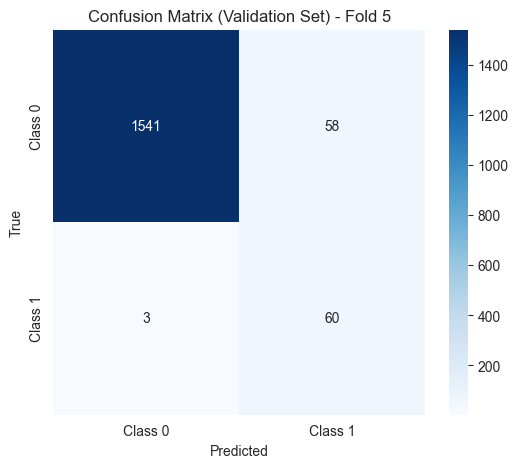

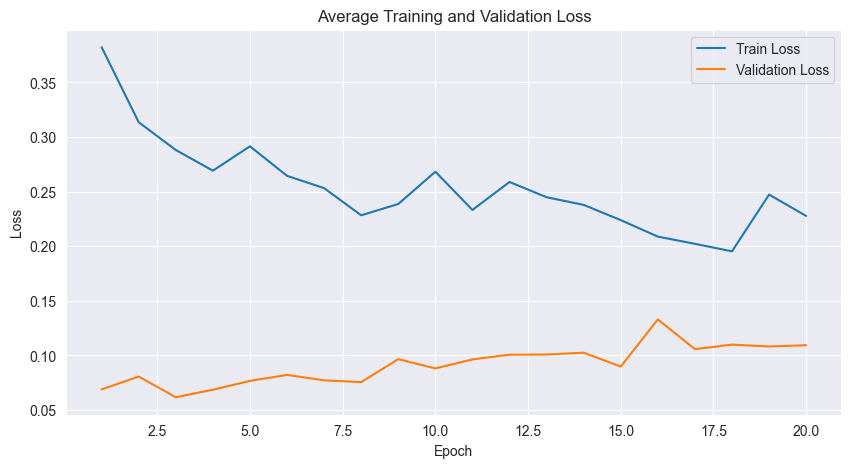

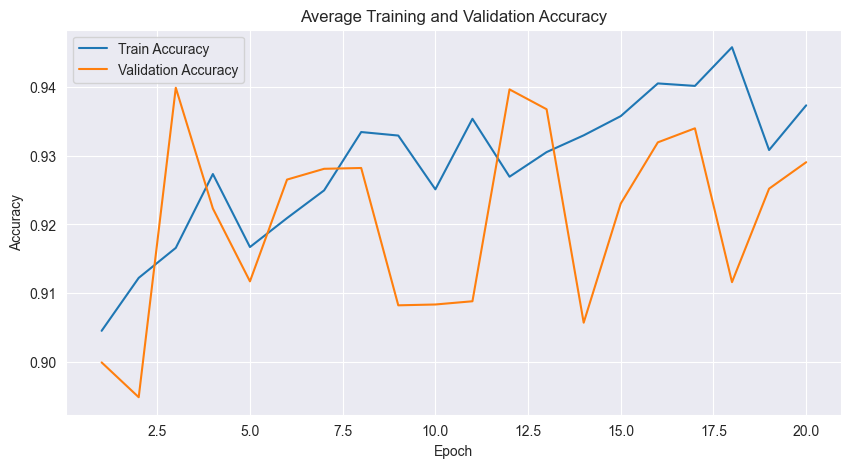

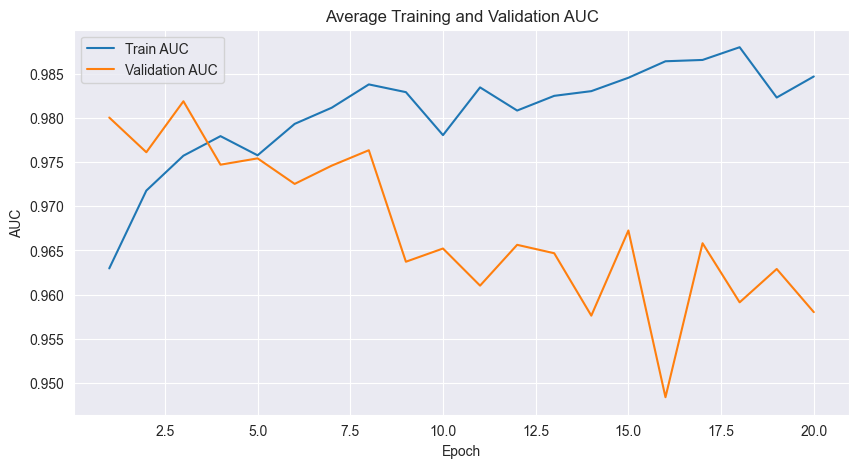

In [51]:
import torch
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import WeightedRandomSampler
from torchvision import transforms

def train_and_evaluate_cv_2(dataset, model, criterion, optimizer, num_epochs, device, save_path, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits)
    all_train_losses, all_val_losses = [], []
    all_train_accuracies, all_val_accuracies = [], []
    all_train_aucs, all_val_aucs = [], []

    targets = dataset.targets if hasattr(dataset, 'targets') else dataset.labels

    # Calculate class weights for weighted sampler
    class_counts = np.bincount(targets)
    class_weights = 1. / class_counts
    sample_weights = class_weights[targets]

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
        print(f'Fold {fold+1}/{n_splits}')

        train_sampler = WeightedRandomSampler(weights=sample_weights[train_idx], num_samples=len(train_idx), replacement=True)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = torch.utils.data.DataLoader(dataset, sampler=train_sampler, batch_size=32)
        val_loader = torch.utils.data.DataLoader(dataset, sampler=val_sampler, batch_size=32)

        model.to(device)

        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        train_aucs, val_aucs = [], []

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            train_preds = []
            train_targets = []

            for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False):
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets.float().view(-1, 1))
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                train_preds.extend(torch.sigmoid(outputs).cpu().detach().numpy())
                train_targets.extend(targets.cpu().detach().numpy())

            epoch_loss = running_loss / len(train_loader.dataset)
            train_accuracy = accuracy_score(train_targets, np.round(train_preds))
            train_auc = roc_auc_score(train_targets, train_preds)

            train_losses.append(epoch_loss)
            train_accuracies.append(train_accuracy)
            train_aucs.append(train_auc)

            model.eval()
            val_preds = []
            val_targets = []
            val_loss = 0.0

            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False):
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets.float().view(-1, 1))
                val_loss += loss.item() * inputs.size(0)

                val_preds.extend(torch.sigmoid(outputs).cpu().detach().numpy())
                val_targets.extend(targets.cpu().detach().numpy())

            val_loss /= len(val_loader.dataset)
            val_accuracy = accuracy_score(val_targets, np.round(val_preds))
            val_auc = roc_auc_score(val_targets, val_preds)

            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            val_aucs.append(val_auc)

            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {epoch_loss:.4f} | Train ROC-AUC: {train_auc:.4f} | Train Accuracy: {train_accuracy:.4f}')
            print(f'Validation Loss: {val_loss:.4f} | Validation ROC-AUC: {val_auc:.4f} | Validation Accuracy: {val_accuracy:.4f}')

        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_train_accuracies.append(train_accuracies)
        all_val_accuracies.append(val_accuracies)
        all_train_aucs.append(train_aucs)
        all_val_aucs.append(val_aucs)

        # Save fold
        torch.save(model.state_dict(), f"{save_path}_fold{fold+1}.pth")

        val_preds_binary = np.round(val_preds)
        cm = confusion_matrix(val_targets, val_preds_binary)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix (Validation Set) - Fold {fold+1}')
        plt.show()

    avg_train_losses = np.mean(all_train_losses, axis=0)
    avg_val_losses = np.mean(all_val_losses, axis=0)
    avg_train_accuracies = np.mean(all_train_accuracies, axis=0)
    avg_val_accuracies = np.mean(all_val_accuracies, axis=0)
    avg_train_aucs = np.mean(all_train_aucs, axis=0)
    avg_val_aucs = np.mean(all_val_aucs, axis=0)

    epochs = range(1, num_epochs + 1)

    # Loss 
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, avg_train_losses, label='Train Loss')
    plt.plot(epochs, avg_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Average Training and Validation Loss')
    plt.show()

    # Accuracy 
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, avg_train_accuracies, label='Train Accuracy')
    plt.plot(epochs, avg_val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Average Training and Validation Accuracy')
    plt.show()

    # AUC 
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, avg_train_aucs, label='Train AUC')
    plt.plot(epochs, avg_val_aucs, label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.title('Average Training and Validation AUC')
    plt.show()

    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
    ])

dataset = datasets.ImageFolder('train_dataset', transform=transform)

optim = torch.optim.Adam(model.parameters(), lr=0.001)

train_and_evaluate_cv(dataset, model, criterion, optim, num_epoch, device, 'resnet_Itt_1', n_splits=5)

In [23]:
path = 'effnet_Itt_1.pth'
eval(model_b0,path,device,test_loader)

/var/folders/d2/dsq0cfpj3wnf4dxf7hwsn5w00000gn/T/ipykernel_5172/3250025017.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))
Evalua

Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98      2000
     Class 1       0.43      0.42      0.43        79

    accuracy                           0.96      2079
   macro avg       0.71      0.70      0.70      2079
weighted avg       0.96      0.96      0.96      2079

Test ROC-AUC: 0.8693


###

### Training WITH data augmentation resnet-50

In [39]:
dataset = datasets.ImageFolder('train_dataset_aug', transform=transform)

In [40]:
model = resnet50()
model.fc = nn.Linear(model.fc.in_features, 1)
criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
num_epoch = 20

Fold 1/5


Epoch 1/20
Train Loss: 0.1449 | Train ROC-AUC: 0.8468 | Train Accuracy: 0.9470
Validation Loss: 0.0618 | Validation ROC-AUC: 0.5252 | Validation Accuracy: 0.9253


Epoch 2/20
Train Loss: 0.1219 | Train ROC-AUC: 0.8647 | Train Accuracy: 0.9577
Validation Loss: 0.0543 | Validation ROC-AUC: 0.6524 | Validation Accuracy: 0.9189


Epoch 3/20
Train Loss: 0.1206 | Train ROC-AUC: 0.8744 | Train Accuracy: 0.9574
Validation Loss: 0.0522 | Validation ROC-AUC: 0.8125 | Validation Accuracy: 0.9224


Epoch 4/20
Train Loss: 0.1158 | Train ROC-AUC: 0.8667 | Train Accuracy: 0.9599
Validation Loss: 0.0537 | Validation ROC-AUC: 0.7669 | Validation Accuracy: 0.9258


Epoch 5/20
Train Loss: 0.1164 | Train ROC-AUC: 0.8789 | Train Accuracy: 0.9586
Validation Loss: 0.0615 | Validation ROC-AUC: 0.7157 | Validation Accuracy: 0.9027


Epoch 6/20
Train Loss: 0.1111 | Train ROC-AUC: 0.8957 | Train Accuracy: 0.9604
Validation Loss: 0.0561 | Validation ROC-AUC: 0.8252 | Validation Accuracy: 0.9270


Epoch 7/20
Train Loss: 0.1063 | Train ROC-AUC: 0.9017 | Train Accuracy: 0.9630
Validation Loss: 0.0473 | Validation ROC-AUC: 0.7824 | Validation Accuracy: 0.9160


Epoch 8/20
Train Loss: 0.1167 | Train ROC-AUC: 0.8828 | Train Accuracy: 0.9586
Validation Loss: 0.0557 | Validation ROC-AUC: 0.7817 | Validation Accuracy: 0.9270


Epoch 9/20
Train Loss: 0.1086 | Train ROC-AUC: 0.8942 | Train Accuracy: 0.9610
Validation Loss: 0.0477 | Validation ROC-AUC: 0.8135 | Validation Accuracy: 0.9264


Epoch 10/20
Train Loss: 0.0993 | Train ROC-AUC: 0.9124 | Train Accuracy: 0.9629
Validation Loss: 0.0487 | Validation ROC-AUC: 0.8227 | Validation Accuracy: 0.9270


Epoch 11/20
Train Loss: 0.0967 | Train ROC-AUC: 0.9194 | Train Accuracy: 0.9649
Validation Loss: 0.0501 | Validation ROC-AUC: 0.7860 | Validation Accuracy: 0.9270


Epoch 12/20
Train Loss: 0.0948 | Train ROC-AUC: 0.9191 | Train Accuracy: 0.9659
Validation Loss: 0.0557 | Validation ROC-AUC: 0.7595 | Validation Accuracy: 0.9299


Epoch 13/20
Train Loss: 0.0928 | Train ROC-AUC: 0.9209 | Train Accuracy: 0.9659
Validation Loss: 0.0404 | Validation ROC-AUC: 0.8476 | Validation Accuracy: 0.9305


Epoch 14/20
Train Loss: 0.0892 | Train ROC-AUC: 0.9242 | Train Accuracy: 0.9675
Validation Loss: 0.0557 | Validation ROC-AUC: 0.8325 | Validation Accuracy: 0.9270


Epoch 15/20
Train Loss: 0.0892 | Train ROC-AUC: 0.9302 | Train Accuracy: 0.9665
Validation Loss: 0.0563 | Validation ROC-AUC: 0.8336 | Validation Accuracy: 0.9253


Epoch 16/20
Train Loss: 0.0906 | Train ROC-AUC: 0.9340 | Train Accuracy: 0.9659
Validation Loss: 0.0634 | Validation ROC-AUC: 0.7700 | Validation Accuracy: 0.9270


Epoch 17/20
Train Loss: 0.0849 | Train ROC-AUC: 0.9391 | Train Accuracy: 0.9680
Validation Loss: 0.0406 | Validation ROC-AUC: 0.8439 | Validation Accuracy: 0.9328


Epoch 18/20
Train Loss: 0.0881 | Train ROC-AUC: 0.9277 | Train Accuracy: 0.9688
Validation Loss: 0.0458 | Validation ROC-AUC: 0.8217 | Validation Accuracy: 0.9328


Epoch 19/20
Train Loss: 0.0847 | Train ROC-AUC: 0.9373 | Train Accuracy: 0.9690
Validation Loss: 0.0410 | Validation ROC-AUC: 0.8545 | Validation Accuracy: 0.9322


Epoch 20/20
Train Loss: 0.0850 | Train ROC-AUC: 0.9358 | Train Accuracy: 0.9678
Validation Loss: 0.0463 | Validation ROC-AUC: 0.8163 | Validation Accuracy: 0.9334


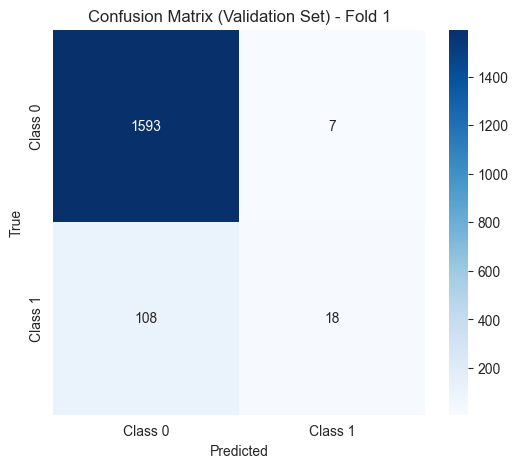

Fold 2/5


Epoch 1/20
Train Loss: 0.0878 | Train ROC-AUC: 0.9322 | Train Accuracy: 0.9686
Validation Loss: 0.0409 | Validation ROC-AUC: 0.8596 | Validation Accuracy: 0.9293


Epoch 2/20
Train Loss: 0.0846 | Train ROC-AUC: 0.9310 | Train Accuracy: 0.9701
Validation Loss: 0.0421 | Validation ROC-AUC: 0.8522 | Validation Accuracy: 0.9316


Epoch 3/20
Train Loss: 0.0833 | Train ROC-AUC: 0.9372 | Train Accuracy: 0.9694
Validation Loss: 0.0434 | Validation ROC-AUC: 0.8793 | Validation Accuracy: 0.9276


Epoch 4/20
Train Loss: 0.0830 | Train ROC-AUC: 0.9363 | Train Accuracy: 0.9709
Validation Loss: 0.0429 | Validation ROC-AUC: 0.8845 | Validation Accuracy: 0.9293


Epoch 5/20
Train Loss: 0.0804 | Train ROC-AUC: 0.9429 | Train Accuracy: 0.9707
Validation Loss: 0.0414 | Validation ROC-AUC: 0.8819 | Validation Accuracy: 0.9368


Epoch 6/20
Train Loss: 0.0828 | Train ROC-AUC: 0.9420 | Train Accuracy: 0.9704
Validation Loss: 0.0487 | Validation ROC-AUC: 0.8558 | Validation Accuracy: 0.9276


Epoch 7/20
Train Loss: 0.0849 | Train ROC-AUC: 0.9355 | Train Accuracy: 0.9703
Validation Loss: 0.0394 | Validation ROC-AUC: 0.8758 | Validation Accuracy: 0.9351


Epoch 8/20
Train Loss: 0.0795 | Train ROC-AUC: 0.9395 | Train Accuracy: 0.9717
Validation Loss: 0.0349 | Validation ROC-AUC: 0.8768 | Validation Accuracy: 0.9426


Epoch 9/20
Train Loss: 0.0788 | Train ROC-AUC: 0.9467 | Train Accuracy: 0.9703
Validation Loss: 0.0455 | Validation ROC-AUC: 0.8596 | Validation Accuracy: 0.9345


Epoch 10/20
Train Loss: 0.0809 | Train ROC-AUC: 0.9436 | Train Accuracy: 0.9690
Validation Loss: 0.0484 | Validation ROC-AUC: 0.7977 | Validation Accuracy: 0.9241


Epoch 11/20
Train Loss: 0.0812 | Train ROC-AUC: 0.9411 | Train Accuracy: 0.9700
Validation Loss: 0.0458 | Validation ROC-AUC: 0.8547 | Validation Accuracy: 0.9334


Epoch 12/20
Train Loss: 0.0788 | Train ROC-AUC: 0.9422 | Train Accuracy: 0.9725
Validation Loss: 0.0473 | Validation ROC-AUC: 0.8710 | Validation Accuracy: 0.9322


Epoch 13/20
Train Loss: 0.0759 | Train ROC-AUC: 0.9470 | Train Accuracy: 0.9715
Validation Loss: 0.0418 | Validation ROC-AUC: 0.8751 | Validation Accuracy: 0.9351


Epoch 14/20
Train Loss: 0.0768 | Train ROC-AUC: 0.9479 | Train Accuracy: 0.9723
Validation Loss: 0.0446 | Validation ROC-AUC: 0.8777 | Validation Accuracy: 0.9270


Epoch 15/20
Train Loss: 0.0790 | Train ROC-AUC: 0.9434 | Train Accuracy: 0.9712
Validation Loss: 0.0435 | Validation ROC-AUC: 0.8643 | Validation Accuracy: 0.9340


Epoch 16/20
Train Loss: 0.0792 | Train ROC-AUC: 0.9407 | Train Accuracy: 0.9715
Validation Loss: 0.0416 | Validation ROC-AUC: 0.8885 | Validation Accuracy: 0.9351


Epoch 17/20
Train Loss: 0.0756 | Train ROC-AUC: 0.9515 | Train Accuracy: 0.9720
Validation Loss: 0.0366 | Validation ROC-AUC: 0.8768 | Validation Accuracy: 0.9386


Epoch 18/20
Train Loss: 0.0743 | Train ROC-AUC: 0.9529 | Train Accuracy: 0.9709
Validation Loss: 0.0409 | Validation ROC-AUC: 0.8712 | Validation Accuracy: 0.9328


Epoch 19/20
Train Loss: 0.0759 | Train ROC-AUC: 0.9463 | Train Accuracy: 0.9728
Validation Loss: 0.0414 | Validation ROC-AUC: 0.8842 | Validation Accuracy: 0.9316


Epoch 20/20
Train Loss: 0.0736 | Train ROC-AUC: 0.9546 | Train Accuracy: 0.9715
Validation Loss: 0.0474 | Validation ROC-AUC: 0.8517 | Validation Accuracy: 0.9334


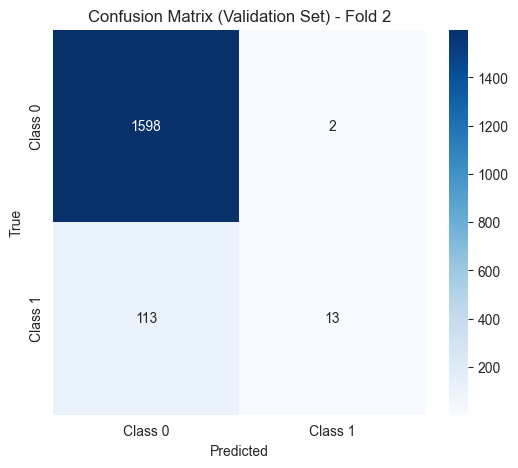

Fold 3/5


Epoch 1/20
Train Loss: 0.0922 | Train ROC-AUC: 0.9285 | Train Accuracy: 0.9652
Validation Loss: 0.0207 | Validation ROC-AUC: 0.9548 | Validation Accuracy: 0.9664


Epoch 2/20
Train Loss: 0.0903 | Train ROC-AUC: 0.9361 | Train Accuracy: 0.9655
Validation Loss: 0.0240 | Validation ROC-AUC: 0.9461 | Validation Accuracy: 0.9641


Epoch 3/20
Train Loss: 0.0915 | Train ROC-AUC: 0.9341 | Train Accuracy: 0.9649
Validation Loss: 0.0202 | Validation ROC-AUC: 0.9511 | Validation Accuracy: 0.9670


Epoch 4/20
Train Loss: 0.0880 | Train ROC-AUC: 0.9376 | Train Accuracy: 0.9652
Validation Loss: 0.0217 | Validation ROC-AUC: 0.9272 | Validation Accuracy: 0.9687


Epoch 5/20
Train Loss: 0.0900 | Train ROC-AUC: 0.9385 | Train Accuracy: 0.9644
Validation Loss: 0.0196 | Validation ROC-AUC: 0.9658 | Validation Accuracy: 0.9670


Epoch 6/20
Train Loss: 0.0893 | Train ROC-AUC: 0.9352 | Train Accuracy: 0.9648
Validation Loss: 0.0204 | Validation ROC-AUC: 0.9604 | Validation Accuracy: 0.9646


Epoch 7/20
Train Loss: 0.0888 | Train ROC-AUC: 0.9363 | Train Accuracy: 0.9652
Validation Loss: 0.0244 | Validation ROC-AUC: 0.9220 | Validation Accuracy: 0.9641


Epoch 8/20
Train Loss: 0.0923 | Train ROC-AUC: 0.9342 | Train Accuracy: 0.9641
Validation Loss: 0.0200 | Validation ROC-AUC: 0.9604 | Validation Accuracy: 0.9670


Epoch 9/20
Train Loss: 0.0895 | Train ROC-AUC: 0.9395 | Train Accuracy: 0.9649
Validation Loss: 0.0204 | Validation ROC-AUC: 0.9616 | Validation Accuracy: 0.9664


Epoch 10/20
Train Loss: 0.0890 | Train ROC-AUC: 0.9418 | Train Accuracy: 0.9658
Validation Loss: 0.0198 | Validation ROC-AUC: 0.9580 | Validation Accuracy: 0.9687


Epoch 11/20
Train Loss: 0.0857 | Train ROC-AUC: 0.9428 | Train Accuracy: 0.9660
Validation Loss: 0.0221 | Validation ROC-AUC: 0.9554 | Validation Accuracy: 0.9641


Epoch 12/20
Train Loss: 0.0870 | Train ROC-AUC: 0.9446 | Train Accuracy: 0.9651
Validation Loss: 0.0202 | Validation ROC-AUC: 0.9489 | Validation Accuracy: 0.9670


Epoch 13/20
Train Loss: 0.0848 | Train ROC-AUC: 0.9458 | Train Accuracy: 0.9674
Validation Loss: 0.0223 | Validation ROC-AUC: 0.9457 | Validation Accuracy: 0.9652


Epoch 14/20
Train Loss: 0.0866 | Train ROC-AUC: 0.9472 | Train Accuracy: 0.9665
Validation Loss: 0.0194 | Validation ROC-AUC: 0.9586 | Validation Accuracy: 0.9670


Epoch 15/20
Train Loss: 0.0849 | Train ROC-AUC: 0.9457 | Train Accuracy: 0.9674
Validation Loss: 0.0207 | Validation ROC-AUC: 0.9529 | Validation Accuracy: 0.9664


Epoch 16/20
Train Loss: 0.0843 | Train ROC-AUC: 0.9498 | Train Accuracy: 0.9664
Validation Loss: 0.0219 | Validation ROC-AUC: 0.9586 | Validation Accuracy: 0.9641


Epoch 17/20
Train Loss: 0.0817 | Train ROC-AUC: 0.9465 | Train Accuracy: 0.9691
Validation Loss: 0.0198 | Validation ROC-AUC: 0.9542 | Validation Accuracy: 0.9693


Epoch 18/20
Train Loss: 0.0843 | Train ROC-AUC: 0.9487 | Train Accuracy: 0.9660
Validation Loss: 0.0190 | Validation ROC-AUC: 0.9633 | Validation Accuracy: 0.9658


Epoch 19/20
Train Loss: 0.0851 | Train ROC-AUC: 0.9504 | Train Accuracy: 0.9662
Validation Loss: 0.0192 | Validation ROC-AUC: 0.9647 | Validation Accuracy: 0.9658


Epoch 20/20
Train Loss: 0.0808 | Train ROC-AUC: 0.9532 | Train Accuracy: 0.9688
Validation Loss: 0.0192 | Validation ROC-AUC: 0.9614 | Validation Accuracy: 0.9675


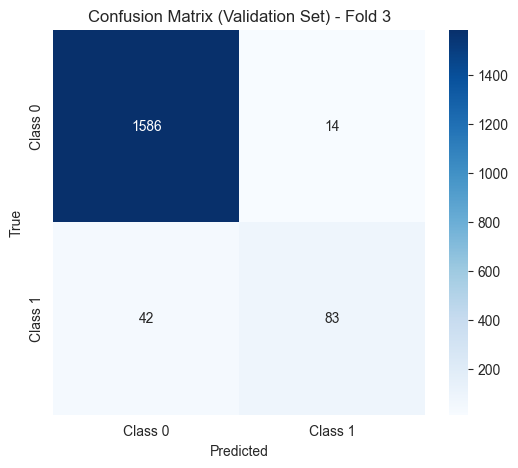

Fold 4/5


Epoch 1/20
Train Loss: 0.0952 | Train ROC-AUC: 0.9364 | Train Accuracy: 0.9606
Validation Loss: 0.0050 | Validation ROC-AUC: 0.9969 | Validation Accuracy: 0.9971


Epoch 2/20
Train Loss: 0.0955 | Train ROC-AUC: 0.9400 | Train Accuracy: 0.9607
Validation Loss: 0.0120 | Validation ROC-AUC: 0.9974 | Validation Accuracy: 0.9855


Epoch 3/20
Train Loss: 0.0928 | Train ROC-AUC: 0.9469 | Train Accuracy: 0.9597
Validation Loss: 0.0065 | Validation ROC-AUC: 0.9981 | Validation Accuracy: 0.9930


Epoch 4/20
Train Loss: 0.0935 | Train ROC-AUC: 0.9419 | Train Accuracy: 0.9618
Validation Loss: 0.0050 | Validation ROC-AUC: 0.9984 | Validation Accuracy: 0.9959


Epoch 5/20
Train Loss: 0.0943 | Train ROC-AUC: 0.9431 | Train Accuracy: 0.9612
Validation Loss: 0.0067 | Validation ROC-AUC: 0.9966 | Validation Accuracy: 0.9948


Epoch 6/20
Train Loss: 0.0927 | Train ROC-AUC: 0.9465 | Train Accuracy: 0.9599
Validation Loss: 0.0119 | Validation ROC-AUC: 0.9944 | Validation Accuracy: 0.9867


Epoch 7/20
Train Loss: 0.0897 | Train ROC-AUC: 0.9482 | Train Accuracy: 0.9631
Validation Loss: 0.0035 | Validation ROC-AUC: 0.9984 | Validation Accuracy: 0.9959


Epoch 8/20
Train Loss: 0.0883 | Train ROC-AUC: 0.9496 | Train Accuracy: 0.9631
Validation Loss: 0.0060 | Validation ROC-AUC: 0.9975 | Validation Accuracy: 0.9942


Epoch 9/20
Train Loss: 0.0878 | Train ROC-AUC: 0.9534 | Train Accuracy: 0.9626
Validation Loss: 0.0051 | Validation ROC-AUC: 0.9965 | Validation Accuracy: 0.9942


Epoch 10/20
Train Loss: 0.0896 | Train ROC-AUC: 0.9500 | Train Accuracy: 0.9612
Validation Loss: 0.0067 | Validation ROC-AUC: 0.9973 | Validation Accuracy: 0.9959


Epoch 11/20
Train Loss: 0.0883 | Train ROC-AUC: 0.9517 | Train Accuracy: 0.9638
Validation Loss: 0.0102 | Validation ROC-AUC: 0.9978 | Validation Accuracy: 0.9849


Epoch 12/20
Train Loss: 0.0914 | Train ROC-AUC: 0.9457 | Train Accuracy: 0.9613
Validation Loss: 0.0058 | Validation ROC-AUC: 0.9974 | Validation Accuracy: 0.9948


Epoch 13/20
Train Loss: 0.0886 | Train ROC-AUC: 0.9504 | Train Accuracy: 0.9619
Validation Loss: 0.0131 | Validation ROC-AUC: 0.9934 | Validation Accuracy: 0.9872


Epoch 14/20
Train Loss: 0.0854 | Train ROC-AUC: 0.9531 | Train Accuracy: 0.9641
Validation Loss: 0.0061 | Validation ROC-AUC: 0.9969 | Validation Accuracy: 0.9948


Epoch 15/20
Train Loss: 0.0886 | Train ROC-AUC: 0.9498 | Train Accuracy: 0.9622
Validation Loss: 0.0079 | Validation ROC-AUC: 0.9956 | Validation Accuracy: 0.9890


Epoch 16/20
Train Loss: 0.0837 | Train ROC-AUC: 0.9581 | Train Accuracy: 0.9644
Validation Loss: 0.0064 | Validation ROC-AUC: 0.9983 | Validation Accuracy: 0.9948


Epoch 17/20
Train Loss: 0.0845 | Train ROC-AUC: 0.9578 | Train Accuracy: 0.9620
Validation Loss: 0.0097 | Validation ROC-AUC: 0.9965 | Validation Accuracy: 0.9855


Epoch 18/20
Train Loss: 0.0857 | Train ROC-AUC: 0.9551 | Train Accuracy: 0.9636
Validation Loss: 0.0072 | Validation ROC-AUC: 0.9969 | Validation Accuracy: 0.9901


Epoch 19/20
Train Loss: 0.0851 | Train ROC-AUC: 0.9546 | Train Accuracy: 0.9629
Validation Loss: 0.0073 | Validation ROC-AUC: 0.9970 | Validation Accuracy: 0.9896


Epoch 20/20
Train Loss: 0.0844 | Train ROC-AUC: 0.9609 | Train Accuracy: 0.9620
Validation Loss: 0.0127 | Validation ROC-AUC: 0.9975 | Validation Accuracy: 0.9780


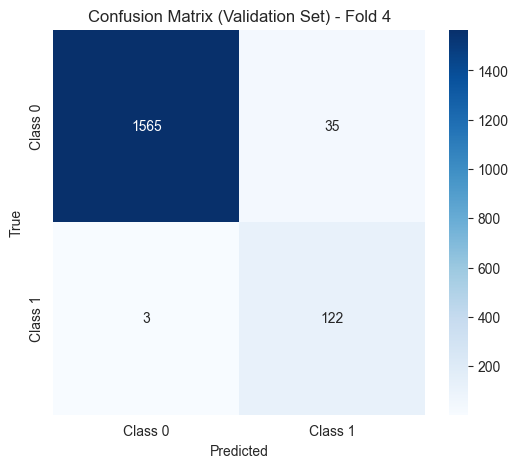

Fold 5/5


Epoch 1/20
Train Loss: 0.0811 | Train ROC-AUC: 0.9623 | Train Accuracy: 0.9633
Validation Loss: 0.0075 | Validation ROC-AUC: 0.9967 | Validation Accuracy: 0.9896


Epoch 2/20
Train Loss: 0.0821 | Train ROC-AUC: 0.9567 | Train Accuracy: 0.9661
Validation Loss: 0.0067 | Validation ROC-AUC: 0.9940 | Validation Accuracy: 0.9913


Epoch 3/20
Train Loss: 0.0805 | Train ROC-AUC: 0.9641 | Train Accuracy: 0.9642
Validation Loss: 0.0102 | Validation ROC-AUC: 0.9962 | Validation Accuracy: 0.9838


Epoch 4/20
Train Loss: 0.0783 | Train ROC-AUC: 0.9658 | Train Accuracy: 0.9636
Validation Loss: 0.0090 | Validation ROC-AUC: 0.9968 | Validation Accuracy: 0.9913


Epoch 5/20
Train Loss: 0.0781 | Train ROC-AUC: 0.9644 | Train Accuracy: 0.9645
Validation Loss: 0.0105 | Validation ROC-AUC: 0.9955 | Validation Accuracy: 0.9849


Epoch 6/20
Train Loss: 0.0781 | Train ROC-AUC: 0.9641 | Train Accuracy: 0.9648
Validation Loss: 0.0069 | Validation ROC-AUC: 0.9968 | Validation Accuracy: 0.9913


Epoch 7/20
Train Loss: 0.0817 | Train ROC-AUC: 0.9602 | Train Accuracy: 0.9639
Validation Loss: 0.0057 | Validation ROC-AUC: 0.9977 | Validation Accuracy: 0.9930


Epoch 8/20
Train Loss: 0.0765 | Train ROC-AUC: 0.9665 | Train Accuracy: 0.9667
Validation Loss: 0.0079 | Validation ROC-AUC: 0.9974 | Validation Accuracy: 0.9878


Epoch 9/20
Train Loss: 0.0804 | Train ROC-AUC: 0.9604 | Train Accuracy: 0.9652
Validation Loss: 0.0087 | Validation ROC-AUC: 0.9967 | Validation Accuracy: 0.9907


Epoch 10/20
Train Loss: 0.0742 | Train ROC-AUC: 0.9669 | Train Accuracy: 0.9674
Validation Loss: 0.0099 | Validation ROC-AUC: 0.9960 | Validation Accuracy: 0.9832


Epoch 11/20
Train Loss: 0.0746 | Train ROC-AUC: 0.9677 | Train Accuracy: 0.9675
Validation Loss: 0.0084 | Validation ROC-AUC: 0.9951 | Validation Accuracy: 0.9849


Epoch 12/20
Train Loss: 0.0739 | Train ROC-AUC: 0.9673 | Train Accuracy: 0.9673
Validation Loss: 0.0072 | Validation ROC-AUC: 0.9976 | Validation Accuracy: 0.9901


Epoch 13/20
Train Loss: 0.0761 | Train ROC-AUC: 0.9675 | Train Accuracy: 0.9674
Validation Loss: 0.0066 | Validation ROC-AUC: 0.9943 | Validation Accuracy: 0.9890


Epoch 14/20
Train Loss: 0.0712 | Train ROC-AUC: 0.9712 | Train Accuracy: 0.9683
Validation Loss: 0.0119 | Validation ROC-AUC: 0.9950 | Validation Accuracy: 0.9820


Epoch 15/20
Train Loss: 0.0697 | Train ROC-AUC: 0.9737 | Train Accuracy: 0.9688
Validation Loss: 0.0091 | Validation ROC-AUC: 0.9927 | Validation Accuracy: 0.9849


Epoch 16/20
Train Loss: 0.0733 | Train ROC-AUC: 0.9706 | Train Accuracy: 0.9657
Validation Loss: 0.0081 | Validation ROC-AUC: 0.9943 | Validation Accuracy: 0.9878


Epoch 17/20
Train Loss: 0.0704 | Train ROC-AUC: 0.9740 | Train Accuracy: 0.9674
Validation Loss: 0.0102 | Validation ROC-AUC: 0.9949 | Validation Accuracy: 0.9826


Epoch 18/20
Train Loss: 0.0706 | Train ROC-AUC: 0.9730 | Train Accuracy: 0.9696
Validation Loss: 0.0080 | Validation ROC-AUC: 0.9982 | Validation Accuracy: 0.9867


Epoch 19/20
Train Loss: 0.0692 | Train ROC-AUC: 0.9743 | Train Accuracy: 0.9687
Validation Loss: 0.0087 | Validation ROC-AUC: 0.9967 | Validation Accuracy: 0.9861


Epoch 20/20
Train Loss: 0.0669 | Train ROC-AUC: 0.9746 | Train Accuracy: 0.9712
Validation Loss: 0.0073 | Validation ROC-AUC: 0.9944 | Validation Accuracy: 0.9884


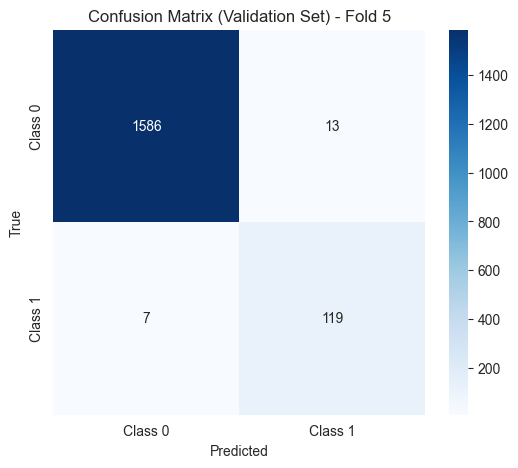

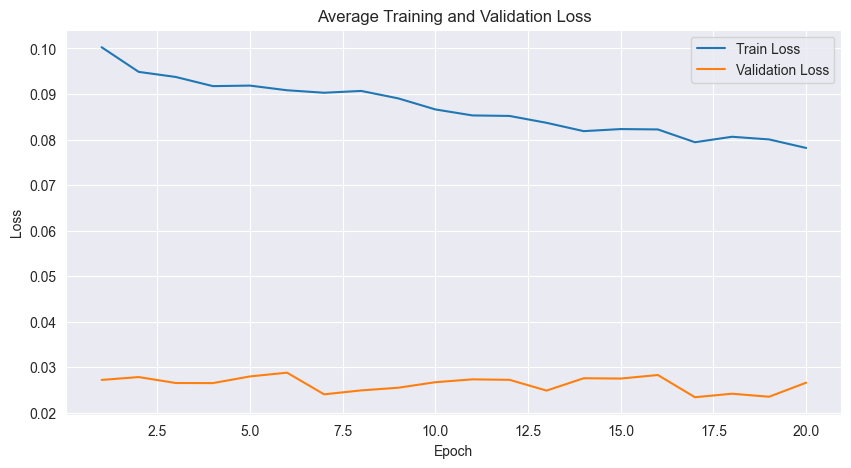

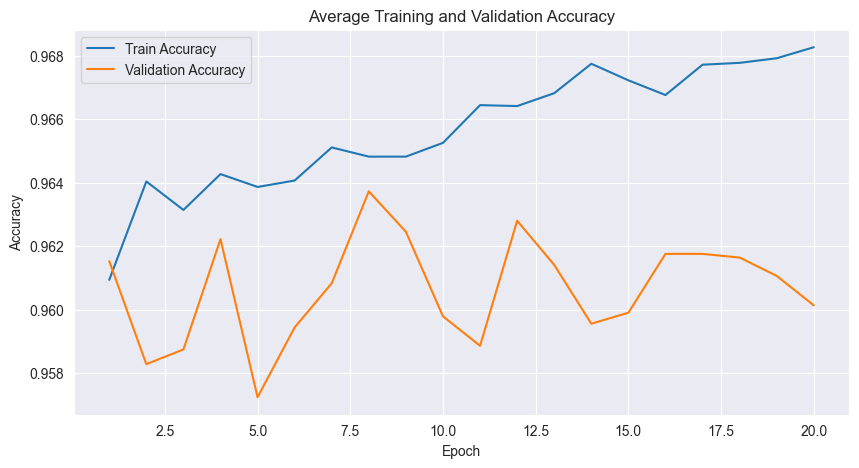

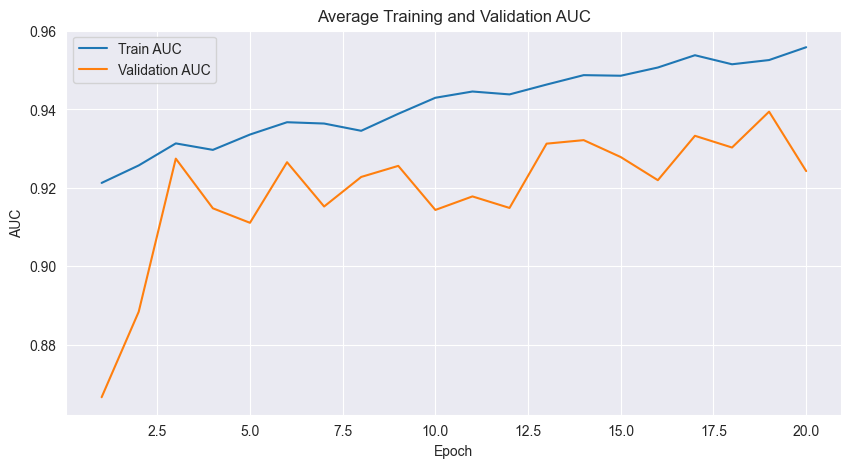

In [41]:
train_and_evaluate_cv(dataset,model,criterion,optim,num_epoch,device,'resnet_Itt_2',weight_decay= 1e-4,n_splits=5)

In [45]:
path = 'resnet_Itt_2'
eval(model,path,device,test_loader)

/var/folders/d2/dsq0cfpj3wnf4dxf7hwsn5w00000gn/T/ipykernel_5172/3250025017.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))
Evalua

Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.98      0.97      0.97      2000
     Class 1       0.32      0.38      0.35        79

    accuracy                           0.95      2079
   macro avg       0.65      0.67      0.66      2079
weighted avg       0.95      0.95      0.95      2079

Test ROC-AUC: 0.7423


### Training WITH data augmentation efficientNet B0

In [45]:
model_b0 = EfficientNet.from_pretrained('efficientnet-b0')
in_features = model_b0._fc.in_features
model_b0._fc = nn.Linear(in_features, 1)
print(device)
model_b0.to(device)
criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
dataset = datasets.ImageFolder('train_dataset_aug', transform=transform)
num_epoch = 20

Loaded pretrained weights for efficientnet-b0
mps


Fold 1/5


Epoch 1/20
Train Loss: 0.5444 | Train ROC-AUC: 0.4407 | Train Accuracy: 0.5831
Validation Loss: 0.1353 | Validation ROC-AUC: 0.4625 | Validation Accuracy: 0.5440


Epoch 2/20
Train Loss: 0.5445 | Train ROC-AUC: 0.4381 | Train Accuracy: 0.5766
Validation Loss: 0.1306 | Validation ROC-AUC: 0.4286 | Validation Accuracy: 0.7787


Epoch 3/20
Train Loss: 0.5438 | Train ROC-AUC: 0.4480 | Train Accuracy: 0.5861
Validation Loss: 0.1344 | Validation ROC-AUC: 0.4961 | Validation Accuracy: 0.6448


Epoch 4/20
Train Loss: 0.5438 | Train ROC-AUC: 0.4512 | Train Accuracy: 0.5811
Validation Loss: 0.1365 | Validation ROC-AUC: 0.5021 | Validation Accuracy: 0.5689


Epoch 5/20
Train Loss: 0.5442 | Train ROC-AUC: 0.4381 | Train Accuracy: 0.5744
Validation Loss: 0.1363 | Validation ROC-AUC: 0.4997 | Validation Accuracy: 0.5713


Epoch 6/20
Train Loss: 0.5449 | Train ROC-AUC: 0.4177 | Train Accuracy: 0.5772
Validation Loss: 0.1362 | Validation ROC-AUC: 0.4980 | Validation Accuracy: 0.5718


Epoch 7/20
Train Loss: 0.5441 | Train ROC-AUC: 0.4425 | Train Accuracy: 0.5795
Validation Loss: 0.1363 | Validation ROC-AUC: 0.4990 | Validation Accuracy: 0.5695


Epoch 8/20
Train Loss: 0.5444 | Train ROC-AUC: 0.4482 | Train Accuracy: 0.5725
Validation Loss: 0.1363 | Validation ROC-AUC: 0.5000 | Validation Accuracy: 0.5718


Epoch 9/20
Train Loss: 0.5443 | Train ROC-AUC: 0.4428 | Train Accuracy: 0.5819
Validation Loss: 0.1364 | Validation ROC-AUC: 0.5010 | Validation Accuracy: 0.5660


Epoch 10/20
Train Loss: 0.5448 | Train ROC-AUC: 0.4492 | Train Accuracy: 0.5785
Validation Loss: 0.1363 | Validation ROC-AUC: 0.4992 | Validation Accuracy: 0.5730


Epoch 11/20
Train Loss: 0.5437 | Train ROC-AUC: 0.4561 | Train Accuracy: 0.5763
Validation Loss: 0.1361 | Validation ROC-AUC: 0.4975 | Validation Accuracy: 0.5730


Epoch 12/20
Train Loss: 0.5427 | Train ROC-AUC: 0.4608 | Train Accuracy: 0.5921
Validation Loss: 0.1365 | Validation ROC-AUC: 0.4979 | Validation Accuracy: 0.5603


Epoch 13/20
Train Loss: 0.5432 | Train ROC-AUC: 0.4401 | Train Accuracy: 0.5863
Validation Loss: 0.1362 | Validation ROC-AUC: 0.4984 | Validation Accuracy: 0.5713


Epoch 14/20
Train Loss: 0.5439 | Train ROC-AUC: 0.4371 | Train Accuracy: 0.5814
Validation Loss: 0.1362 | Validation ROC-AUC: 0.4984 | Validation Accuracy: 0.5736


Epoch 15/20
Train Loss: 0.5446 | Train ROC-AUC: 0.4341 | Train Accuracy: 0.5809
Validation Loss: 0.1362 | Validation ROC-AUC: 0.4995 | Validation Accuracy: 0.5736


Epoch 16/20
Train Loss: 0.5445 | Train ROC-AUC: 0.4495 | Train Accuracy: 0.5709
Validation Loss: 0.1365 | Validation ROC-AUC: 0.4995 | Validation Accuracy: 0.5701


Epoch 17/20
Train Loss: 0.5444 | Train ROC-AUC: 0.4537 | Train Accuracy: 0.5814
Validation Loss: 0.1364 | Validation ROC-AUC: 0.5001 | Validation Accuracy: 0.5678


Epoch 18/20
Train Loss: 0.5436 | Train ROC-AUC: 0.4577 | Train Accuracy: 0.5815
Validation Loss: 0.1363 | Validation ROC-AUC: 0.4993 | Validation Accuracy: 0.5718


Epoch 19/20
Train Loss: 0.5435 | Train ROC-AUC: 0.4448 | Train Accuracy: 0.5806
Validation Loss: 0.1362 | Validation ROC-AUC: 0.4969 | Validation Accuracy: 0.5678


Epoch 20/20
Train Loss: 0.5442 | Train ROC-AUC: 0.4403 | Train Accuracy: 0.5799
Validation Loss: 0.1363 | Validation ROC-AUC: 0.4988 | Validation Accuracy: 0.5724


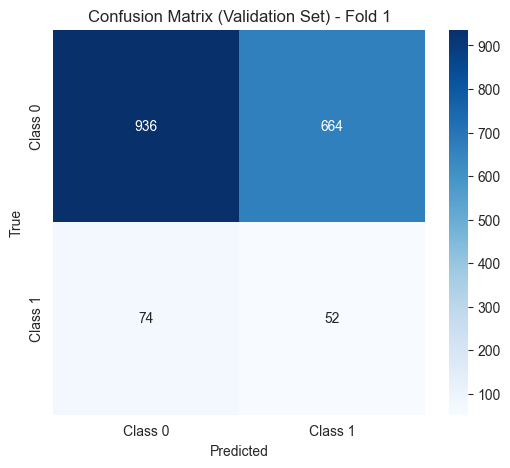

Fold 2/5


Epoch 1/20
Train Loss: 0.5448 | Train ROC-AUC: 0.4396 | Train Accuracy: 0.5789
Validation Loss: 0.1355 | Validation ROC-AUC: 0.5106 | Validation Accuracy: 0.6020


Epoch 2/20
Train Loss: 0.5442 | Train ROC-AUC: 0.4384 | Train Accuracy: 0.5806
Validation Loss: 0.1356 | Validation ROC-AUC: 0.5096 | Validation Accuracy: 0.5968


Epoch 3/20
Train Loss: 0.5457 | Train ROC-AUC: 0.4198 | Train Accuracy: 0.5650
Validation Loss: 0.1355 | Validation ROC-AUC: 0.5132 | Validation Accuracy: 0.5985


Epoch 4/20
Train Loss: 0.5448 | Train ROC-AUC: 0.4512 | Train Accuracy: 0.5799
Validation Loss: 0.1355 | Validation ROC-AUC: 0.5127 | Validation Accuracy: 0.5991


Epoch 5/20
Train Loss: 0.5451 | Train ROC-AUC: 0.4246 | Train Accuracy: 0.5748
Validation Loss: 0.1355 | Validation ROC-AUC: 0.5125 | Validation Accuracy: 0.5985


Epoch 6/20
Train Loss: 0.5444 | Train ROC-AUC: 0.4356 | Train Accuracy: 0.5785
Validation Loss: 0.1354 | Validation ROC-AUC: 0.5134 | Validation Accuracy: 0.6031


Epoch 7/20
Train Loss: 0.5448 | Train ROC-AUC: 0.4313 | Train Accuracy: 0.5748
Validation Loss: 0.1357 | Validation ROC-AUC: 0.5101 | Validation Accuracy: 0.5933


Epoch 8/20
Train Loss: 0.5446 | Train ROC-AUC: 0.4396 | Train Accuracy: 0.5741
Validation Loss: 0.1355 | Validation ROC-AUC: 0.5113 | Validation Accuracy: 0.5997


Epoch 9/20
Train Loss: 0.5446 | Train ROC-AUC: 0.4308 | Train Accuracy: 0.5764
Validation Loss: 0.1357 | Validation ROC-AUC: 0.5103 | Validation Accuracy: 0.5968


Epoch 10/20
Train Loss: 0.5441 | Train ROC-AUC: 0.4574 | Train Accuracy: 0.5864
Validation Loss: 0.1355 | Validation ROC-AUC: 0.5128 | Validation Accuracy: 0.5973


Epoch 11/20
Train Loss: 0.5439 | Train ROC-AUC: 0.4456 | Train Accuracy: 0.5799
Validation Loss: 0.1356 | Validation ROC-AUC: 0.5136 | Validation Accuracy: 0.5973


Epoch 12/20
Train Loss: 0.5453 | Train ROC-AUC: 0.4221 | Train Accuracy: 0.5722
Validation Loss: 0.1354 | Validation ROC-AUC: 0.5111 | Validation Accuracy: 0.6037


Epoch 13/20
Train Loss: 0.5441 | Train ROC-AUC: 0.4351 | Train Accuracy: 0.5831
Validation Loss: 0.1357 | Validation ROC-AUC: 0.5110 | Validation Accuracy: 0.5950


Epoch 14/20
Train Loss: 0.5442 | Train ROC-AUC: 0.4532 | Train Accuracy: 0.5795
Validation Loss: 0.1355 | Validation ROC-AUC: 0.5126 | Validation Accuracy: 0.6008


Epoch 15/20
Train Loss: 0.5440 | Train ROC-AUC: 0.4644 | Train Accuracy: 0.5856
Validation Loss: 0.1356 | Validation ROC-AUC: 0.5123 | Validation Accuracy: 0.5939


Epoch 16/20
Train Loss: 0.5450 | Train ROC-AUC: 0.4386 | Train Accuracy: 0.5761
Validation Loss: 0.1356 | Validation ROC-AUC: 0.5120 | Validation Accuracy: 0.5968


Epoch 17/20
Train Loss: 0.5446 | Train ROC-AUC: 0.4524 | Train Accuracy: 0.5761
Validation Loss: 0.1356 | Validation ROC-AUC: 0.5107 | Validation Accuracy: 0.5956


Epoch 18/20
Train Loss: 0.5443 | Train ROC-AUC: 0.4519 | Train Accuracy: 0.5740
Validation Loss: 0.1357 | Validation ROC-AUC: 0.5093 | Validation Accuracy: 0.5962


Epoch 19/20
Train Loss: 0.5448 | Train ROC-AUC: 0.4508 | Train Accuracy: 0.5799
Validation Loss: 0.1356 | Validation ROC-AUC: 0.5116 | Validation Accuracy: 0.5968


Epoch 20/20
Train Loss: 0.5442 | Train ROC-AUC: 0.4429 | Train Accuracy: 0.5727
Validation Loss: 0.1357 | Validation ROC-AUC: 0.5096 | Validation Accuracy: 0.5950


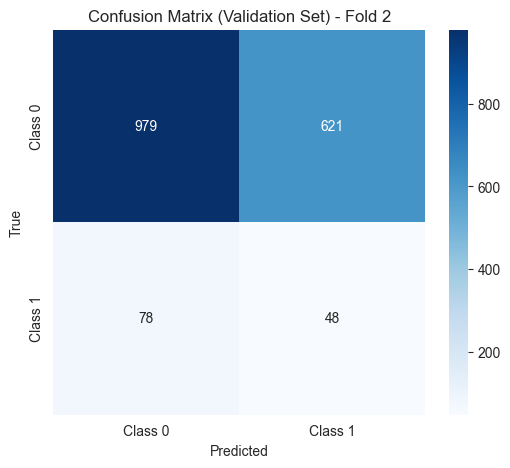

Fold 3/5


Epoch 1/20
Train Loss: 0.5444 | Train ROC-AUC: 0.4569 | Train Accuracy: 0.5793
Validation Loss: 0.1360 | Validation ROC-AUC: 0.4178 | Validation Accuracy: 0.5977


Epoch 2/20
Train Loss: 0.5445 | Train ROC-AUC: 0.4417 | Train Accuracy: 0.5739
Validation Loss: 0.1360 | Validation ROC-AUC: 0.4187 | Validation Accuracy: 0.6012


Epoch 3/20
Train Loss: 0.5436 | Train ROC-AUC: 0.4560 | Train Accuracy: 0.5840
Validation Loss: 0.1360 | Validation ROC-AUC: 0.4200 | Validation Accuracy: 0.5971


Epoch 4/20
Train Loss: 0.5451 | Train ROC-AUC: 0.4428 | Train Accuracy: 0.5743
Validation Loss: 0.1359 | Validation ROC-AUC: 0.4204 | Validation Accuracy: 0.5994


Epoch 5/20
Train Loss: 0.5443 | Train ROC-AUC: 0.4483 | Train Accuracy: 0.5737
Validation Loss: 0.1357 | Validation ROC-AUC: 0.4208 | Validation Accuracy: 0.6046


Epoch 6/20
Train Loss: 0.5446 | Train ROC-AUC: 0.4497 | Train Accuracy: 0.5787
Validation Loss: 0.1359 | Validation ROC-AUC: 0.4198 | Validation Accuracy: 0.5994


Epoch 7/20
Train Loss: 0.5440 | Train ROC-AUC: 0.4524 | Train Accuracy: 0.5761
Validation Loss: 0.1361 | Validation ROC-AUC: 0.4172 | Validation Accuracy: 0.5936


Epoch 8/20
Train Loss: 0.5441 | Train ROC-AUC: 0.4491 | Train Accuracy: 0.5749
Validation Loss: 0.1359 | Validation ROC-AUC: 0.4179 | Validation Accuracy: 0.5977


Epoch 9/20
Train Loss: 0.5437 | Train ROC-AUC: 0.4595 | Train Accuracy: 0.5785
Validation Loss: 0.1359 | Validation ROC-AUC: 0.4168 | Validation Accuracy: 0.5959


Epoch 10/20
Train Loss: 0.5436 | Train ROC-AUC: 0.4547 | Train Accuracy: 0.5836
Validation Loss: 0.1357 | Validation ROC-AUC: 0.4208 | Validation Accuracy: 0.6023


Epoch 11/20
Train Loss: 0.5452 | Train ROC-AUC: 0.4337 | Train Accuracy: 0.5739
Validation Loss: 0.1358 | Validation ROC-AUC: 0.4172 | Validation Accuracy: 0.6012


Epoch 12/20
Train Loss: 0.5444 | Train ROC-AUC: 0.4405 | Train Accuracy: 0.5748
Validation Loss: 0.1360 | Validation ROC-AUC: 0.4174 | Validation Accuracy: 0.5983


Epoch 13/20
Train Loss: 0.5442 | Train ROC-AUC: 0.4656 | Train Accuracy: 0.5772
Validation Loss: 0.1360 | Validation ROC-AUC: 0.4173 | Validation Accuracy: 0.5936


Epoch 14/20
Train Loss: 0.5447 | Train ROC-AUC: 0.4301 | Train Accuracy: 0.5797
Validation Loss: 0.1357 | Validation ROC-AUC: 0.4193 | Validation Accuracy: 0.6064


Epoch 15/20
Train Loss: 0.5441 | Train ROC-AUC: 0.4518 | Train Accuracy: 0.5807
Validation Loss: 0.1360 | Validation ROC-AUC: 0.4190 | Validation Accuracy: 0.5983


Epoch 16/20
Train Loss: 0.5428 | Train ROC-AUC: 0.4653 | Train Accuracy: 0.5872
Validation Loss: 0.1359 | Validation ROC-AUC: 0.4167 | Validation Accuracy: 0.5959


Epoch 17/20
Train Loss: 0.5446 | Train ROC-AUC: 0.4437 | Train Accuracy: 0.5764
Validation Loss: 0.1359 | Validation ROC-AUC: 0.4177 | Validation Accuracy: 0.5954


Epoch 18/20
Train Loss: 0.5438 | Train ROC-AUC: 0.4571 | Train Accuracy: 0.5845
Validation Loss: 0.1357 | Validation ROC-AUC: 0.4182 | Validation Accuracy: 0.6023


Epoch 19/20
Train Loss: 0.5443 | Train ROC-AUC: 0.4511 | Train Accuracy: 0.5806
Validation Loss: 0.1360 | Validation ROC-AUC: 0.4144 | Validation Accuracy: 0.5919


Epoch 20/20
Train Loss: 0.5448 | Train ROC-AUC: 0.4446 | Train Accuracy: 0.5707
Validation Loss: 0.1358 | Validation ROC-AUC: 0.4201 | Validation Accuracy: 0.6017


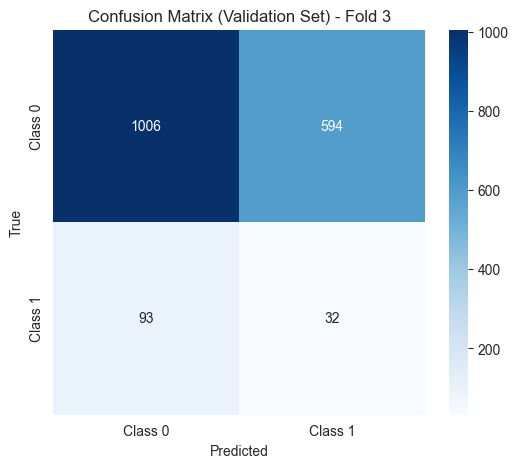

Fold 4/5


Epoch 1/20
Train Loss: 0.5434 | Train ROC-AUC: 0.4679 | Train Accuracy: 0.5868
Validation Loss: 0.1367 | Validation ROC-AUC: 0.3114 | Validation Accuracy: 0.5716


Epoch 2/20
Train Loss: 0.5433 | Train ROC-AUC: 0.4718 | Train Accuracy: 0.5862
Validation Loss: 0.1369 | Validation ROC-AUC: 0.3159 | Validation Accuracy: 0.5664


Epoch 3/20
Train Loss: 0.5432 | Train ROC-AUC: 0.4692 | Train Accuracy: 0.5845
Validation Loss: 0.1368 | Validation ROC-AUC: 0.3105 | Validation Accuracy: 0.5693


Epoch 4/20
Train Loss: 0.5439 | Train ROC-AUC: 0.4701 | Train Accuracy: 0.5842
Validation Loss: 0.1368 | Validation ROC-AUC: 0.3112 | Validation Accuracy: 0.5670


Epoch 5/20
Train Loss: 0.5438 | Train ROC-AUC: 0.4639 | Train Accuracy: 0.5829
Validation Loss: 0.1369 | Validation ROC-AUC: 0.3147 | Validation Accuracy: 0.5658


Epoch 6/20
Train Loss: 0.5445 | Train ROC-AUC: 0.4595 | Train Accuracy: 0.5768
Validation Loss: 0.1369 | Validation ROC-AUC: 0.3134 | Validation Accuracy: 0.5664


Epoch 7/20
Train Loss: 0.5441 | Train ROC-AUC: 0.4743 | Train Accuracy: 0.5787
Validation Loss: 0.1367 | Validation ROC-AUC: 0.3168 | Validation Accuracy: 0.5710


Epoch 8/20
Train Loss: 0.5435 | Train ROC-AUC: 0.4579 | Train Accuracy: 0.5866
Validation Loss: 0.1365 | Validation ROC-AUC: 0.3119 | Validation Accuracy: 0.5745


Epoch 9/20
Train Loss: 0.5435 | Train ROC-AUC: 0.4812 | Train Accuracy: 0.5866
Validation Loss: 0.1368 | Validation ROC-AUC: 0.3128 | Validation Accuracy: 0.5704


Epoch 10/20
Train Loss: 0.5434 | Train ROC-AUC: 0.4574 | Train Accuracy: 0.5822
Validation Loss: 0.1370 | Validation ROC-AUC: 0.3139 | Validation Accuracy: 0.5641


Epoch 11/20
Train Loss: 0.5441 | Train ROC-AUC: 0.4498 | Train Accuracy: 0.5811
Validation Loss: 0.1366 | Validation ROC-AUC: 0.3148 | Validation Accuracy: 0.5751


Epoch 12/20
Train Loss: 0.5437 | Train ROC-AUC: 0.4633 | Train Accuracy: 0.5785
Validation Loss: 0.1367 | Validation ROC-AUC: 0.3082 | Validation Accuracy: 0.5681


Epoch 13/20
Train Loss: 0.5430 | Train ROC-AUC: 0.4650 | Train Accuracy: 0.5866
Validation Loss: 0.1368 | Validation ROC-AUC: 0.3152 | Validation Accuracy: 0.5658


Epoch 14/20
Train Loss: 0.5441 | Train ROC-AUC: 0.4682 | Train Accuracy: 0.5759
Validation Loss: 0.1367 | Validation ROC-AUC: 0.3138 | Validation Accuracy: 0.5710


Epoch 15/20
Train Loss: 0.5438 | Train ROC-AUC: 0.4754 | Train Accuracy: 0.5849
Validation Loss: 0.1368 | Validation ROC-AUC: 0.3108 | Validation Accuracy: 0.5704


Epoch 16/20
Train Loss: 0.5435 | Train ROC-AUC: 0.4808 | Train Accuracy: 0.5878
Validation Loss: 0.1368 | Validation ROC-AUC: 0.3100 | Validation Accuracy: 0.5658


Epoch 17/20
Train Loss: 0.5443 | Train ROC-AUC: 0.4606 | Train Accuracy: 0.5806
Validation Loss: 0.1368 | Validation ROC-AUC: 0.3125 | Validation Accuracy: 0.5664


Epoch 18/20
Train Loss: 0.5438 | Train ROC-AUC: 0.4816 | Train Accuracy: 0.5832
Validation Loss: 0.1368 | Validation ROC-AUC: 0.3164 | Validation Accuracy: 0.5681


Epoch 19/20
Train Loss: 0.5439 | Train ROC-AUC: 0.4628 | Train Accuracy: 0.5830
Validation Loss: 0.1369 | Validation ROC-AUC: 0.3131 | Validation Accuracy: 0.5664


Epoch 20/20
Train Loss: 0.5442 | Train ROC-AUC: 0.4687 | Train Accuracy: 0.5816
Validation Loss: 0.1368 | Validation ROC-AUC: 0.3126 | Validation Accuracy: 0.5693


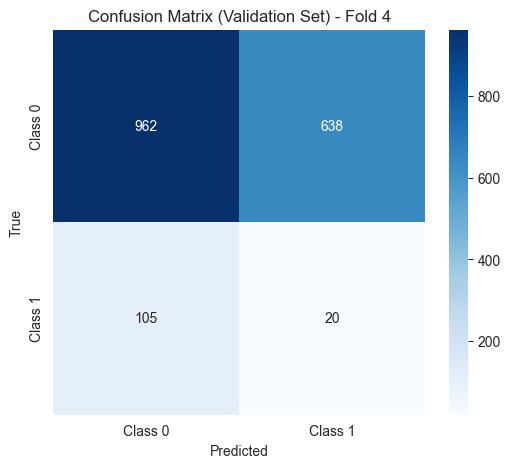

Fold 5/5


Epoch 1/20
Train Loss: 0.5440 | Train ROC-AUC: 0.4688 | Train Accuracy: 0.5808
Validation Loss: 0.1366 | Validation ROC-AUC: 0.3240 | Validation Accuracy: 0.5803


Epoch 2/20
Train Loss: 0.5446 | Train ROC-AUC: 0.4569 | Train Accuracy: 0.5830
Validation Loss: 0.1366 | Validation ROC-AUC: 0.3297 | Validation Accuracy: 0.5797


Epoch 3/20
Train Loss: 0.5443 | Train ROC-AUC: 0.4622 | Train Accuracy: 0.5830
Validation Loss: 0.1367 | Validation ROC-AUC: 0.3255 | Validation Accuracy: 0.5786


Epoch 4/20
Train Loss: 0.5439 | Train ROC-AUC: 0.4485 | Train Accuracy: 0.5858
Validation Loss: 0.1368 | Validation ROC-AUC: 0.3253 | Validation Accuracy: 0.5745


Epoch 5/20
Train Loss: 0.5441 | Train ROC-AUC: 0.4628 | Train Accuracy: 0.5806
Validation Loss: 0.1364 | Validation ROC-AUC: 0.3322 | Validation Accuracy: 0.5838


Epoch 6/20
Train Loss: 0.5443 | Train ROC-AUC: 0.4626 | Train Accuracy: 0.5888
Validation Loss: 0.1367 | Validation ROC-AUC: 0.3226 | Validation Accuracy: 0.5745


Epoch 7/20
Train Loss: 0.5437 | Train ROC-AUC: 0.4514 | Train Accuracy: 0.5832
Validation Loss: 0.1365 | Validation ROC-AUC: 0.3298 | Validation Accuracy: 0.5814


Epoch 8/20
Train Loss: 0.5443 | Train ROC-AUC: 0.4563 | Train Accuracy: 0.5806
Validation Loss: 0.1366 | Validation ROC-AUC: 0.3290 | Validation Accuracy: 0.5797


Epoch 9/20
Train Loss: 0.5434 | Train ROC-AUC: 0.4494 | Train Accuracy: 0.5849
Validation Loss: 0.1366 | Validation ROC-AUC: 0.3270 | Validation Accuracy: 0.5780


Epoch 10/20
Train Loss: 0.5442 | Train ROC-AUC: 0.4648 | Train Accuracy: 0.5787
Validation Loss: 0.1366 | Validation ROC-AUC: 0.3279 | Validation Accuracy: 0.5774


Epoch 11/20
Train Loss: 0.5445 | Train ROC-AUC: 0.4527 | Train Accuracy: 0.5739
Validation Loss: 0.1366 | Validation ROC-AUC: 0.3269 | Validation Accuracy: 0.5768


Epoch 12/20
Train Loss: 0.5428 | Train ROC-AUC: 0.4802 | Train Accuracy: 0.5842
Validation Loss: 0.1365 | Validation ROC-AUC: 0.3276 | Validation Accuracy: 0.5809


Epoch 13/20
Train Loss: 0.5439 | Train ROC-AUC: 0.4661 | Train Accuracy: 0.5794
Validation Loss: 0.1364 | Validation ROC-AUC: 0.3351 | Validation Accuracy: 0.5814


Epoch 14/20
Train Loss: 0.5445 | Train ROC-AUC: 0.4670 | Train Accuracy: 0.5781
Validation Loss: 0.1366 | Validation ROC-AUC: 0.3282 | Validation Accuracy: 0.5826


Epoch 15/20
Train Loss: 0.5441 | Train ROC-AUC: 0.4643 | Train Accuracy: 0.5820
Validation Loss: 0.1368 | Validation ROC-AUC: 0.3258 | Validation Accuracy: 0.5716


Epoch 16/20
Train Loss: 0.5441 | Train ROC-AUC: 0.4728 | Train Accuracy: 0.5813
Validation Loss: 0.1367 | Validation ROC-AUC: 0.3279 | Validation Accuracy: 0.5768


Epoch 17/20
Train Loss: 0.5439 | Train ROC-AUC: 0.4693 | Train Accuracy: 0.5752
Validation Loss: 0.1367 | Validation ROC-AUC: 0.3274 | Validation Accuracy: 0.5762


Epoch 18/20
Train Loss: 0.5443 | Train ROC-AUC: 0.4664 | Train Accuracy: 0.5775
Validation Loss: 0.1366 | Validation ROC-AUC: 0.3279 | Validation Accuracy: 0.5751


Epoch 19/20
Train Loss: 0.5441 | Train ROC-AUC: 0.4664 | Train Accuracy: 0.5819
Validation Loss: 0.1366 | Validation ROC-AUC: 0.3296 | Validation Accuracy: 0.5791


Epoch 20/20
Train Loss: 0.5444 | Train ROC-AUC: 0.4519 | Train Accuracy: 0.5784
Validation Loss: 0.1365 | Validation ROC-AUC: 0.3254 | Validation Accuracy: 0.5791


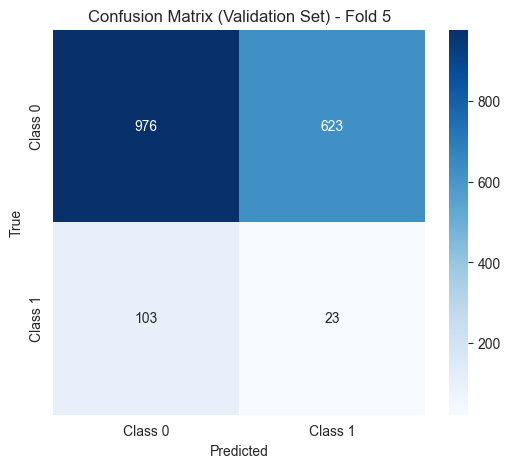

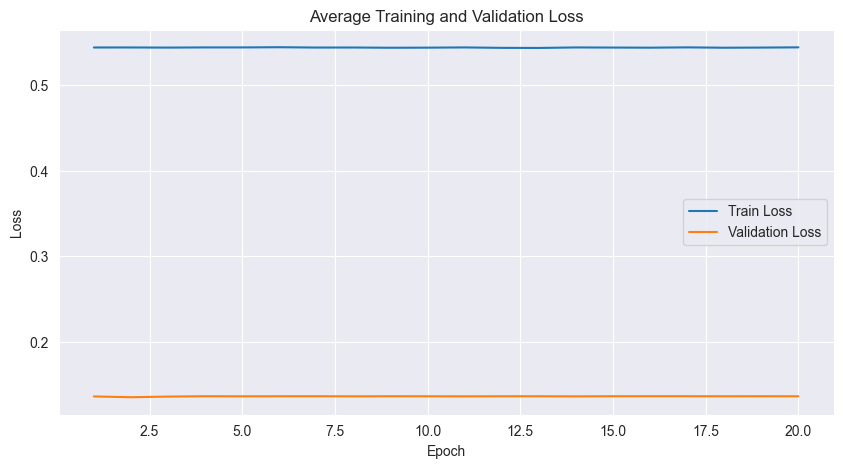

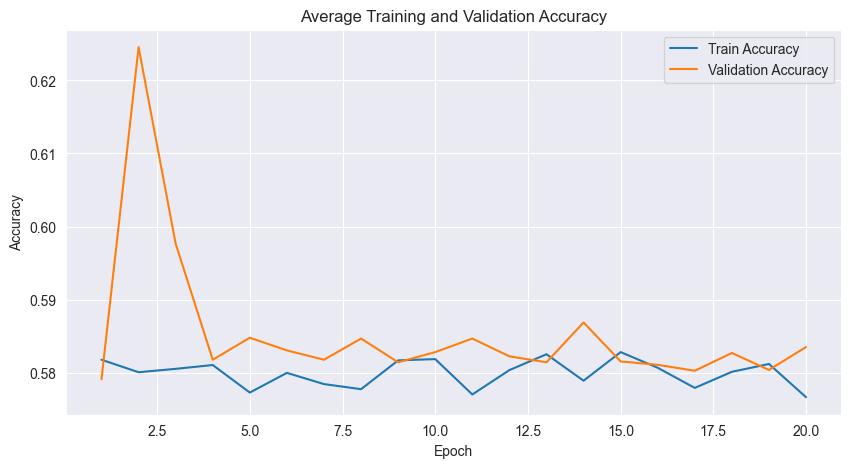

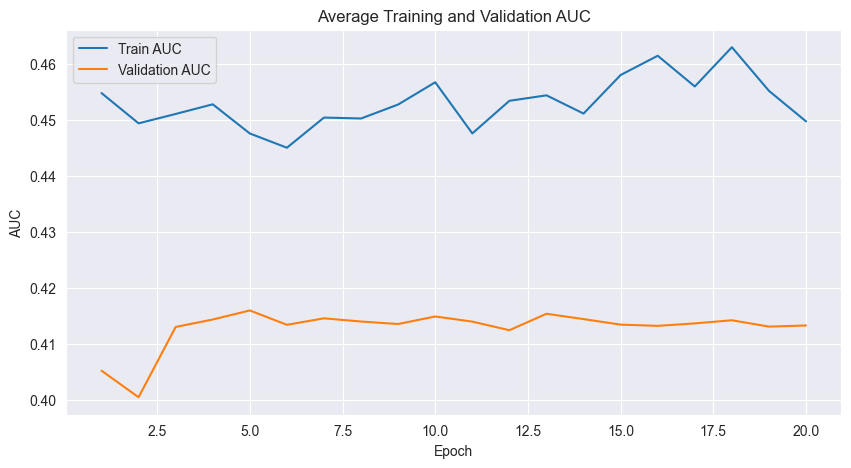

In [46]:
train_and_evaluate_cv(dataset,model_b0,criterion,optim,num_epoch,device,'effnet_Itt_2',weight_decay= 1e-4,n_splits=5)

In [56]:
path = 'effnet_Itt_2.pth'
eval(model_b0,path,device,test_loader)

/var/folders/d2/dsq0cfpj3wnf4dxf7hwsn5w00000gn/T/ipykernel_5172/3250025017.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))
Evalua

Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.97      0.99      0.98      2000
     Class 1       0.51      0.32      0.39        79

    accuracy                           0.96      2079
   macro avg       0.74      0.65      0.69      2079
weighted avg       0.96      0.96      0.96      2079

Test ROC-AUC: 0.8586


### Training WITH data augmentation & weighted loss (resnet-50) 

In [13]:
num_class_0 = 8000
num_class_1 = 629
pos_weight = torch.tensor([num_class_0 / num_class_1], dtype=torch.float32).to(device)

In [14]:
model = resnet50()
model.fc = nn.Linear(model.fc.in_features, 1)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
num_epoch = 20

In [79]:
dataset = datasets.ImageFolder('train_dataset_aug', transform=transform)

Fold 1/5


Epoch 1/20
Train Loss: 0.4345 | Train ROC-AUC: 0.9438 | Train Accuracy: 0.8931
Validation Loss: 0.1798 | Validation ROC-AUC: 0.8716 | Validation Accuracy: 0.8610


Epoch 2/20
Train Loss: 0.4314 | Train ROC-AUC: 0.9438 | Train Accuracy: 0.8994
Validation Loss: 0.2215 | Validation ROC-AUC: 0.8754 | Validation Accuracy: 0.9003


Epoch 3/20
Train Loss: 0.4348 | Train ROC-AUC: 0.9430 | Train Accuracy: 0.9009
Validation Loss: 0.2029 | Validation ROC-AUC: 0.8733 | Validation Accuracy: 0.8882


Epoch 4/20
Train Loss: 0.4482 | Train ROC-AUC: 0.9402 | Train Accuracy: 0.8983
Validation Loss: 0.2613 | Validation ROC-AUC: 0.8240 | Validation Accuracy: 0.9212


Epoch 5/20
Train Loss: 0.4314 | Train ROC-AUC: 0.9441 | Train Accuracy: 0.8973
Validation Loss: 0.2014 | Validation ROC-AUC: 0.8488 | Validation Accuracy: 0.8899


Epoch 6/20
Train Loss: 0.4534 | Train ROC-AUC: 0.9392 | Train Accuracy: 0.9033
Validation Loss: 0.1987 | Validation ROC-AUC: 0.8619 | Validation Accuracy: 0.8940


Epoch 7/20
Train Loss: 0.4269 | Train ROC-AUC: 0.9456 | Train Accuracy: 0.9006
Validation Loss: 0.3097 | Validation ROC-AUC: 0.8600 | Validation Accuracy: 0.9264


Epoch 8/20
Train Loss: 0.4288 | Train ROC-AUC: 0.9455 | Train Accuracy: 0.8978
Validation Loss: 0.2089 | Validation ROC-AUC: 0.8738 | Validation Accuracy: 0.9119


Epoch 9/20
Train Loss: 0.4212 | Train ROC-AUC: 0.9473 | Train Accuracy: 0.9044
Validation Loss: 0.1681 | Validation ROC-AUC: 0.8809 | Validation Accuracy: 0.8581


Epoch 10/20
Train Loss: 0.4184 | Train ROC-AUC: 0.9482 | Train Accuracy: 0.9009
Validation Loss: 0.2285 | Validation ROC-AUC: 0.8782 | Validation Accuracy: 0.9224


Epoch 11/20
Train Loss: 0.4086 | Train ROC-AUC: 0.9517 | Train Accuracy: 0.9070
Validation Loss: 0.2022 | Validation ROC-AUC: 0.8652 | Validation Accuracy: 0.9073


Epoch 12/20
Train Loss: 0.4081 | Train ROC-AUC: 0.9495 | Train Accuracy: 0.9099
Validation Loss: 0.2391 | Validation ROC-AUC: 0.8636 | Validation Accuracy: 0.9102


Epoch 13/20
Train Loss: 0.4009 | Train ROC-AUC: 0.9528 | Train Accuracy: 0.9078
Validation Loss: 0.2044 | Validation ROC-AUC: 0.8633 | Validation Accuracy: 0.8864


Epoch 14/20
Train Loss: 0.3753 | Train ROC-AUC: 0.9591 | Train Accuracy: 0.9068
Validation Loss: 0.2825 | Validation ROC-AUC: 0.8570 | Validation Accuracy: 0.9322


Epoch 15/20
Train Loss: 0.3928 | Train ROC-AUC: 0.9542 | Train Accuracy: 0.9136
Validation Loss: 0.1840 | Validation ROC-AUC: 0.8644 | Validation Accuracy: 0.8615


Epoch 16/20
Train Loss: 0.3614 | Train ROC-AUC: 0.9630 | Train Accuracy: 0.9122
Validation Loss: 0.2315 | Validation ROC-AUC: 0.8698 | Validation Accuracy: 0.9183


Epoch 17/20
Train Loss: 0.4009 | Train ROC-AUC: 0.9537 | Train Accuracy: 0.9028
Validation Loss: 0.2257 | Validation ROC-AUC: 0.8316 | Validation Accuracy: 0.8928


Epoch 18/20
Train Loss: 0.3682 | Train ROC-AUC: 0.9623 | Train Accuracy: 0.9094
Validation Loss: 0.1781 | Validation ROC-AUC: 0.8746 | Validation Accuracy: 0.8366


Epoch 19/20
Train Loss: 0.3639 | Train ROC-AUC: 0.9622 | Train Accuracy: 0.9131
Validation Loss: 0.2183 | Validation ROC-AUC: 0.8577 | Validation Accuracy: 0.8940


Epoch 20/20
Train Loss: 0.3406 | Train ROC-AUC: 0.9673 | Train Accuracy: 0.9186
Validation Loss: 0.2016 | Validation ROC-AUC: 0.8536 | Validation Accuracy: 0.8499


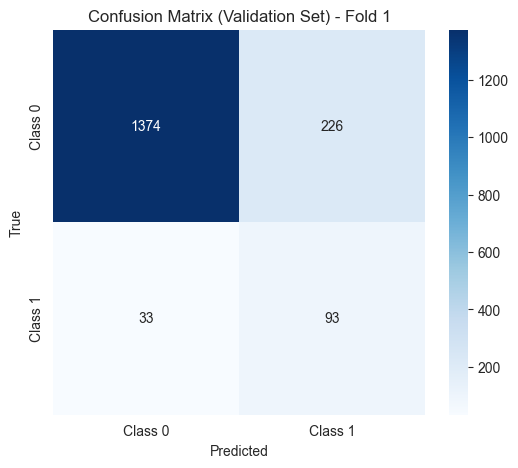

Fold 2/5


Epoch 1/20
Train Loss: 0.3920 | Train ROC-AUC: 0.9554 | Train Accuracy: 0.8964
Validation Loss: 0.1553 | Validation ROC-AUC: 0.9175 | Validation Accuracy: 0.9137


Epoch 2/20
Train Loss: 0.4147 | Train ROC-AUC: 0.9468 | Train Accuracy: 0.9099
Validation Loss: 0.1542 | Validation ROC-AUC: 0.9138 | Validation Accuracy: 0.9090


Epoch 3/20
Train Loss: 0.4096 | Train ROC-AUC: 0.9521 | Train Accuracy: 0.8970
Validation Loss: 0.1556 | Validation ROC-AUC: 0.9157 | Validation Accuracy: 0.9171


Epoch 4/20
Train Loss: 0.3887 | Train ROC-AUC: 0.9562 | Train Accuracy: 0.9061
Validation Loss: 0.2180 | Validation ROC-AUC: 0.9086 | Validation Accuracy: 0.9409


Epoch 5/20
Train Loss: 0.3835 | Train ROC-AUC: 0.9573 | Train Accuracy: 0.9090
Validation Loss: 0.2519 | Validation ROC-AUC: 0.8923 | Validation Accuracy: 0.9409


Epoch 6/20
Train Loss: 0.3843 | Train ROC-AUC: 0.9576 | Train Accuracy: 0.9081
Validation Loss: 0.1804 | Validation ROC-AUC: 0.9019 | Validation Accuracy: 0.9235


Epoch 7/20
Train Loss: 0.3700 | Train ROC-AUC: 0.9588 | Train Accuracy: 0.9167
Validation Loss: 0.1875 | Validation ROC-AUC: 0.9233 | Validation Accuracy: 0.9426


Epoch 8/20
Train Loss: 0.3818 | Train ROC-AUC: 0.9580 | Train Accuracy: 0.9094
Validation Loss: 0.2297 | Validation ROC-AUC: 0.9102 | Validation Accuracy: 0.9415


Epoch 9/20
Train Loss: 0.3747 | Train ROC-AUC: 0.9594 | Train Accuracy: 0.9126
Validation Loss: 0.1547 | Validation ROC-AUC: 0.9137 | Validation Accuracy: 0.9096


Epoch 10/20
Train Loss: 0.3556 | Train ROC-AUC: 0.9646 | Train Accuracy: 0.9107
Validation Loss: 0.1675 | Validation ROC-AUC: 0.9048 | Validation Accuracy: 0.9154


Epoch 11/20
Train Loss: 0.3653 | Train ROC-AUC: 0.9627 | Train Accuracy: 0.9100
Validation Loss: 0.2017 | Validation ROC-AUC: 0.8898 | Validation Accuracy: 0.9229


Epoch 12/20
Train Loss: 0.3497 | Train ROC-AUC: 0.9639 | Train Accuracy: 0.9148
Validation Loss: 0.1445 | Validation ROC-AUC: 0.9135 | Validation Accuracy: 0.9027


Epoch 13/20
Train Loss: 0.3425 | Train ROC-AUC: 0.9671 | Train Accuracy: 0.9145
Validation Loss: 0.1807 | Validation ROC-AUC: 0.9150 | Validation Accuracy: 0.9374


Epoch 14/20
Train Loss: 0.3459 | Train ROC-AUC: 0.9660 | Train Accuracy: 0.9178
Validation Loss: 0.1693 | Validation ROC-AUC: 0.9093 | Validation Accuracy: 0.9183


Epoch 15/20
Train Loss: 0.3182 | Train ROC-AUC: 0.9721 | Train Accuracy: 0.9178
Validation Loss: 0.1684 | Validation ROC-AUC: 0.8973 | Validation Accuracy: 0.8853


Epoch 16/20
Train Loss: 0.3272 | Train ROC-AUC: 0.9689 | Train Accuracy: 0.9200
Validation Loss: 0.1423 | Validation ROC-AUC: 0.9152 | Validation Accuracy: 0.8696


Epoch 17/20
Train Loss: 0.3068 | Train ROC-AUC: 0.9737 | Train Accuracy: 0.9229
Validation Loss: 0.2969 | Validation ROC-AUC: 0.8936 | Validation Accuracy: 0.9403


Epoch 18/20
Train Loss: 0.3219 | Train ROC-AUC: 0.9701 | Train Accuracy: 0.9197
Validation Loss: 0.1839 | Validation ROC-AUC: 0.9144 | Validation Accuracy: 0.9293


Epoch 19/20
Train Loss: 0.3116 | Train ROC-AUC: 0.9725 | Train Accuracy: 0.9244
Validation Loss: 0.1639 | Validation ROC-AUC: 0.8979 | Validation Accuracy: 0.8436


Epoch 20/20
Train Loss: 0.2923 | Train ROC-AUC: 0.9758 | Train Accuracy: 0.9251
Validation Loss: 0.1939 | Validation ROC-AUC: 0.9078 | Validation Accuracy: 0.9247


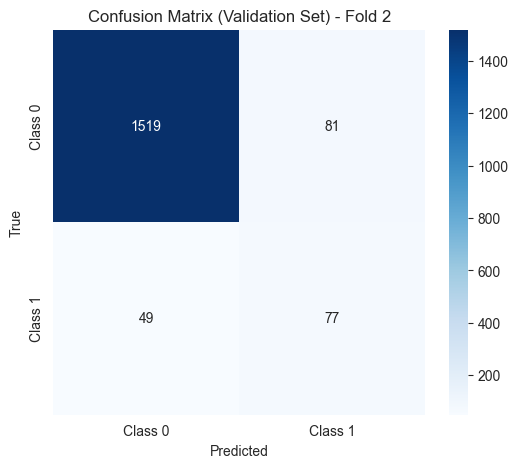

Fold 3/5


Epoch 1/20
Train Loss: 0.4005 | Train ROC-AUC: 0.9556 | Train Accuracy: 0.8944
Validation Loss: 0.0875 | Validation ROC-AUC: 0.9691 | Validation Accuracy: 0.8974


Epoch 2/20
Train Loss: 0.3894 | Train ROC-AUC: 0.9578 | Train Accuracy: 0.8994
Validation Loss: 0.0770 | Validation ROC-AUC: 0.9743 | Validation Accuracy: 0.9200


Epoch 3/20
Train Loss: 0.3380 | Train ROC-AUC: 0.9683 | Train Accuracy: 0.9122
Validation Loss: 0.0953 | Validation ROC-AUC: 0.9624 | Validation Accuracy: 0.9154


Epoch 4/20
Train Loss: 0.3710 | Train ROC-AUC: 0.9612 | Train Accuracy: 0.9018
Validation Loss: 0.0949 | Validation ROC-AUC: 0.9649 | Validation Accuracy: 0.9409


Epoch 5/20
Train Loss: 0.3377 | Train ROC-AUC: 0.9680 | Train Accuracy: 0.9074
Validation Loss: 0.0935 | Validation ROC-AUC: 0.9657 | Validation Accuracy: 0.9304


Epoch 6/20
Train Loss: 0.3327 | Train ROC-AUC: 0.9693 | Train Accuracy: 0.9125
Validation Loss: 0.0823 | Validation ROC-AUC: 0.9708 | Validation Accuracy: 0.9252


Epoch 7/20
Train Loss: 0.3286 | Train ROC-AUC: 0.9698 | Train Accuracy: 0.9145
Validation Loss: 0.0903 | Validation ROC-AUC: 0.9687 | Validation Accuracy: 0.9362


Epoch 8/20
Train Loss: 0.3061 | Train ROC-AUC: 0.9741 | Train Accuracy: 0.9158
Validation Loss: 0.0900 | Validation ROC-AUC: 0.9692 | Validation Accuracy: 0.9316


Epoch 9/20
Train Loss: 0.3203 | Train ROC-AUC: 0.9716 | Train Accuracy: 0.9118
Validation Loss: 0.0942 | Validation ROC-AUC: 0.9627 | Validation Accuracy: 0.8980


Epoch 10/20
Train Loss: 0.3219 | Train ROC-AUC: 0.9717 | Train Accuracy: 0.9122
Validation Loss: 0.0958 | Validation ROC-AUC: 0.9593 | Validation Accuracy: 0.9032


Epoch 11/20
Train Loss: 0.2901 | Train ROC-AUC: 0.9768 | Train Accuracy: 0.9196
Validation Loss: 0.1009 | Validation ROC-AUC: 0.9681 | Validation Accuracy: 0.9397


Epoch 12/20
Train Loss: 0.2728 | Train ROC-AUC: 0.9796 | Train Accuracy: 0.9228
Validation Loss: 0.1065 | Validation ROC-AUC: 0.9554 | Validation Accuracy: 0.8933


Epoch 13/20
Train Loss: 0.2918 | Train ROC-AUC: 0.9763 | Train Accuracy: 0.9190
Validation Loss: 0.0987 | Validation ROC-AUC: 0.9626 | Validation Accuracy: 0.9293


Epoch 14/20
Train Loss: 0.2690 | Train ROC-AUC: 0.9803 | Train Accuracy: 0.9226
Validation Loss: 0.1069 | Validation ROC-AUC: 0.9596 | Validation Accuracy: 0.9287


Epoch 15/20
Train Loss: 0.2437 | Train ROC-AUC: 0.9834 | Train Accuracy: 0.9313
Validation Loss: 0.0996 | Validation ROC-AUC: 0.9614 | Validation Accuracy: 0.8899


Epoch 16/20
Train Loss: 0.2529 | Train ROC-AUC: 0.9824 | Train Accuracy: 0.9277
Validation Loss: 0.1040 | Validation ROC-AUC: 0.9608 | Validation Accuracy: 0.9275


Epoch 17/20
Train Loss: 0.2191 | Train ROC-AUC: 0.9865 | Train Accuracy: 0.9383
Validation Loss: 0.1176 | Validation ROC-AUC: 0.9565 | Validation Accuracy: 0.9043


Epoch 18/20
Train Loss: 0.2173 | Train ROC-AUC: 0.9865 | Train Accuracy: 0.9390
Validation Loss: 0.1080 | Validation ROC-AUC: 0.9593 | Validation Accuracy: 0.9200


Epoch 19/20
Train Loss: 0.2012 | Train ROC-AUC: 0.9886 | Train Accuracy: 0.9461
Validation Loss: 0.1076 | Validation ROC-AUC: 0.9643 | Validation Accuracy: 0.8586


Epoch 20/20
Train Loss: 0.2209 | Train ROC-AUC: 0.9863 | Train Accuracy: 0.9363
Validation Loss: 0.1568 | Validation ROC-AUC: 0.9497 | Validation Accuracy: 0.9496


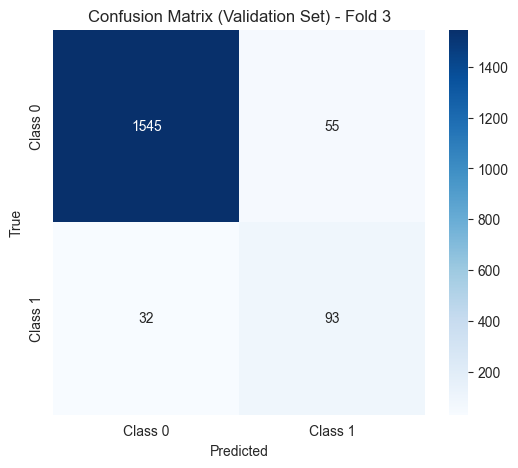

Fold 4/5


Epoch 1/20
Train Loss: 0.3266 | Train ROC-AUC: 0.9704 | Train Accuracy: 0.9134
Validation Loss: 0.0511 | Validation ROC-AUC: 0.9966 | Validation Accuracy: 0.8991


Epoch 2/20
Train Loss: 0.2735 | Train ROC-AUC: 0.9787 | Train Accuracy: 0.9228
Validation Loss: 0.0368 | Validation ROC-AUC: 0.9995 | Validation Accuracy: 0.9235


Epoch 3/20
Train Loss: 0.2631 | Train ROC-AUC: 0.9803 | Train Accuracy: 0.9297
Validation Loss: 0.0374 | Validation ROC-AUC: 0.9988 | Validation Accuracy: 0.9270


Epoch 4/20
Train Loss: 0.2155 | Train ROC-AUC: 0.9867 | Train Accuracy: 0.9371
Validation Loss: 0.0284 | Validation ROC-AUC: 0.9972 | Validation Accuracy: 0.9536


Epoch 5/20
Train Loss: 0.2208 | Train ROC-AUC: 0.9862 | Train Accuracy: 0.9323
Validation Loss: 0.0356 | Validation ROC-AUC: 0.9945 | Validation Accuracy: 0.9583


Epoch 6/20
Train Loss: 0.2581 | Train ROC-AUC: 0.9812 | Train Accuracy: 0.9287
Validation Loss: 0.0566 | Validation ROC-AUC: 0.9973 | Validation Accuracy: 0.8841


Epoch 7/20
Train Loss: 0.2004 | Train ROC-AUC: 0.9882 | Train Accuracy: 0.9425
Validation Loss: 0.0262 | Validation ROC-AUC: 0.9989 | Validation Accuracy: 0.9507


Epoch 8/20
Train Loss: 0.1900 | Train ROC-AUC: 0.9890 | Train Accuracy: 0.9432
Validation Loss: 0.0203 | Validation ROC-AUC: 0.9996 | Validation Accuracy: 0.9617


Epoch 9/20
Train Loss: 0.1868 | Train ROC-AUC: 0.9895 | Train Accuracy: 0.9468
Validation Loss: 0.0453 | Validation ROC-AUC: 0.9912 | Validation Accuracy: 0.9681


Epoch 10/20
Train Loss: 0.2220 | Train ROC-AUC: 0.9860 | Train Accuracy: 0.9364
Validation Loss: 0.0404 | Validation ROC-AUC: 0.9974 | Validation Accuracy: 0.9241


Epoch 11/20
Train Loss: 0.1835 | Train ROC-AUC: 0.9900 | Train Accuracy: 0.9525
Validation Loss: 0.0526 | Validation ROC-AUC: 0.9975 | Validation Accuracy: 0.9014


Epoch 12/20
Train Loss: 0.2130 | Train ROC-AUC: 0.9868 | Train Accuracy: 0.9370
Validation Loss: 0.0190 | Validation ROC-AUC: 0.9992 | Validation Accuracy: 0.9687


Epoch 13/20
Train Loss: 0.1755 | Train ROC-AUC: 0.9909 | Train Accuracy: 0.9502
Validation Loss: 0.0215 | Validation ROC-AUC: 0.9990 | Validation Accuracy: 0.9629


Epoch 14/20
Train Loss: 0.2011 | Train ROC-AUC: 0.9883 | Train Accuracy: 0.9436
Validation Loss: 0.0383 | Validation ROC-AUC: 0.9950 | Validation Accuracy: 0.9467


Epoch 15/20
Train Loss: 0.1669 | Train ROC-AUC: 0.9916 | Train Accuracy: 0.9513
Validation Loss: 0.0625 | Validation ROC-AUC: 0.9963 | Validation Accuracy: 0.8980


Epoch 16/20
Train Loss: 0.2010 | Train ROC-AUC: 0.9884 | Train Accuracy: 0.9413
Validation Loss: 0.0423 | Validation ROC-AUC: 0.9992 | Validation Accuracy: 0.9154


Epoch 17/20
Train Loss: 0.1466 | Train ROC-AUC: 0.9936 | Train Accuracy: 0.9567
Validation Loss: 0.0244 | Validation ROC-AUC: 0.9975 | Validation Accuracy: 0.9745


Epoch 18/20
Train Loss: 0.1506 | Train ROC-AUC: 0.9932 | Train Accuracy: 0.9584
Validation Loss: 0.0161 | Validation ROC-AUC: 0.9995 | Validation Accuracy: 0.9728


Epoch 19/20
Train Loss: 0.1430 | Train ROC-AUC: 0.9935 | Train Accuracy: 0.9593
Validation Loss: 0.0430 | Validation ROC-AUC: 0.9974 | Validation Accuracy: 0.9299


Epoch 20/20
Train Loss: 0.1635 | Train ROC-AUC: 0.9920 | Train Accuracy: 0.9523
Validation Loss: 0.0133 | Validation ROC-AUC: 0.9994 | Validation Accuracy: 0.9780


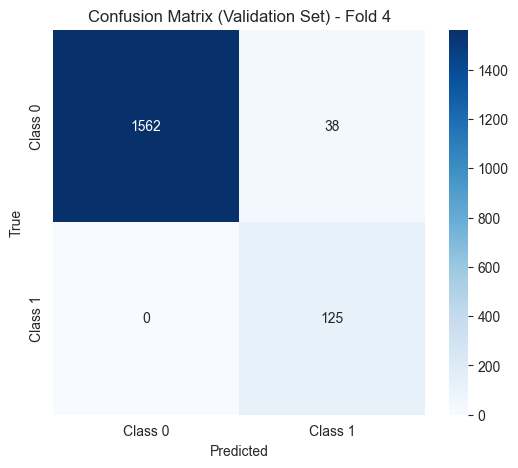

Fold 5/5


Epoch 1/20
Train Loss: 0.1799 | Train ROC-AUC: 0.9906 | Train Accuracy: 0.9483
Validation Loss: 0.0220 | Validation ROC-AUC: 0.9991 | Validation Accuracy: 0.9617


Epoch 2/20
Train Loss: 0.1359 | Train ROC-AUC: 0.9943 | Train Accuracy: 0.9609
Validation Loss: 0.0177 | Validation ROC-AUC: 0.9984 | Validation Accuracy: 0.9803


Epoch 3/20
Train Loss: 0.1055 | Train ROC-AUC: 0.9963 | Train Accuracy: 0.9728
Validation Loss: 0.0386 | Validation ROC-AUC: 0.9949 | Validation Accuracy: 0.9467


Epoch 4/20
Train Loss: 0.1371 | Train ROC-AUC: 0.9941 | Train Accuracy: 0.9603
Validation Loss: 0.0316 | Validation ROC-AUC: 0.9990 | Validation Accuracy: 0.9414


Epoch 5/20
Train Loss: 0.1419 | Train ROC-AUC: 0.9940 | Train Accuracy: 0.9603
Validation Loss: 0.0135 | Validation ROC-AUC: 0.9994 | Validation Accuracy: 0.9809


Epoch 6/20
Train Loss: 0.1158 | Train ROC-AUC: 0.9958 | Train Accuracy: 0.9642
Validation Loss: 0.0430 | Validation ROC-AUC: 0.9980 | Validation Accuracy: 0.9200


Epoch 7/20
Train Loss: 0.1755 | Train ROC-AUC: 0.9906 | Train Accuracy: 0.9522
Validation Loss: 0.0362 | Validation ROC-AUC: 0.9984 | Validation Accuracy: 0.9351


Epoch 8/20
Train Loss: 0.1102 | Train ROC-AUC: 0.9961 | Train Accuracy: 0.9699
Validation Loss: 0.0586 | Validation ROC-AUC: 0.9971 | Validation Accuracy: 0.8991


Epoch 9/20
Train Loss: 0.1128 | Train ROC-AUC: 0.9959 | Train Accuracy: 0.9658
Validation Loss: 0.0385 | Validation ROC-AUC: 0.9984 | Validation Accuracy: 0.9333


Epoch 10/20
Train Loss: 0.1704 | Train ROC-AUC: 0.9917 | Train Accuracy: 0.9515
Validation Loss: 0.0275 | Validation ROC-AUC: 0.9973 | Validation Accuracy: 0.9588


Epoch 11/20
Train Loss: 0.1549 | Train ROC-AUC: 0.9932 | Train Accuracy: 0.9549
Validation Loss: 0.0237 | Validation ROC-AUC: 0.9973 | Validation Accuracy: 0.9687


Epoch 12/20
Train Loss: 0.1211 | Train ROC-AUC: 0.9956 | Train Accuracy: 0.9635
Validation Loss: 0.0206 | Validation ROC-AUC: 0.9985 | Validation Accuracy: 0.9664


Epoch 13/20
Train Loss: 0.0868 | Train ROC-AUC: 0.9976 | Train Accuracy: 0.9752
Validation Loss: 0.0169 | Validation ROC-AUC: 0.9996 | Validation Accuracy: 0.9670


Epoch 14/20
Train Loss: 0.1142 | Train ROC-AUC: 0.9958 | Train Accuracy: 0.9660
Validation Loss: 0.0411 | Validation ROC-AUC: 0.9966 | Validation Accuracy: 0.9345


Epoch 15/20
Train Loss: 0.1263 | Train ROC-AUC: 0.9952 | Train Accuracy: 0.9657
Validation Loss: 0.0206 | Validation ROC-AUC: 0.9990 | Validation Accuracy: 0.9658


Epoch 16/20
Train Loss: 0.1045 | Train ROC-AUC: 0.9966 | Train Accuracy: 0.9731
Validation Loss: 0.0412 | Validation ROC-AUC: 0.9976 | Validation Accuracy: 0.9322


Epoch 17/20
Train Loss: 0.1100 | Train ROC-AUC: 0.9963 | Train Accuracy: 0.9690
Validation Loss: 0.0222 | Validation ROC-AUC: 0.9982 | Validation Accuracy: 0.9681


Epoch 18/20
Train Loss: 0.1140 | Train ROC-AUC: 0.9961 | Train Accuracy: 0.9661
Validation Loss: 0.0388 | Validation ROC-AUC: 0.9953 | Validation Accuracy: 0.9530


Epoch 19/20
Train Loss: 0.1128 | Train ROC-AUC: 0.9963 | Train Accuracy: 0.9665
Validation Loss: 0.0333 | Validation ROC-AUC: 0.9976 | Validation Accuracy: 0.9501


Epoch 20/20
Train Loss: 0.0619 | Train ROC-AUC: 0.9989 | Train Accuracy: 0.9815
Validation Loss: 0.0191 | Validation ROC-AUC: 0.9984 | Validation Accuracy: 0.9797


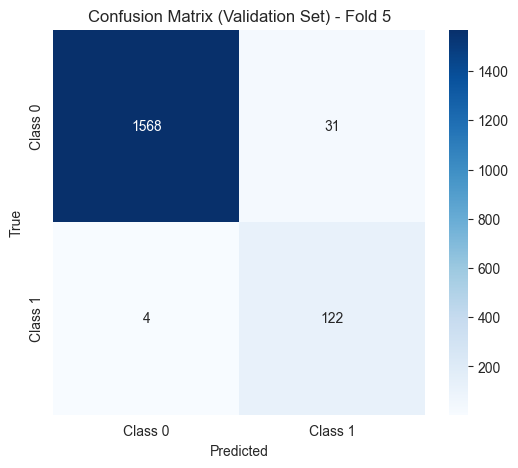

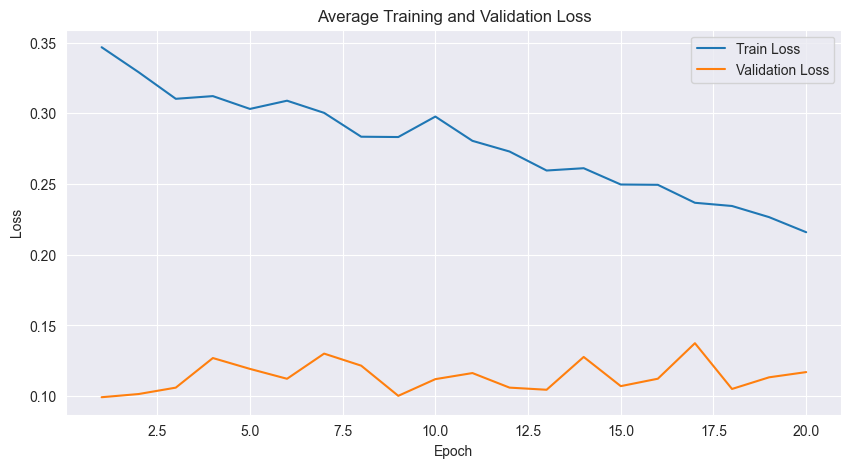

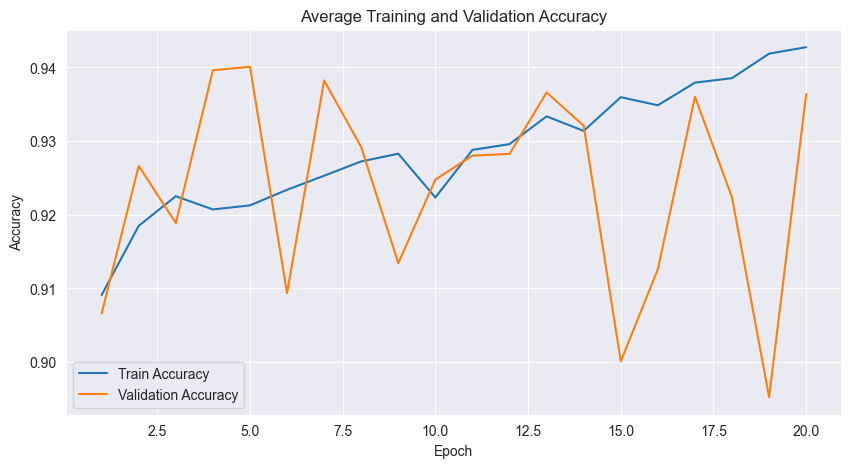

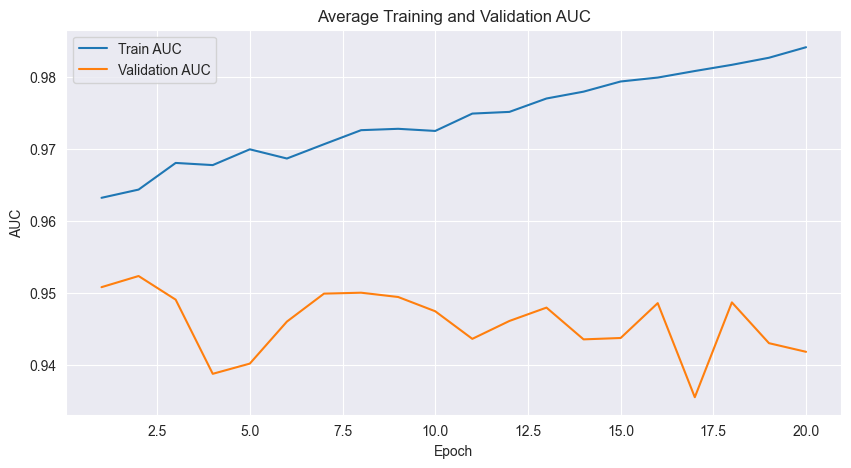

In [81]:
train_and_evaluate_cv(dataset,model,criterion,optim,num_epoch,device,'resnet_Itt_3.pth',weight_decay= 1e-4,n_splits=5)

### Efficient Net with Data augmentation & weight loss

In [47]:
model_b0 = EfficientNet.from_pretrained('efficientnet-b0')
in_features = model_b0._fc.in_features
model_b0._fc = nn.Linear(in_features, 1)
print(device)
model_b0.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
dataset = datasets.ImageFolder('train_dataset_aug', transform=transform)
num_epoch = 20

Loaded pretrained weights for efficientnet-b0
mps


Fold 1/5


Epoch 1/20
Train Loss: 1.5614 | Train ROC-AUC: 0.3772 | Train Accuracy: 0.2574
Validation Loss: 0.3923 | Validation ROC-AUC: 0.5091 | Validation Accuracy: 0.4177


Epoch 2/20
Train Loss: 1.5638 | Train ROC-AUC: 0.3713 | Train Accuracy: 0.2510
Validation Loss: 0.3683 | Validation ROC-AUC: 0.5868 | Validation Accuracy: 0.2155


Epoch 3/20
Train Loss: 1.5655 | Train ROC-AUC: 0.3652 | Train Accuracy: 0.2533
Validation Loss: 0.3786 | Validation ROC-AUC: 0.5019 | Validation Accuracy: 0.2943


Epoch 4/20
Train Loss: 1.5643 | Train ROC-AUC: 0.3682 | Train Accuracy: 0.2589
Validation Loss: 0.3774 | Validation ROC-AUC: 0.5048 | Validation Accuracy: 0.2740


Epoch 5/20
Train Loss: 1.5616 | Train ROC-AUC: 0.3781 | Train Accuracy: 0.2530
Validation Loss: 0.3771 | Validation ROC-AUC: 0.5041 | Validation Accuracy: 0.2648


Epoch 6/20
Train Loss: 1.5531 | Train ROC-AUC: 0.3893 | Train Accuracy: 0.2562
Validation Loss: 0.3771 | Validation ROC-AUC: 0.5032 | Validation Accuracy: 0.2636


Epoch 7/20
Train Loss: 1.5574 | Train ROC-AUC: 0.3827 | Train Accuracy: 0.2610
Validation Loss: 0.3769 | Validation ROC-AUC: 0.5079 | Validation Accuracy: 0.2711


Epoch 8/20
Train Loss: 1.5591 | Train ROC-AUC: 0.3774 | Train Accuracy: 0.2584
Validation Loss: 0.3769 | Validation ROC-AUC: 0.5054 | Validation Accuracy: 0.2683


Epoch 9/20
Train Loss: 1.5646 | Train ROC-AUC: 0.3738 | Train Accuracy: 0.2600
Validation Loss: 0.3771 | Validation ROC-AUC: 0.5043 | Validation Accuracy: 0.2700


Epoch 10/20
Train Loss: 1.5641 | Train ROC-AUC: 0.3744 | Train Accuracy: 0.2543
Validation Loss: 0.3769 | Validation ROC-AUC: 0.5051 | Validation Accuracy: 0.2642


Epoch 11/20
Train Loss: 1.5599 | Train ROC-AUC: 0.3757 | Train Accuracy: 0.2624
Validation Loss: 0.3771 | Validation ROC-AUC: 0.5041 | Validation Accuracy: 0.2711


Epoch 12/20
Train Loss: 1.5625 | Train ROC-AUC: 0.3749 | Train Accuracy: 0.2527
Validation Loss: 0.3774 | Validation ROC-AUC: 0.5029 | Validation Accuracy: 0.2711


Epoch 13/20
Train Loss: 1.5675 | Train ROC-AUC: 0.3657 | Train Accuracy: 0.2660
Validation Loss: 0.3772 | Validation ROC-AUC: 0.5044 | Validation Accuracy: 0.2700


Epoch 14/20
Train Loss: 1.5559 | Train ROC-AUC: 0.3868 | Train Accuracy: 0.2558
Validation Loss: 0.3770 | Validation ROC-AUC: 0.5061 | Validation Accuracy: 0.2723


Epoch 15/20
Train Loss: 1.5643 | Train ROC-AUC: 0.3699 | Train Accuracy: 0.2545
Validation Loss: 0.3768 | Validation ROC-AUC: 0.5076 | Validation Accuracy: 0.2654


Epoch 16/20
Train Loss: 1.5670 | Train ROC-AUC: 0.3673 | Train Accuracy: 0.2595
Validation Loss: 0.3769 | Validation ROC-AUC: 0.5059 | Validation Accuracy: 0.2694


Epoch 17/20
Train Loss: 1.5575 | Train ROC-AUC: 0.3866 | Train Accuracy: 0.2633
Validation Loss: 0.3774 | Validation ROC-AUC: 0.5031 | Validation Accuracy: 0.2711


Epoch 18/20
Train Loss: 1.5631 | Train ROC-AUC: 0.3735 | Train Accuracy: 0.2611
Validation Loss: 0.3772 | Validation ROC-AUC: 0.5047 | Validation Accuracy: 0.2740


Epoch 19/20
Train Loss: 1.5639 | Train ROC-AUC: 0.3746 | Train Accuracy: 0.2604
Validation Loss: 0.3768 | Validation ROC-AUC: 0.5047 | Validation Accuracy: 0.2625


Epoch 20/20
Train Loss: 1.5675 | Train ROC-AUC: 0.3664 | Train Accuracy: 0.2504
Validation Loss: 0.3771 | Validation ROC-AUC: 0.5041 | Validation Accuracy: 0.2700


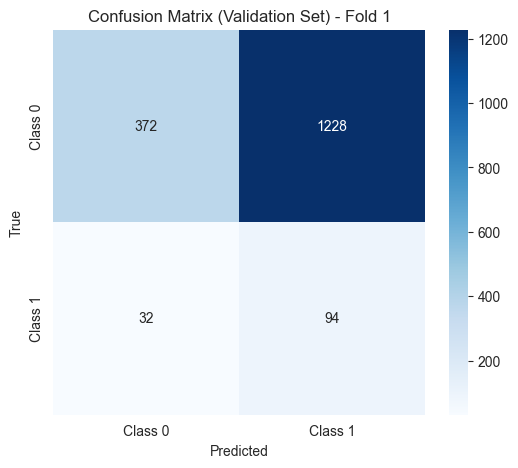

Fold 2/5


Epoch 1/20
Train Loss: 1.5655 | Train ROC-AUC: 0.3633 | Train Accuracy: 0.2582
Validation Loss: 0.3752 | Validation ROC-AUC: 0.5239 | Validation Accuracy: 0.2798


Epoch 2/20
Train Loss: 1.5606 | Train ROC-AUC: 0.3775 | Train Accuracy: 0.2572
Validation Loss: 0.3750 | Validation ROC-AUC: 0.5248 | Validation Accuracy: 0.2810


Epoch 3/20
Train Loss: 1.5600 | Train ROC-AUC: 0.3846 | Train Accuracy: 0.2611
Validation Loss: 0.3753 | Validation ROC-AUC: 0.5255 | Validation Accuracy: 0.2862


Epoch 4/20
Train Loss: 1.5605 | Train ROC-AUC: 0.3848 | Train Accuracy: 0.2597
Validation Loss: 0.3751 | Validation ROC-AUC: 0.5273 | Validation Accuracy: 0.2885


Epoch 5/20
Train Loss: 1.5682 | Train ROC-AUC: 0.3614 | Train Accuracy: 0.2562
Validation Loss: 0.3751 | Validation ROC-AUC: 0.5259 | Validation Accuracy: 0.2822


Epoch 6/20
Train Loss: 1.5624 | Train ROC-AUC: 0.3769 | Train Accuracy: 0.2555
Validation Loss: 0.3749 | Validation ROC-AUC: 0.5274 | Validation Accuracy: 0.2793


Epoch 7/20
Train Loss: 1.5634 | Train ROC-AUC: 0.3784 | Train Accuracy: 0.2601
Validation Loss: 0.3751 | Validation ROC-AUC: 0.5270 | Validation Accuracy: 0.2874


Epoch 8/20
Train Loss: 1.5696 | Train ROC-AUC: 0.3597 | Train Accuracy: 0.2516
Validation Loss: 0.3751 | Validation ROC-AUC: 0.5250 | Validation Accuracy: 0.2816


Epoch 9/20
Train Loss: 1.5632 | Train ROC-AUC: 0.3749 | Train Accuracy: 0.2556
Validation Loss: 0.3751 | Validation ROC-AUC: 0.5256 | Validation Accuracy: 0.2827


Epoch 10/20
Train Loss: 1.5634 | Train ROC-AUC: 0.3725 | Train Accuracy: 0.2542
Validation Loss: 0.3751 | Validation ROC-AUC: 0.5254 | Validation Accuracy: 0.2822


Epoch 11/20
Train Loss: 1.5718 | Train ROC-AUC: 0.3554 | Train Accuracy: 0.2546
Validation Loss: 0.3749 | Validation ROC-AUC: 0.5259 | Validation Accuracy: 0.2798


Epoch 12/20
Train Loss: 1.5701 | Train ROC-AUC: 0.3585 | Train Accuracy: 0.2542
Validation Loss: 0.3750 | Validation ROC-AUC: 0.5271 | Validation Accuracy: 0.2827


Epoch 13/20
Train Loss: 1.5706 | Train ROC-AUC: 0.3621 | Train Accuracy: 0.2578
Validation Loss: 0.3751 | Validation ROC-AUC: 0.5251 | Validation Accuracy: 0.2810


Epoch 14/20
Train Loss: 1.5597 | Train ROC-AUC: 0.3790 | Train Accuracy: 0.2575
Validation Loss: 0.3750 | Validation ROC-AUC: 0.5271 | Validation Accuracy: 0.2868


Epoch 15/20
Train Loss: 1.5587 | Train ROC-AUC: 0.3823 | Train Accuracy: 0.2624
Validation Loss: 0.3751 | Validation ROC-AUC: 0.5269 | Validation Accuracy: 0.2879


Epoch 16/20
Train Loss: 1.5700 | Train ROC-AUC: 0.3642 | Train Accuracy: 0.2581
Validation Loss: 0.3749 | Validation ROC-AUC: 0.5258 | Validation Accuracy: 0.2787


Epoch 17/20
Train Loss: 1.5656 | Train ROC-AUC: 0.3681 | Train Accuracy: 0.2574
Validation Loss: 0.3750 | Validation ROC-AUC: 0.5258 | Validation Accuracy: 0.2804


Epoch 18/20
Train Loss: 1.5662 | Train ROC-AUC: 0.3643 | Train Accuracy: 0.2550
Validation Loss: 0.3749 | Validation ROC-AUC: 0.5265 | Validation Accuracy: 0.2822


Epoch 19/20
Train Loss: 1.5659 | Train ROC-AUC: 0.3717 | Train Accuracy: 0.2578
Validation Loss: 0.3753 | Validation ROC-AUC: 0.5239 | Validation Accuracy: 0.2833


Epoch 20/20
Train Loss: 1.5662 | Train ROC-AUC: 0.3633 | Train Accuracy: 0.2566
Validation Loss: 0.3749 | Validation ROC-AUC: 0.5265 | Validation Accuracy: 0.2810


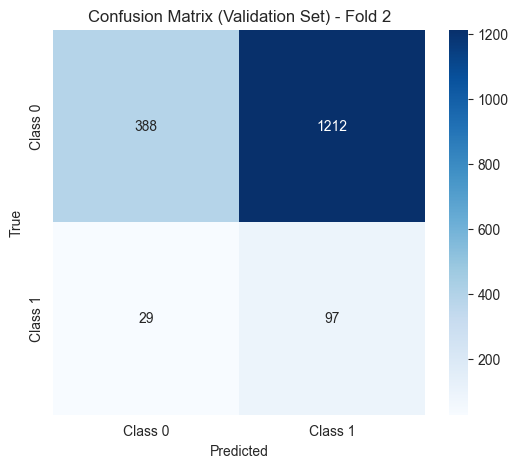

Fold 3/5


Epoch 1/20
Train Loss: 1.5527 | Train ROC-AUC: 0.3974 | Train Accuracy: 0.2615
Validation Loss: 0.3893 | Validation ROC-AUC: 0.3751 | Validation Accuracy: 0.2528


Epoch 2/20
Train Loss: 1.5503 | Train ROC-AUC: 0.4045 | Train Accuracy: 0.2599
Validation Loss: 0.3893 | Validation ROC-AUC: 0.3750 | Validation Accuracy: 0.2557


Epoch 3/20
Train Loss: 1.5577 | Train ROC-AUC: 0.3913 | Train Accuracy: 0.2605
Validation Loss: 0.3898 | Validation ROC-AUC: 0.3713 | Validation Accuracy: 0.2510


Epoch 4/20
Train Loss: 1.5510 | Train ROC-AUC: 0.4104 | Train Accuracy: 0.2643
Validation Loss: 0.3897 | Validation ROC-AUC: 0.3737 | Validation Accuracy: 0.2568


Epoch 5/20
Train Loss: 1.5532 | Train ROC-AUC: 0.4033 | Train Accuracy: 0.2647
Validation Loss: 0.3891 | Validation ROC-AUC: 0.3742 | Validation Accuracy: 0.2464


Epoch 6/20
Train Loss: 1.5557 | Train ROC-AUC: 0.3917 | Train Accuracy: 0.2644
Validation Loss: 0.3892 | Validation ROC-AUC: 0.3753 | Validation Accuracy: 0.2545


Epoch 7/20
Train Loss: 1.5503 | Train ROC-AUC: 0.4063 | Train Accuracy: 0.2692
Validation Loss: 0.3896 | Validation ROC-AUC: 0.3730 | Validation Accuracy: 0.2522


Epoch 8/20
Train Loss: 1.5488 | Train ROC-AUC: 0.4030 | Train Accuracy: 0.2564
Validation Loss: 0.3894 | Validation ROC-AUC: 0.3738 | Validation Accuracy: 0.2493


Epoch 9/20
Train Loss: 1.5511 | Train ROC-AUC: 0.4044 | Train Accuracy: 0.2559
Validation Loss: 0.3895 | Validation ROC-AUC: 0.3740 | Validation Accuracy: 0.2574


Epoch 10/20
Train Loss: 1.5517 | Train ROC-AUC: 0.4057 | Train Accuracy: 0.2666
Validation Loss: 0.3893 | Validation ROC-AUC: 0.3746 | Validation Accuracy: 0.2580


Epoch 11/20
Train Loss: 1.5517 | Train ROC-AUC: 0.4038 | Train Accuracy: 0.2535
Validation Loss: 0.3897 | Validation ROC-AUC: 0.3715 | Validation Accuracy: 0.2499


Epoch 12/20
Train Loss: 1.5472 | Train ROC-AUC: 0.4146 | Train Accuracy: 0.2641
Validation Loss: 0.3893 | Validation ROC-AUC: 0.3735 | Validation Accuracy: 0.2533


Epoch 13/20
Train Loss: 1.5554 | Train ROC-AUC: 0.3982 | Train Accuracy: 0.2588
Validation Loss: 0.3895 | Validation ROC-AUC: 0.3728 | Validation Accuracy: 0.2504


Epoch 14/20
Train Loss: 1.5485 | Train ROC-AUC: 0.4160 | Train Accuracy: 0.2664
Validation Loss: 0.3894 | Validation ROC-AUC: 0.3738 | Validation Accuracy: 0.2510


Epoch 15/20
Train Loss: 1.5541 | Train ROC-AUC: 0.3966 | Train Accuracy: 0.2606
Validation Loss: 0.3890 | Validation ROC-AUC: 0.3756 | Validation Accuracy: 0.2528


Epoch 16/20
Train Loss: 1.5585 | Train ROC-AUC: 0.3893 | Train Accuracy: 0.2593
Validation Loss: 0.3893 | Validation ROC-AUC: 0.3736 | Validation Accuracy: 0.2516


Epoch 17/20
Train Loss: 1.5487 | Train ROC-AUC: 0.4112 | Train Accuracy: 0.2644
Validation Loss: 0.3893 | Validation ROC-AUC: 0.3749 | Validation Accuracy: 0.2510


Epoch 18/20
Train Loss: 1.5562 | Train ROC-AUC: 0.3928 | Train Accuracy: 0.2688
Validation Loss: 0.3893 | Validation ROC-AUC: 0.3734 | Validation Accuracy: 0.2504


Epoch 19/20
Train Loss: 1.5458 | Train ROC-AUC: 0.4116 | Train Accuracy: 0.2649
Validation Loss: 0.3895 | Validation ROC-AUC: 0.3727 | Validation Accuracy: 0.2499


Epoch 20/20
Train Loss: 1.5478 | Train ROC-AUC: 0.4097 | Train Accuracy: 0.2583
Validation Loss: 0.3897 | Validation ROC-AUC: 0.3714 | Validation Accuracy: 0.2499


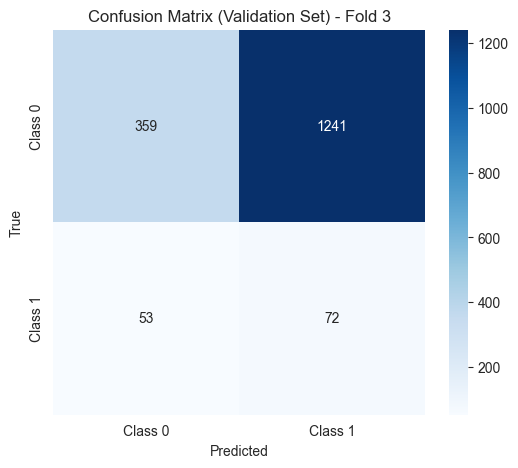

Fold 4/5


Epoch 1/20
Train Loss: 1.5416 | Train ROC-AUC: 0.4203 | Train Accuracy: 0.2654
Validation Loss: 0.4037 | Validation ROC-AUC: 0.2464 | Validation Accuracy: 0.2406


Epoch 2/20
Train Loss: 1.5470 | Train ROC-AUC: 0.4160 | Train Accuracy: 0.2633
Validation Loss: 0.4038 | Validation ROC-AUC: 0.2461 | Validation Accuracy: 0.2446


Epoch 3/20
Train Loss: 1.5389 | Train ROC-AUC: 0.4311 | Train Accuracy: 0.2691
Validation Loss: 0.4037 | Validation ROC-AUC: 0.2455 | Validation Accuracy: 0.2412


Epoch 4/20
Train Loss: 1.5386 | Train ROC-AUC: 0.4281 | Train Accuracy: 0.2606
Validation Loss: 0.4034 | Validation ROC-AUC: 0.2471 | Validation Accuracy: 0.2406


Epoch 5/20
Train Loss: 1.5451 | Train ROC-AUC: 0.4165 | Train Accuracy: 0.2624
Validation Loss: 0.4042 | Validation ROC-AUC: 0.2430 | Validation Accuracy: 0.2388


Epoch 6/20
Train Loss: 1.5404 | Train ROC-AUC: 0.4259 | Train Accuracy: 0.2657
Validation Loss: 0.4039 | Validation ROC-AUC: 0.2443 | Validation Accuracy: 0.2383


Epoch 7/20
Train Loss: 1.5367 | Train ROC-AUC: 0.4329 | Train Accuracy: 0.2712
Validation Loss: 0.4041 | Validation ROC-AUC: 0.2428 | Validation Accuracy: 0.2377


Epoch 8/20
Train Loss: 1.5356 | Train ROC-AUC: 0.4327 | Train Accuracy: 0.2692
Validation Loss: 0.4039 | Validation ROC-AUC: 0.2443 | Validation Accuracy: 0.2412


Epoch 9/20
Train Loss: 1.5500 | Train ROC-AUC: 0.4142 | Train Accuracy: 0.2635
Validation Loss: 0.4040 | Validation ROC-AUC: 0.2444 | Validation Accuracy: 0.2452


Epoch 10/20
Train Loss: 1.5493 | Train ROC-AUC: 0.4104 | Train Accuracy: 0.2625
Validation Loss: 0.4041 | Validation ROC-AUC: 0.2447 | Validation Accuracy: 0.2446


Epoch 11/20
Train Loss: 1.5441 | Train ROC-AUC: 0.4212 | Train Accuracy: 0.2695
Validation Loss: 0.4042 | Validation ROC-AUC: 0.2428 | Validation Accuracy: 0.2423


Epoch 12/20
Train Loss: 1.5357 | Train ROC-AUC: 0.4353 | Train Accuracy: 0.2660
Validation Loss: 0.4039 | Validation ROC-AUC: 0.2442 | Validation Accuracy: 0.2406


Epoch 13/20
Train Loss: 1.5471 | Train ROC-AUC: 0.4141 | Train Accuracy: 0.2685
Validation Loss: 0.4038 | Validation ROC-AUC: 0.2448 | Validation Accuracy: 0.2383


Epoch 14/20
Train Loss: 1.5433 | Train ROC-AUC: 0.4216 | Train Accuracy: 0.2676
Validation Loss: 0.4043 | Validation ROC-AUC: 0.2414 | Validation Accuracy: 0.2388


Epoch 15/20
Train Loss: 1.5387 | Train ROC-AUC: 0.4357 | Train Accuracy: 0.2673
Validation Loss: 0.4037 | Validation ROC-AUC: 0.2463 | Validation Accuracy: 0.2394


Epoch 16/20
Train Loss: 1.5421 | Train ROC-AUC: 0.4261 | Train Accuracy: 0.2688
Validation Loss: 0.4035 | Validation ROC-AUC: 0.2461 | Validation Accuracy: 0.2371


Epoch 17/20
Train Loss: 1.5434 | Train ROC-AUC: 0.4197 | Train Accuracy: 0.2660
Validation Loss: 0.4034 | Validation ROC-AUC: 0.2476 | Validation Accuracy: 0.2406


Epoch 18/20
Train Loss: 1.5413 | Train ROC-AUC: 0.4207 | Train Accuracy: 0.2664
Validation Loss: 0.4037 | Validation ROC-AUC: 0.2440 | Validation Accuracy: 0.2365


Epoch 19/20
Train Loss: 1.5468 | Train ROC-AUC: 0.4164 | Train Accuracy: 0.2612
Validation Loss: 0.4037 | Validation ROC-AUC: 0.2467 | Validation Accuracy: 0.2423


Epoch 20/20
Train Loss: 1.5388 | Train ROC-AUC: 0.4313 | Train Accuracy: 0.2667
Validation Loss: 0.4042 | Validation ROC-AUC: 0.2419 | Validation Accuracy: 0.2400


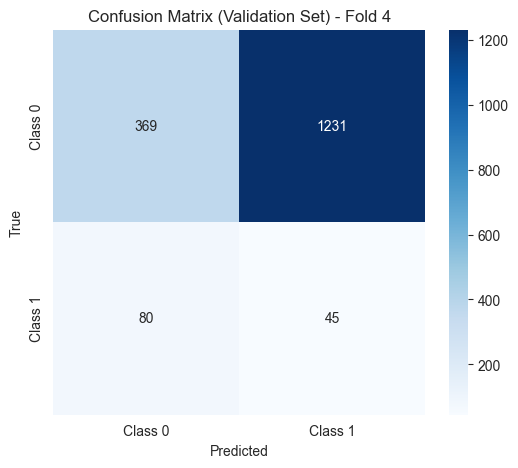

Fold 5/5


Epoch 1/20
Train Loss: 1.5454 | Train ROC-AUC: 0.4157 | Train Accuracy: 0.2689
Validation Loss: 0.4027 | Validation ROC-AUC: 0.2718 | Validation Accuracy: 0.2388


Epoch 2/20
Train Loss: 1.5392 | Train ROC-AUC: 0.4214 | Train Accuracy: 0.2591
Validation Loss: 0.4023 | Validation ROC-AUC: 0.2735 | Validation Accuracy: 0.2446


Epoch 3/20
Train Loss: 1.5379 | Train ROC-AUC: 0.4257 | Train Accuracy: 0.2664
Validation Loss: 0.4025 | Validation ROC-AUC: 0.2730 | Validation Accuracy: 0.2394


Epoch 4/20
Train Loss: 1.5368 | Train ROC-AUC: 0.4248 | Train Accuracy: 0.2670
Validation Loss: 0.4019 | Validation ROC-AUC: 0.2758 | Validation Accuracy: 0.2348


Epoch 5/20
Train Loss: 1.5450 | Train ROC-AUC: 0.4166 | Train Accuracy: 0.2641
Validation Loss: 0.4021 | Validation ROC-AUC: 0.2767 | Validation Accuracy: 0.2452


Epoch 6/20
Train Loss: 1.5396 | Train ROC-AUC: 0.4222 | Train Accuracy: 0.2628
Validation Loss: 0.4022 | Validation ROC-AUC: 0.2760 | Validation Accuracy: 0.2371


Epoch 7/20
Train Loss: 1.5404 | Train ROC-AUC: 0.4219 | Train Accuracy: 0.2641
Validation Loss: 0.4023 | Validation ROC-AUC: 0.2753 | Validation Accuracy: 0.2458


Epoch 8/20
Train Loss: 1.5463 | Train ROC-AUC: 0.4087 | Train Accuracy: 0.2657
Validation Loss: 0.4020 | Validation ROC-AUC: 0.2747 | Validation Accuracy: 0.2400


Epoch 9/20
Train Loss: 1.5430 | Train ROC-AUC: 0.4195 | Train Accuracy: 0.2649
Validation Loss: 0.4023 | Validation ROC-AUC: 0.2741 | Validation Accuracy: 0.2412


Epoch 10/20
Train Loss: 1.5398 | Train ROC-AUC: 0.4215 | Train Accuracy: 0.2535
Validation Loss: 0.4023 | Validation ROC-AUC: 0.2736 | Validation Accuracy: 0.2359


Epoch 11/20
Train Loss: 1.5364 | Train ROC-AUC: 0.4339 | Train Accuracy: 0.2756
Validation Loss: 0.4019 | Validation ROC-AUC: 0.2768 | Validation Accuracy: 0.2412


Epoch 12/20
Train Loss: 1.5462 | Train ROC-AUC: 0.4115 | Train Accuracy: 0.2627
Validation Loss: 0.4017 | Validation ROC-AUC: 0.2785 | Validation Accuracy: 0.2406


Epoch 13/20
Train Loss: 1.5442 | Train ROC-AUC: 0.4164 | Train Accuracy: 0.2677
Validation Loss: 0.4024 | Validation ROC-AUC: 0.2739 | Validation Accuracy: 0.2400


Epoch 14/20
Train Loss: 1.5454 | Train ROC-AUC: 0.4086 | Train Accuracy: 0.2667
Validation Loss: 0.4023 | Validation ROC-AUC: 0.2741 | Validation Accuracy: 0.2377


Epoch 15/20
Train Loss: 1.5437 | Train ROC-AUC: 0.4104 | Train Accuracy: 0.2615
Validation Loss: 0.4020 | Validation ROC-AUC: 0.2761 | Validation Accuracy: 0.2435


Epoch 16/20
Train Loss: 1.5416 | Train ROC-AUC: 0.4215 | Train Accuracy: 0.2672
Validation Loss: 0.4021 | Validation ROC-AUC: 0.2748 | Validation Accuracy: 0.2452


Epoch 17/20
Train Loss: 1.5425 | Train ROC-AUC: 0.4185 | Train Accuracy: 0.2677
Validation Loss: 0.4023 | Validation ROC-AUC: 0.2743 | Validation Accuracy: 0.2429


Epoch 18/20
Train Loss: 1.5403 | Train ROC-AUC: 0.4195 | Train Accuracy: 0.2669
Validation Loss: 0.4022 | Validation ROC-AUC: 0.2737 | Validation Accuracy: 0.2423


Epoch 19/20
Train Loss: 1.5504 | Train ROC-AUC: 0.4045 | Train Accuracy: 0.2602
Validation Loss: 0.4020 | Validation ROC-AUC: 0.2763 | Validation Accuracy: 0.2400


Epoch 20/20
Train Loss: 1.5453 | Train ROC-AUC: 0.4128 | Train Accuracy: 0.2680
Validation Loss: 0.4022 | Validation ROC-AUC: 0.2768 | Validation Accuracy: 0.2458


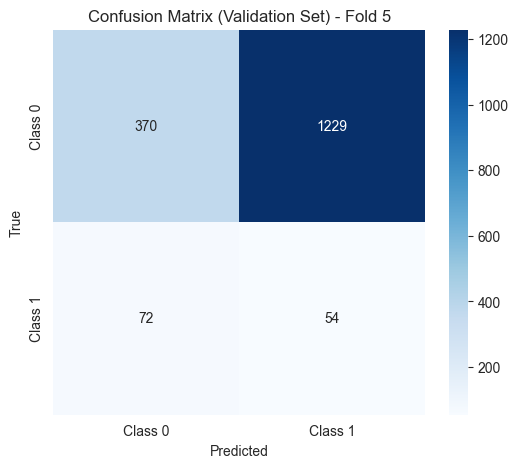

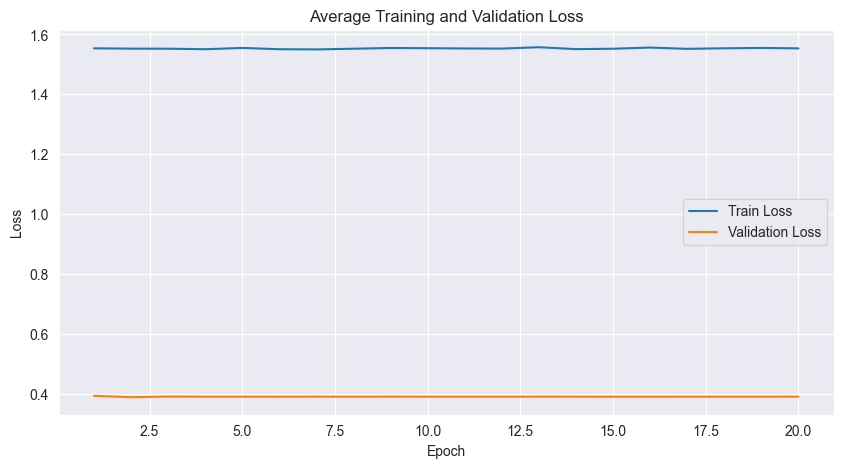

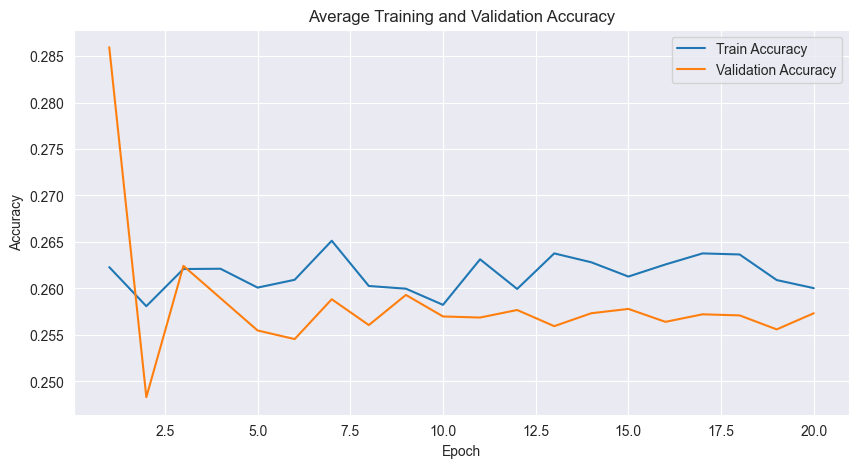

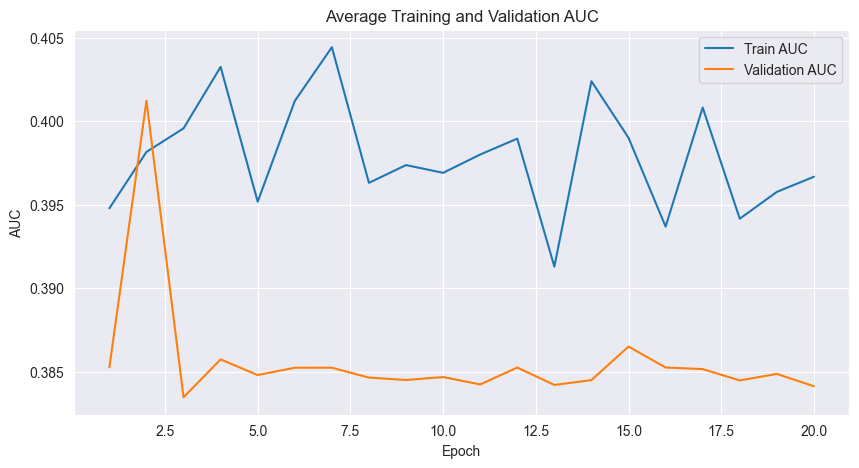

In [48]:
train_and_evaluate_cv(dataset,model_b0,criterion,optim,num_epoch,device,'effnet_Itt_2',weight_decay= 1e-4,n_splits=5)

### Evaluating resnet-50 itteration 1

mps


/var/folders/d2/dsq0cfpj3wnf4dxf7hwsn5w00000gn/T/ipykernel_95630/2414362607.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

Test Accuracy: 0.9341
Test ROC-AUC: 0.8881
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.95      0.97      2000
     Class 1       0.31      0.58      0.40        79

    accuracy                           0.93      2079
   macro avg       0.64      0.77      0.68      2079
weighted avg       0.96      0.93      0.94      2079



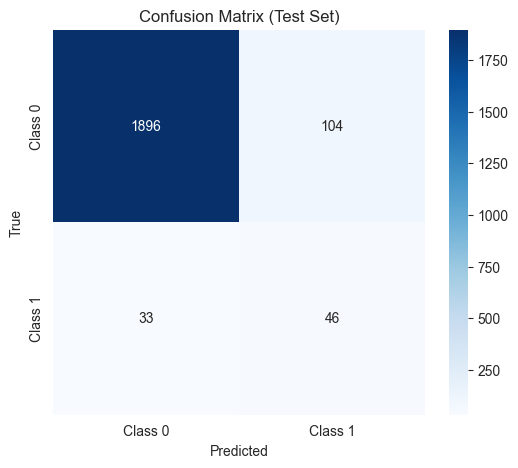

In [42]:
import torch
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print(device)
num_folds = 5
model_paths = [f'resnet_itt_1_fold{fold+1}.pth' for fold in range(num_folds)]

test_dataset = datasets.ImageFolder('test_dataset', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

models = []
for model_path in model_paths:
    model = resnet50()
    model.fc = nn.Linear(model.fc.in_features, 1)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    models.append(model)

def get_ensemble_predictions(models, loader):
    all_preds = []

    with torch.no_grad():
        for inputs, _ in tqdm(loader, desc="Testing"):
            inputs = inputs.to(device)
            preds = [torch.sigmoid(model(inputs)).cpu().numpy() for model in models]
            ensemble_preds = np.mean(preds, axis=0)
            all_preds.extend(ensemble_preds)

    return np.array(all_preds).squeeze()

test_targets = test_dataset.targets if hasattr(test_dataset, 'targets') else test_dataset.labels
test_preds = get_ensemble_predictions(models, test_loader)
test_preds_binary = np.round(test_preds)

test_accuracy = accuracy_score(test_targets, test_preds_binary)
test_auc = roc_auc_score(test_targets, test_preds)
cm = confusion_matrix(test_targets, test_preds_binary)
class_report = classification_report(test_targets, test_preds_binary, target_names=['Class 0', 'Class 1'])

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test ROC-AUC: {test_auc:.4f}')
print('Classification Report:')
print(class_report)

# CM
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

### Evaluating resnet-50 itteration 2

mps


/var/folders/d2/dsq0cfpj3wnf4dxf7hwsn5w00000gn/T/ipykernel_76233/2658913071.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

Test Accuracy: 0.9649
Test ROC-AUC: 0.8782
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.99      0.98      2000
     Class 1       0.61      0.22      0.32        79

    accuracy                           0.96      2079
   macro avg       0.79      0.60      0.65      2079
weighted avg       0.96      0.96      0.96      2079



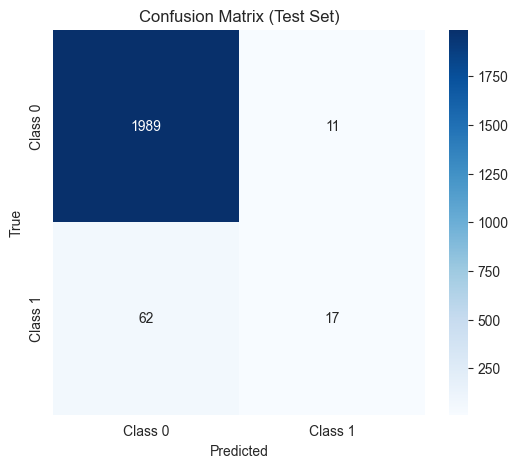

In [15]:
import torch
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print(device)
num_folds = 5
model_paths = [f'resnet_itt_2_fold{fold+1}.pth' for fold in range(num_folds)]

test_dataset = datasets.ImageFolder('test_dataset', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

models = []
for model_path in model_paths:
    model = resnet50()
    model.fc = nn.Linear(model.fc.in_features, 1)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    models.append(model)

def get_ensemble_predictions(models, loader):
    all_preds = []

    with torch.no_grad():
        for inputs, _ in tqdm(loader, desc="Testing"):
            inputs = inputs.to(device)
            preds = [torch.sigmoid(model(inputs)).cpu().numpy() for model in models]
            ensemble_preds = np.mean(preds, axis=0)
            all_preds.extend(ensemble_preds)

    return np.array(all_preds).squeeze()

test_targets = test_dataset.targets if hasattr(test_dataset, 'targets') else test_dataset.labels
test_preds = get_ensemble_predictions(models, test_loader)
test_preds_binary = np.round(test_preds)

test_accuracy = accuracy_score(test_targets, test_preds_binary)
test_auc = roc_auc_score(test_targets, test_preds)
cm = confusion_matrix(test_targets, test_preds_binary)
class_report = classification_report(test_targets, test_preds_binary, target_names=['Class 0', 'Class 1'])

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test ROC-AUC: {test_auc:.4f}')
print('Classification Report:')
print(class_report)

# CM
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

### Evaluating resnet-50 itteration 3

mps


/var/folders/d2/dsq0cfpj3wnf4dxf7hwsn5w00000gn/T/ipykernel_76233/73936927.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.9500
Test ROC-AUC: 0.8866
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.97      0.97      2000
     Class 1       0.37      0.43      0.40        79

    accuracy                           0.95      2079
   macro avg       0.67      0.70      0.68      2079
weighted avg       0.95      0.95      0.95      2079



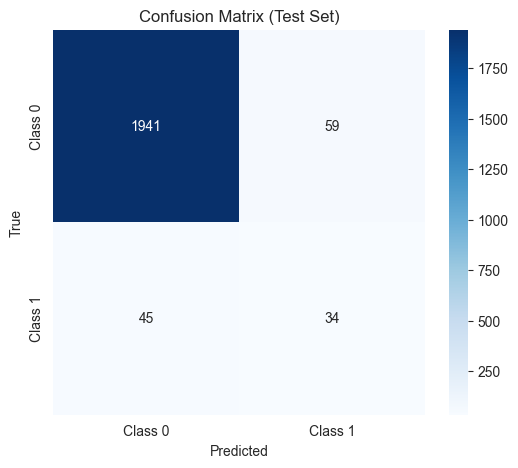

In [16]:
import torch
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print(device)
num_folds = 5
model_paths = [f'resnet_itt_3_fold{fold+1}.pth' for fold in range(num_folds)]

test_dataset = datasets.ImageFolder('test_dataset', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

models = []
for model_path in model_paths:
    model = resnet50()
    model.fc = nn.Linear(model.fc.in_features, 1)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    models.append(model)

def get_ensemble_predictions(models, loader):
    all_preds = []

    with torch.no_grad():
        for inputs, _ in tqdm(loader, desc="Testing"):
            inputs = inputs.to(device)
            preds = [torch.sigmoid(model(inputs)).cpu().numpy() for model in models]
            ensemble_preds = np.mean(preds, axis=0)
            all_preds.extend(ensemble_preds)

    return np.array(all_preds).squeeze()

test_targets = test_dataset.targets if hasattr(test_dataset, 'targets') else test_dataset.labels
test_preds = get_ensemble_predictions(models, test_loader)
test_preds_binary = np.round(test_preds)

test_accuracy = accuracy_score(test_targets, test_preds_binary)
test_auc = roc_auc_score(test_targets, test_preds)
cm = confusion_matrix(test_targets, test_preds_binary)
class_report = classification_report(test_targets, test_preds_binary, target_names=['Class 0', 'Class 1'])

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test ROC-AUC: {test_auc:.4f}')
print('Classification Report:')
print(class_report)

# CM
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

### EfficientNet Itteration 1

mps
Loaded pretrained weights for efficientnet-b0


/var/folders/d2/dsq0cfpj3wnf4dxf7hwsn5w00000gn/T/ipykernel_76918/963866516.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


Testing: 100%|██████████| 65/65 [00:29<00:00,  2.17it/s]

Test Accuracy: 0.5599
Test ROC-AUC: 0.4585
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.57      0.71      2000
     Class 1       0.04      0.41      0.07        79

    accuracy                           0.56      2079
   macro avg       0.50      0.49      0.39      2079
weighted avg       0.93      0.56      0.69      2079



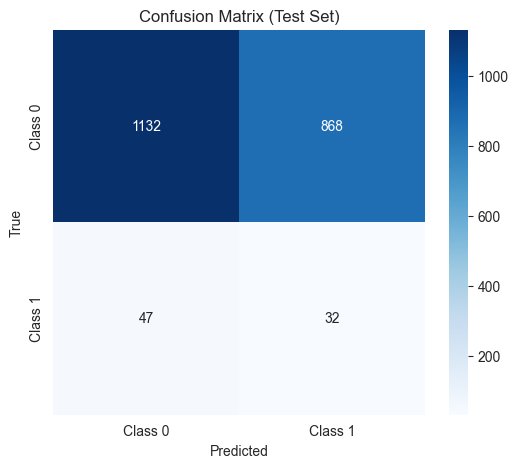

In [14]:
import torch
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torchvision import datasets, transforms

def load_efficientnet(model_path):
    model = EfficientNet.from_pretrained('efficientnet-b0')
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, 1)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

print(device)
num_folds = 5
model_paths = [f'effnet_Itt_1_fold{fold+1}.pth' for fold in range(num_folds)]

test_dataset = datasets.ImageFolder('test_dataset', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

models = []
for model_path in model_paths:
    model = load_efficientnet(model_path)
    models.append(model)

def get_ensemble_predictions(models, loader):
    all_preds = []

    with torch.no_grad():
        for inputs, _ in tqdm(loader, desc="Testing"):
            inputs = inputs.to(device)
            preds = [torch.sigmoid(model(inputs)).cpu().numpy() for model in models]
            ensemble_preds = np.mean(preds, axis=0)
            all_preds.extend(ensemble_preds)

    return np.array(all_preds).squeeze()

test_targets = test_dataset.targets if hasattr(test_dataset, 'targets') else test_dataset.samples
test_preds = get_ensemble_predictions(models, test_loader)
test_preds_binary = np.round(test_preds)

test_accuracy = accuracy_score(test_targets, test_preds_binary)
test_auc = roc_auc_score(test_targets, test_preds)
cm = confusion_matrix(test_targets, test_preds_binary)
class_report = classification_report(test_targets, test_preds_binary, target_names=['Class 0', 'Class 1'])

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test ROC-AUC: {test_auc:.4f}')
print('Classification Report:')
print(class_report)

# CM
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

### Efficient Net Itteration 2

mps
Loaded pretrained weights for efficientnet-b0


/var/folders/d2/dsq0cfpj3wnf4dxf7hwsn5w00000gn/T/ipykernel_76918/2963707767.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


Testing: 100%|██████████| 65/65 [00:29<00:00,  2.24it/s]

Test Accuracy: 0.2492
Test ROC-AUC: 0.4967
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.23      0.37      2000
     Class 1       0.04      0.76      0.07        79

    accuracy                           0.25      2079
   macro avg       0.50      0.49      0.22      2079
weighted avg       0.93      0.25      0.36      2079



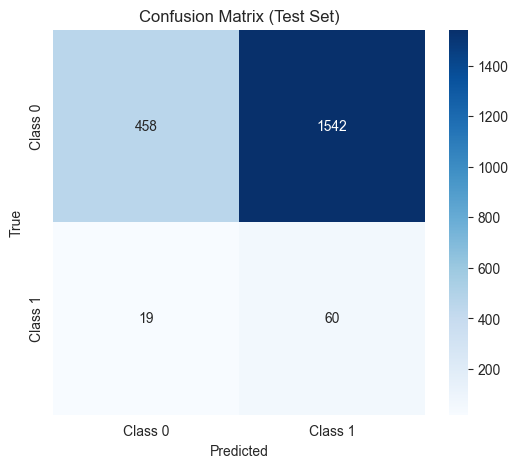

In [15]:
import torch
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torchvision import datasets, transforms

def load_efficientnet(model_path):
    model = EfficientNet.from_pretrained('efficientnet-b0')
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, 1)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

print(device)
num_folds = 5
model_paths = [f'effnet_Itt_2_fold{fold+1}.pth' for fold in range(num_folds)]

test_dataset = datasets.ImageFolder('test_dataset', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

models = []
for model_path in model_paths:
    model = load_efficientnet(model_path)
    models.append(model)

def get_ensemble_predictions(models, loader):
    all_preds = []

    with torch.no_grad():
        for inputs, _ in tqdm(loader, desc="Testing"):
            inputs = inputs.to(device)
            preds = [torch.sigmoid(model(inputs)).cpu().numpy() for model in models]
            ensemble_preds = np.mean(preds, axis=0)
            all_preds.extend(ensemble_preds)

    return np.array(all_preds).squeeze()

test_targets = test_dataset.targets if hasattr(test_dataset, 'targets') else test_dataset.samples
test_preds = get_ensemble_predictions(models, test_loader)
test_preds_binary = np.round(test_preds)

test_accuracy = accuracy_score(test_targets, test_preds_binary)
test_auc = roc_auc_score(test_targets, test_preds)
cm = confusion_matrix(test_targets, test_preds_binary)
class_report = classification_report(test_targets, test_preds_binary, target_names=['Class 0', 'Class 1'])

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test ROC-AUC: {test_auc:.4f}')
print('Classification Report:')
print(class_report)

# CM
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

### Training Best model 

Epoch [1/30], Loss: 1.4345, Accuracy: 0.6637, AUC: 0.6149
Validation - Epoch [1/30], Loss: 1.1566, Accuracy: 0.7041, AUC: 0.7142
Epoch [2/30], Loss: 1.0889, Accuracy: 0.7958, AUC: 0.7327
Validation - Epoch [2/30], Loss: 0.8760, Accuracy: 0.8557, AUC: 0.8046
Epoch [3/30], Loss: 0.9981, Accuracy: 0.8055, AUC: 0.7728
Validation - Epoch [3/30], Loss: 0.9455, Accuracy: 0.8677, AUC: 0.7383
Epoch [4/30], Loss: 1.0217, Accuracy: 0.7941, AUC: 0.7633
Validation - Epoch [4/30], Loss: 0.9720, Accuracy: 0.8380, AUC: 0.7471
Epoch [5/30], Loss: 1.0230, Accuracy: 0.7847, AUC: 0.7567
Validation - Epoch [5/30], Loss: 0.8530, Accuracy: 0.8244, AUC: 0.7884
Epoch [6/30], Loss: 0.9775, Accuracy: 0.7860, AUC: 0.7696
Validation - Epoch [6/30], Loss: 0.7849, Accuracy: 0.7955, AUC: 0.8219
Epoch [7/30], Loss: 0.9706, Accuracy: 0.8037, AUC: 0.7631
Validation - Epoch [7/30], Loss: 0.7788, Accuracy: 0.7498, AUC: 0.8224
Epoch [8/30], Loss: 0.9741, Accuracy: 0.7955, AUC: 0.7710
Validation - Epoch [8/30], Loss: 0.7818

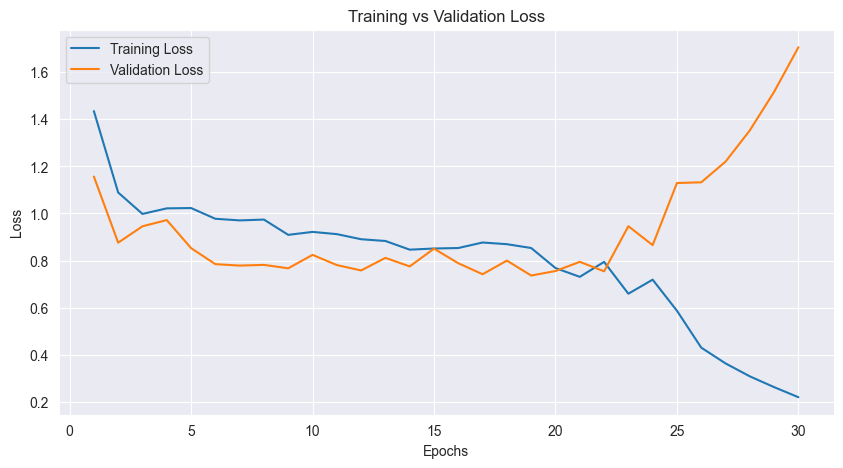

In [21]:
num_class_0 = 8000
num_class_1 = 315
pos_weight = torch.tensor([num_class_0 / num_class_1], dtype=torch.float32).to(device)

model = resnet50()
model.fc = nn.Linear(model.fc.in_features, 1)
model.to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

num_epochs = 30

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    y_true_train = []
    y_pred_train = []

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().view(-1, 1)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(torch.sigmoid(outputs).cpu().detach().numpy())

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    y_pred_train = [1 if pred >= 0.5 else 0 for pred in y_pred_train]

    train_accuracy = accuracy_score(y_true_train, y_pred_train)
    train_auc = roc_auc_score(y_true_train, y_pred_train)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.4f}, AUC: {train_auc:.4f}')

    model.eval()
    val_running_loss = 0.0
    y_true_val = []
    y_pred_val = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            y_true_val.extend(labels.cpu().numpy())
            y_pred_val.extend(torch.sigmoid(outputs).cpu().numpy())

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)
    y_pred_val = [1 if pred >= 0.5 else 0 for pred in y_pred_val]

    val_accuracy = accuracy_score(y_true_val, y_pred_val)
    val_auc = roc_auc_score(y_true_val, y_pred_val)

    print(f'Validation - Epoch [{epoch + 1}/{num_epochs}], Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, AUC: {val_auc:.4f}')

    scheduler.step(val_loss)

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

torch.save(model.state_dict(), 'best_weights.pth')

Epoch [1/20], Loss: 1.3688, Accuracy: 0.7212, AUC: 0.6518
Validation - Epoch [1/20], Loss: 1.0274, Accuracy: 0.7458, AUC: 0.6995
Epoch [2/20], Loss: 1.1300, Accuracy: 0.8003, AUC: 0.7333
Validation - Epoch [2/20], Loss: 1.0604, Accuracy: 0.8252, AUC: 0.7163
Epoch [3/20], Loss: 1.0471, Accuracy: 0.8007, AUC: 0.7563
Validation - Epoch [3/20], Loss: 0.8034, Accuracy: 0.8725, AUC: 0.8012
Epoch [4/20], Loss: 1.0200, Accuracy: 0.7835, AUC: 0.7578
Validation - Epoch [4/20], Loss: 0.8911, Accuracy: 0.8492, AUC: 0.7892
Epoch [5/20], Loss: 0.9633, Accuracy: 0.8016, AUC: 0.7812
Validation - Epoch [5/20], Loss: 0.7842, Accuracy: 0.8909, AUC: 0.7986
Epoch [6/20], Loss: 0.9326, Accuracy: 0.8047, AUC: 0.7863
Validation - Epoch [6/20], Loss: 0.9392, Accuracy: 0.9038, AUC: 0.7327
Epoch [7/20], Loss: 0.9295, Accuracy: 0.8130, AUC: 0.7837
Validation - Epoch [7/20], Loss: 0.8950, Accuracy: 0.7939, AUC: 0.7364
Epoch [8/20], Loss: 0.8861, Accuracy: 0.8186, AUC: 0.7953
Validation - Epoch [8/20], Loss: 1.0225

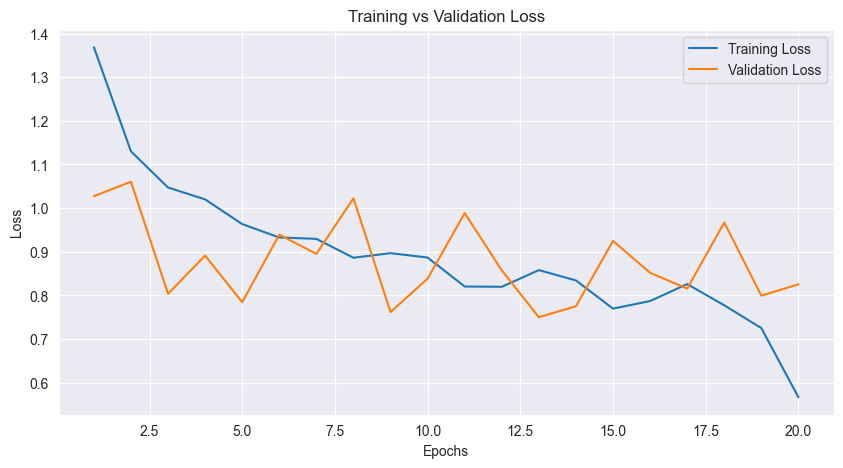

In [24]:
num_class_0 = 8000
num_class_1 = 315
pos_weight = torch.tensor([num_class_0 / num_class_1], dtype=torch.float32).to(device)

model = resnet50()
model.fc = nn.Linear(model.fc.in_features, 1)
model.to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

num_epochs = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    y_true_train = []
    y_pred_train = []

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().view(-1, 1)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(torch.sigmoid(outputs).cpu().detach().numpy())

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    y_pred_train = [1 if pred >= 0.5 else 0 for pred in y_pred_train]

    train_accuracy = accuracy_score(y_true_train, y_pred_train)
    train_auc = roc_auc_score(y_true_train, y_pred_train)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.4f}, AUC: {train_auc:.4f}')

    model.eval()
    val_running_loss = 0.0
    y_true_val = []
    y_pred_val = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            y_true_val.extend(labels.cpu().numpy())
            y_pred_val.extend(torch.sigmoid(outputs).cpu().numpy())

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)
    y_pred_val = [1 if pred >= 0.5 else 0 for pred in y_pred_val]

    val_accuracy = accuracy_score(y_true_val, y_pred_val)
    val_auc = roc_auc_score(y_true_val, y_pred_val)

    print(f'Validation - Epoch [{epoch + 1}/{num_epochs}], Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, AUC: {val_auc:.4f}')

    scheduler.step(val_loss)

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

torch.save(model.state_dict(), 'best_weights.pth')

/var/folders/d2/dsq0cfpj3wnf4dxf7hwsn5w00000gn/T/ipykernel_76918/3284579027.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_weight

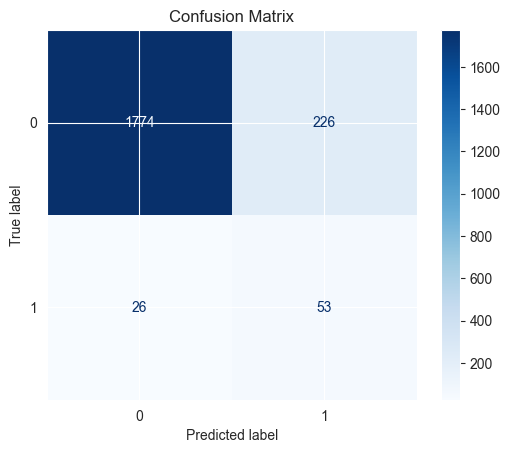

Test Loss: 0.9784
Test Accuracy: 0.8788
Test AUC: 0.8745
Confusion Matrix:
[[1774  226]
 [  26   53]]


In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = resnet50()
model.fc = nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load('best_weights.pth'))
model.to(device)

model.eval()

test_running_loss = 0.0
y_true_test = []
y_pred_test = []

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().view(-1, 1)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item()
        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(torch.sigmoid(outputs).cpu().numpy())

test_loss = test_running_loss / len(test_loader)

y_pred_test_binary = [1 if pred >= 0.5 else 0 for pred in y_pred_test]

test_accuracy = accuracy_score(y_true_test, y_pred_test_binary)
test_auc = roc_auc_score(y_true_test, y_pred_test)

cm = confusion_matrix(y_true_test, y_pred_test_binary)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print('Confusion Matrix:')
print(cm)

/var/folders/d2/dsq0cfpj3wnf4dxf7hwsn5w00000gn/T/ipykernel_76918/3706606660.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_weigh

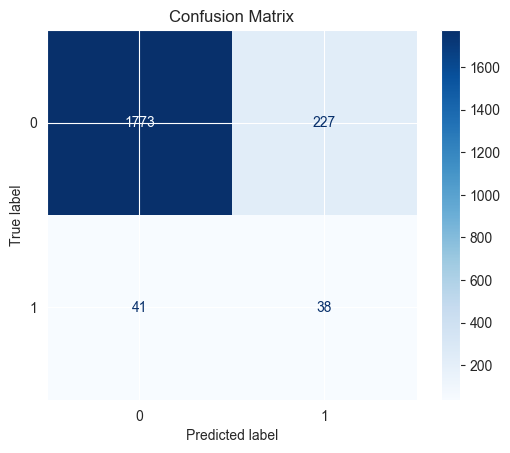

Test Loss: 1.7222
Test Accuracy: 0.8711
Test AUC: 0.7923
Confusion Matrix:
[[1773  227]
 [  41   38]]


In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = resnet50()
model.fc = nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load('best_weights.pth'))
model.to(device)

model.eval()

test_running_loss = 0.0
y_true_test = []
y_pred_test = []

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().view(-1, 1)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item()
        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(torch.sigmoid(outputs).cpu().numpy())

test_loss = test_running_loss / len(test_loader)

y_pred_test_binary = [1 if pred >= 0.5 else 0 for pred in y_pred_test]

test_accuracy = accuracy_score(y_true_test, y_pred_test_binary)
test_auc = roc_auc_score(y_true_test, y_pred_test)

cm = confusion_matrix(y_true_test, y_pred_test_binary)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print('Confusion Matrix:')
print(cm)